In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import MNISTSuperpixels
import torch 
from torch import nn
import numpy as np
from torch_geometric.data import Data
import pandas as pd
from pathlib import Path
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import to_networkx
from scipy.spatial.distance import pdist,cdist
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import community

from tqdm.auto import trange

#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
import torch
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************
randomSeedEnabled = False
if randomSeedEnabled:
    numpyRandomSeed = np.random.seed(12345)
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************
#*******************************************************************************************************

2.0.1+cu118


C:\Users\Josh\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,num_classes,num_node_features):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels,num_classes)#, dataset.num_classes)

    def forward(self, x, edge_index, batch,edge_attr=None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin(x)
        
        return x
    
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels,num_classes,num_node_features):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels,num_classes)#, dataset.num_classes)

    def forward(self, x, edge_index, batch,edge_attr=None):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        #print(x)
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin(x)
        
        return x
    
def train():
    model.train()
    #lossList = []
    outList = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        #print(data)
        out = model(data.x, data.edge_index, data.batch, data.edge_attr)  # Perform a single forward pass.
        outList += [out.detach().numpy().tolist()]
        #print(data.y)
        loss = criterion(out, data.y)  # Compute the loss.
        #lossList += [loss.detach().numpy().tolist()]
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return outList #lossList
    #print(f'loss: {loss:.4f}')
    
    
    
    

def test(loader, isSignalArray):
    model.eval()
    correct = 0
    signalCorrect = 0
    backgroundCorrect = 0
    startSlice = 0
    endSlice = loader.batch_size
    signalNum = 0
    backgroundNum = 0
    outList = []
    lossList = []
    #print(len(outList))
    for data in loader:  # Iterate in batches over the training/test dataset.
        batch_num = data.num_graphs
        isSignalArraySlice = isSignalArray[startSlice:endSlice]
        out = model(data.x, data.edge_index, data.batch, data.edge_attr) 
        #print(out)
        outList += out.detach().numpy().tolist()
        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        print(torch.sum(param.data.clone()))
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        
        whereSignal = np.where(isSignalArraySlice==1)[0]
        whereNotSignal = np.where(isSignalArraySlice==0)[0]
        signalPred = pred[whereSignal]
        backgroundPred = pred[whereNotSignal]
        signalNum += len(signalPred)
        backgroundNum += len(backgroundPred)
        
        signalCorrect += int((signalPred == data.y[whereSignal]).sum())
        backgroundCorrect += int((backgroundPred == data.y[whereNotSignal]).sum())
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        
        startSlice+= batch_num
        endSlice+= batch_num
        
        loss = criterion(out, data.y)  # Compute the loss.
        lossList += [loss.detach().numpy().tolist()]
        
    return correct / len(loader.dataset), signalCorrect/signalNum, backgroundCorrect/backgroundNum \
            ,lossList #,outList#,whereSignal,whereNotSignal  # Derive ratio of correct predictions.






def setGraphs(dir_path):
    fileNames = []
    graphClass = []
    directories = os.listdir(dir_path)
    data_path = str(dir_path)
    for dirName in directories:
        print(dirName)
        listDir = os.listdir(data_path + "\\" + dirName)
        fileNames += [data_path + "\\" + dirName + "\\" + name for name in listDir]
        if "beta" in dirName:
            #fileNames += os.listdir(data_path + "\\" + dirName)
            graphClass += [1] * len(fileNames)
        else:
            print("it's a zero!")
            graphClass += [0] * len(fileNames)
    return fileNames,graphClass


def findNeighbors(coordinates
                  ,energy
                  ,distanceMetric = 'euclidean'
                  ,distanceCutoff = 10
                 ):
    
    #df = pd.read_csv(filePaths
    #                    ,header=None
    #                    ,delim_whitespace=True)
    #df = df.T.to_numpy()[1:4]
    numNeighbors = []
    avgEnergy = []
    avgLinkDist = []
    edgeIndices = [[],[]]
    relativeDistanceList = []
    
    coordinatesProper = list(zip(coordinates[0],coordinates[1],coordinates[2]))
    
    for i in range(len(coordinatesProper)):
        
        relativeDistance = cdist(coordinatesProper[:], [coordinatesProper[i]])
        relativeDistanceIndices = np.array(list(range(len(relativeDistance))))
        
        neighbors = np.where(relativeDistance<=distanceCutoff)[0]
        neighbors = neighbors[np.where(neighbors != i)[0]]
        #neighbors = np.append(neighbors[:i],neighbors[i+1:])
        
        relativeDistanceIndices = relativeDistanceIndices[neighbors]
        relativeDistance = relativeDistance[neighbors]
        
        edgeIndices[1] +=  relativeDistanceIndices.tolist()
        
        lenRelativeDistanceIndices = len(relativeDistanceIndices)
        numNeighbors += [lenRelativeDistanceIndices]
        edgeIndices[0] += [i] * lenRelativeDistanceIndices
        relativeDistanceList += relativeDistance.tolist()
            
        


        if sum(energy[i] == energy[relativeDistanceIndices]): print("ooohhhh nooooo")
        neighborEnergies = [energy[i]] + energy[relativeDistanceIndices].tolist() # want to include the energy of the point itself as well
        #print(len(nodeLinksDist))


        #neighborDist = nodeLinksDist[edgeIndices]


        
        if len(relativeDistance)>0:
            avgEnergy += [sum(neighborEnergies)/numNeighbors[i]]
            avgLinkDist += [sum(relativeDistance)/numNeighbors[i]]
        else:
            avgLinkDist += [0]
            avgEnergy += neighborEnergies

        
    return np.array(numNeighbors) \
         , np.array(avgEnergy) \
         , np.array(avgLinkDist) \
         , relativeDistanceList \
         , np.array(edgeIndices)


def createGraphData(filePaths
                    ,graphClass
                    ,energySignalEnalbed=True
                    ,energyCut=2.40
                    ,distanceMetric = 'euclidean'
                    ,distanceCutoff = 10
                   ):
    allData = pd.DataFrame(columns = ['GraphFileNames', 'nodes', 'nodeFeatures', 'edges', 'edgeAttributes'
                                      ,'graphClass','data','isSignal'])
    #graphClass = np.random.choice([0,1],len(graphClass)).tolist()
    for i,name in enumerate(filePaths):
        #print(name)
        df = pd.read_csv(name
                    ,header=None
                    ,delim_whitespace=True)
        energy = df.T.to_numpy()[4]#torch.tensor([[i] for i in df[4].to_numpy().tolist()], dtype=torch.float)
        coordinates = df.T.to_numpy()[1:4]
        
        if energySignalEnalbed:
            if sum(energy)>=energyCut and graphClass[i]==1: # data should only be trained on nbb that isn't clipped off
                print("it's a signal")
                isSignal = 1 # this is a signal
            else:
                isSignal = 0
        #else:
            #isSignal = 0 #not a signal
            #coordinates = df.T.to_numpy()[1:4]
            

        nodes = list(range(0,len(energy)))

        
        numNeighbors,avgEnergy,avgLinkDist,relativeDistanceList,edges = findNeighbors( coordinates
                                                                                 , df[4].to_numpy()
                                                                                 , distanceMetric
                                                                                 , distanceCutoff = distanceCutoff
                                                                                 ) 
        
        relativeDistanceList = torch.tensor(relativeDistanceList, dtype=torch.float)
        edges = torch.tensor(edges, dtype=torch.int64)
        #print(edges)
        #### ******* newest addition ****** #####
        x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
                         , dtype=torch.float)
        #### ******* newest addition ****** #####
        
        data = Data(x=x, 
                    edge_index=edges,
                    edge_attr=relativeDistanceList,
                    y=graphClass[i]
                   )
        if energySignalEnalbed:
            allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
                            , 'edges':edges, 'edgeAttributes':relativeDistanceList
                            ,'graphClass':graphClass[i],'data':data,'isSignal':isSignal}, ignore_index = True
                          )
        else:
            allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
                            , 'edges':edges, 'edgeAttributes':relativeDistanceList
                            ,'graphClass':graphClass[i],'data':data}, ignore_index = True
                          )
    return allData

In [4]:
data_path = Path("./20230413_NEXT/Data/")
#image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if data_path.is_dir():
    print(f"{data_path} directory exists.")

20230413_NEXT\Data directory exists.


In [5]:
#graphClass

In [6]:
energySignalEnalbed = True
fileNames,graphClass = setGraphs(data_path)
allGraphDataDf = createGraphData(fileNames
                                 ,graphClass
                                 ,distanceMetric = 'euclidean'
                                 ,energySignalEnalbed=energySignalEnalbed
                                 ,energyCut=0.0 # setting this to 0.0 will include all of the dataset
                                )

double_beta
single_electron
it's a zero!
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x


it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[data[0],data[1],data[2],data[3]] for data in zip(energy,numNeighbors,avgEnergy,avgLinkDist)]
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_14172\3580756804.py:246: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = torch.tensor([[dat

In [7]:
#if randomSeedEnabled:
#    allGraphData = allGraphDataDf.sample(frac = 1,random_state=numpyRandomSeed)
#else:
allGraphData = allGraphDataDf.sample(frac = 1,random_state=None) # shuffles data

allGraphData = allGraphData.to_numpy()
endTrainData = int(np.floor(3/4*len(allGraphData)))
train_dataset = allGraphData[0:endTrainData,:]
test_dataset = allGraphData[endTrainData:,:]
if energySignalEnalbed:
    train_loader = DataLoader(train_dataset[:,-2] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-2] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-3]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-3]
else:
    train_loader = DataLoader(train_dataset[:,-1] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-1] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-2]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-2]

In [8]:
#train_dataset

In [9]:
model = GAT(hidden_channels=64, num_classes=2, num_node_features = 4)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()

In [10]:
for data in train_loader:
    data.x

In [11]:
plt.style.use("ggplot")
avgLossTrainList = []
avgLossTestList = []

avgLossNbbTestList = []
avgLossSeTestList = []

avgLossNbbTrainList = []
avgLossSeTrainList = []

nbbTrain = np.where(train_dataset[:,-1]==1)[0] #nutrinoless double beta decay
seTrain = np.where(train_dataset[:,-1]==0)[0]#single electron
nbbTest = np.where(test_dataset[:,-1]==1)[0] #nutrinoless double beta decay
seTest = np.where(test_dataset[:,-1]==0)[0]#single electron
for epoch in range(1, 75):
    train()


    train_acc,train_signal_acc,train_background_acc,lossTrainList = test(train_loader,isSignalArrayTraining)
    lossTrainList = np.array(lossTrainList)

    test_acc,test_signal_acc,test_background_acc,lossTestList = test(test_loader,isSignalArrayTesting)
    lossTestList = np.array(lossTestList)
    
    avgLossTrainList += [np.mean(lossTrainList)]
    avgLossTestList += [np.mean(lossTestList)]
    
    avgLossNbbTestList += [np.mean(lossTestList[nbbTest])]
    avgLossSeTestList += [np.mean(lossTestList[seTest])]

    avgLossNbbTrainList += [np.mean(lossTrainList[nbbTrain])]
    avgLossSeTrainList += [np.mean(lossTrainList[seTrain])]
    
    if epoch%5 == 0 or epoch==1:
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList,bins=100,alpha=0.25)
        plt.show()
        
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList[nbbTrain],bins=50,alpha=0.25,label="double beta")
        
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList[seTrain],bins=50,alpha=0.25,label="single electron")
        plt.legend()
        plt.show()
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList,bins=100,alpha=0.25)
        plt.show()
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList[nbbTest],bins=50,alpha=0.25,label="double beta")
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList[seTest],bins=50,alpha=0.25,label="single electron")
        plt.legend()
        plt.show()
    
    print(f'''Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}''')
        
        
    #print(f'''Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}''')
    #print(f'''Epoch: {epoch:03d}, train_signal_acc: {train_signal_acc:.4f}, train_background_acc: {train_background_acc:.4f}''')
    #print(f'''Epoch: {epoch:03d}, test_signal_acc: {test_signal_acc:.4f}, test_background_acc: {test_background_acc:.4f}''')



#for data in train_loader:
#    # training data
#    Y_hat = model(data.x)
#    train_loss = criterion(Y_hat, data.y)
#    train_err[i] = train_loss.item()
#
## validation data
#Y_hat = model(test_loader.x)
#val_loss = criterion(Y_hat, test_loader.y)
#val_err[i] = val_loss.item()

plt.title("average loss for training data")
plt.plot(list(range(1,epoch+1)), avgLossTrainList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTrainList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTrainList,label="double beta")
plt.legend()
plt.show()

plt.title("average loss for test data")
plt.plot(list(range(1,epoch+1)), avgLossTestList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTestList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTestList,label="double beta")
plt.legend()
plt.show()


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])) is deprecated. Please ensure they have the same size.

In [ ]:
energySignalEnalbed = True
fileNames,graphClass = setGraphs(data_path)
allGraphDataDf = createGraphData(fileNames
                                 ,graphClass
                                 ,distanceMetric = 'euclidean'
                                 ,energySignalEnalbed=energySignalEnalbed
                                 ,energyCut=0.0 # setting this to 0.0 will include all of the dataset
                                 ,distanceCutoff = 0.1
                                )

In [ ]:
allGraphData = allGraphDataDf.sample(frac = 1,random_state=None) # shuffles data

allGraphData = allGraphData.to_numpy()
endTrainData = int(np.floor(3/4*len(allGraphData)))
train_dataset = allGraphData[0:endTrainData,:]
test_dataset = allGraphData[endTrainData:,:]
if energySignalEnalbed:
    train_loader = DataLoader(train_dataset[:,-2] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-2] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-3]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-3]
else:
    train_loader = DataLoader(train_dataset[:,-1] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-1] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-2]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-2]
model = GAT(hidden_channels=64, num_classes=2, num_node_features = 4)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
criterion = torch.nn.CrossEntropyLoss()

plt.style.use("ggplot")

avgLossTrainList = []
avgLossTestList = []

avgLossNbbTestList = []
avgLossSeTestList = []

avgLossNbbTrainList = []
avgLossSeTrainList = []

nbbTrain = np.where(train_dataset[:,-1]==1)[0] #nutrinoless double beta decay
seTrain = np.where(train_dataset[:,-1]==0)[0]#single electron
nbbTest = np.where(test_dataset[:,-1]==1)[0] #nutrinoless double beta decay
seTest = np.where(test_dataset[:,-1]==0)[0]#single electron
for epoch in range(1, 75):
    train()


    train_acc,train_signal_acc,train_background_acc,lossTrainList = test(train_loader,isSignalArrayTraining)
    lossTrainList = np.array(lossTrainList)

    test_acc,test_signal_acc,test_background_acc,lossTestList = test(test_loader,isSignalArrayTesting)
    lossTestList = np.array(lossTestList)
    
    avgLossTrainList += [np.mean(lossTrainList)]
    avgLossTestList += [np.mean(lossTestList)]
    
    avgLossNbbTestList += [np.mean(lossTestList[nbbTest])]
    avgLossSeTestList += [np.mean(lossTestList[seTest])]

    avgLossNbbTrainList += [np.mean(lossTrainList[nbbTrain])]
    avgLossSeTrainList += [np.mean(lossTrainList[seTrain])]
    
    if epoch%5 == 0 or epoch==1:
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList,bins=100,alpha=0.25)
        plt.show()
        
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList[nbbTrain],bins=50,alpha=0.25,label="double beta")
        
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList[seTrain],bins=50,alpha=0.25,label="single electron")
        plt.legend()
        plt.show()
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList,bins=100,alpha=0.25)
        plt.show()
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList[nbbTest],bins=50,alpha=0.25,label="double beta")
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList[seTest],bins=50,alpha=0.25,label="single electron")
        plt.legend()
        plt.show()
    
    print(f'''Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}''')
plt.title("average loss for training data")
plt.plot(list(range(1,epoch+1)), avgLossTrainList)
plt.show()

plt.title("average loss for test data")
plt.plot(list(range(1,epoch+1)), avgLossTestList)
plt.show()

In [ ]:
plt.title("average loss for training data")
plt.plot(list(range(1,epoch+1)), avgLossTrainList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTrainList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTrainList,label="double beta")
plt.legend()
plt.show()

plt.title("average loss for test data")
plt.plot(list(range(1,epoch+1)), avgLossTestList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTestList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTestList,label="double beta")
plt.legend()
plt.show()

In [166]:
energySignalEnalbed = True
fileNames,graphClass = setGraphs(data_path)
allGraphDataDf = createGraphData(fileNames
                                 ,graphClass
                                 ,distanceMetric = 'euclidean'
                                 ,energySignalEnalbed=energySignalEnalbed
                                 ,energyCut=2.4 # setting this to 0.0 will include all of the dataset
                                )

double_beta
single_electron
it's a zero!


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_6804\2463908243.py:253: FutureWarning: The frame.append method is deprecated and will be removed from pandas

In [173]:
np.where(allGraphData[:,-1] == 1 )[0]

array([ 599, 1023, 1046, 1065, 1140, 1236, 1341, 1430, 1476, 1587, 1654],
      dtype=int64)

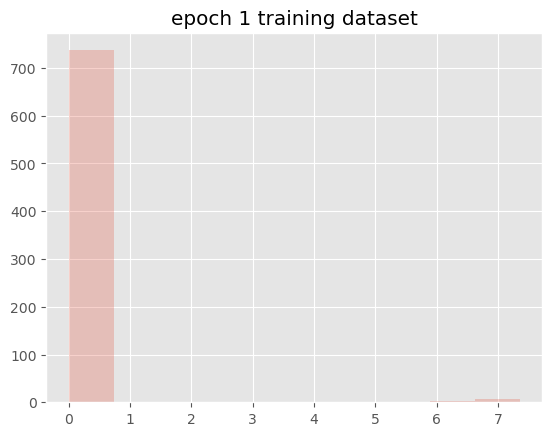

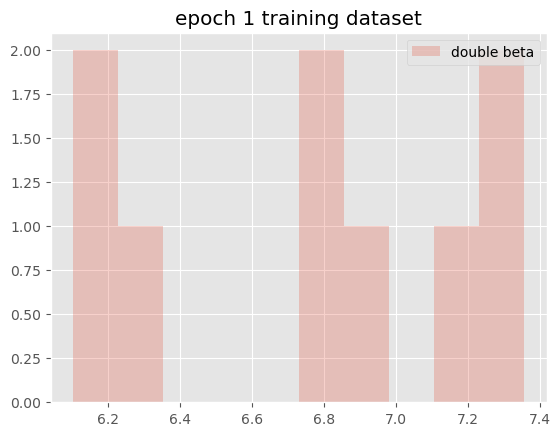

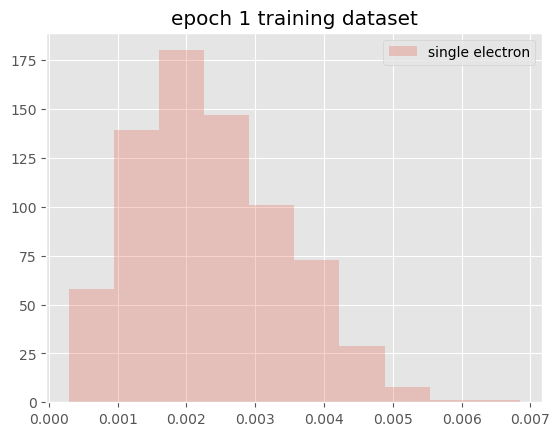

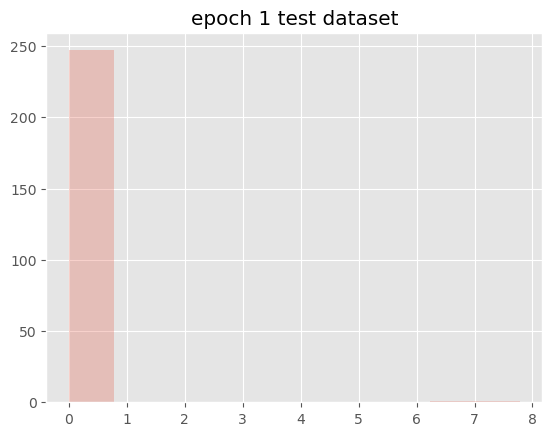

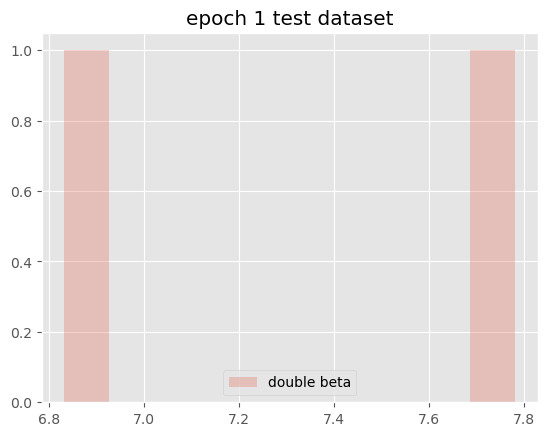

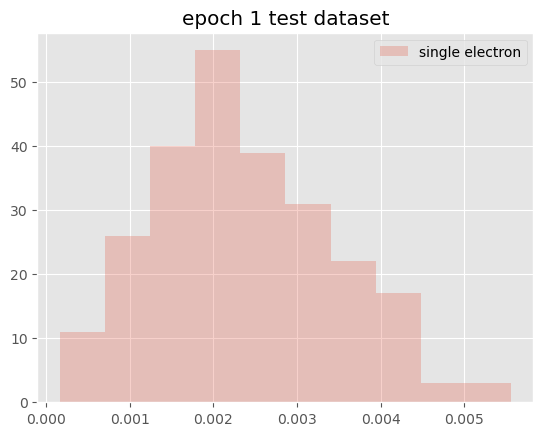

Epoch: 001, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 002, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 003, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 004, Train Acc: 0.9879, Test Acc: 0.9920


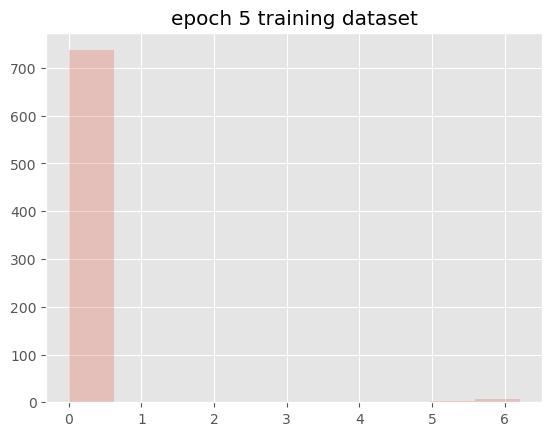

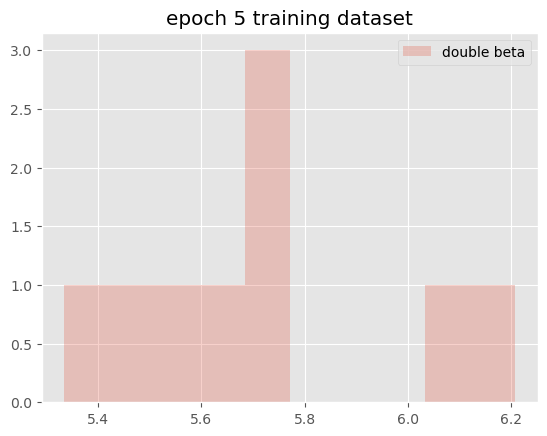

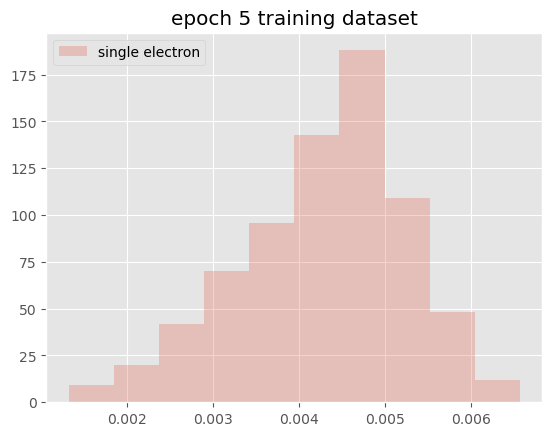

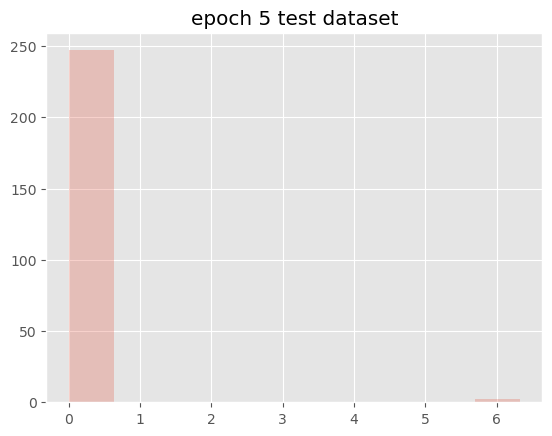

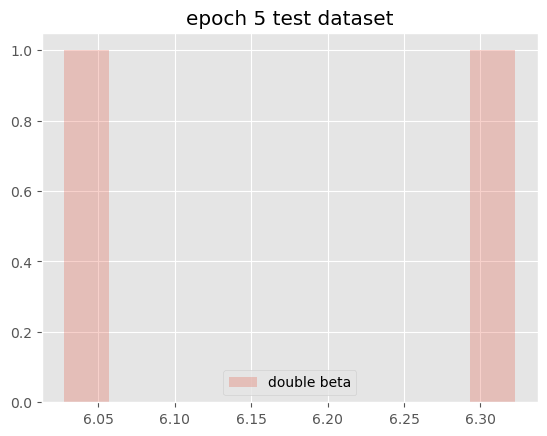

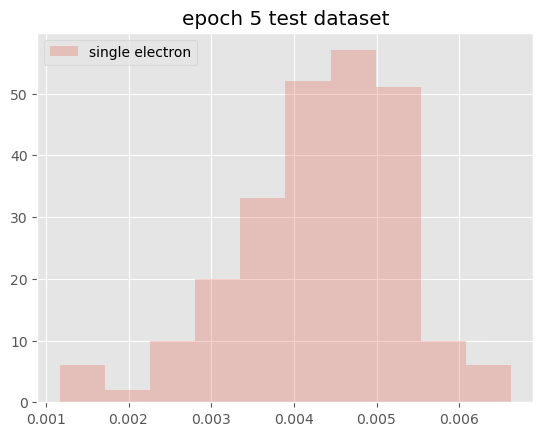

Epoch: 005, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 006, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 007, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 008, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 009, Train Acc: 0.9879, Test Acc: 0.9920


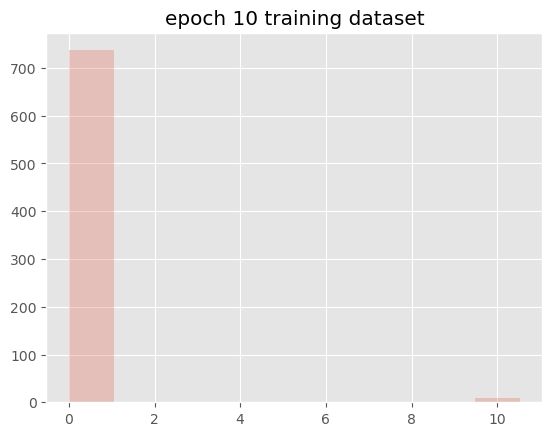

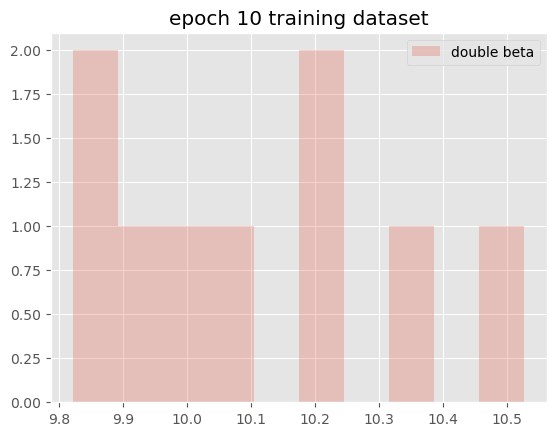

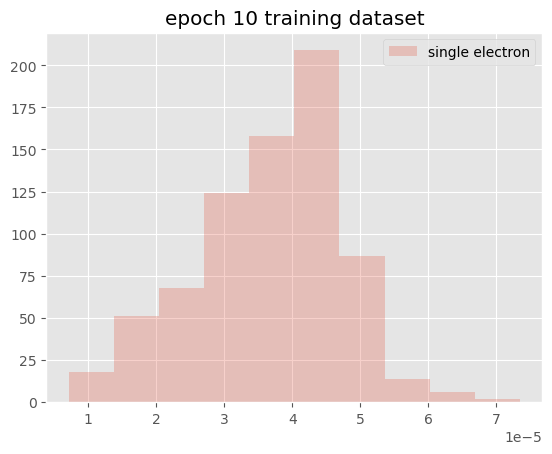

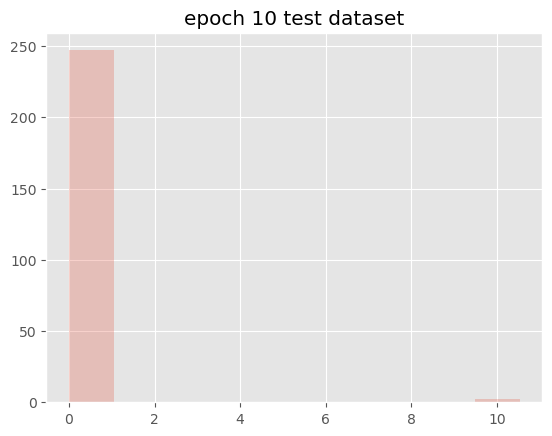

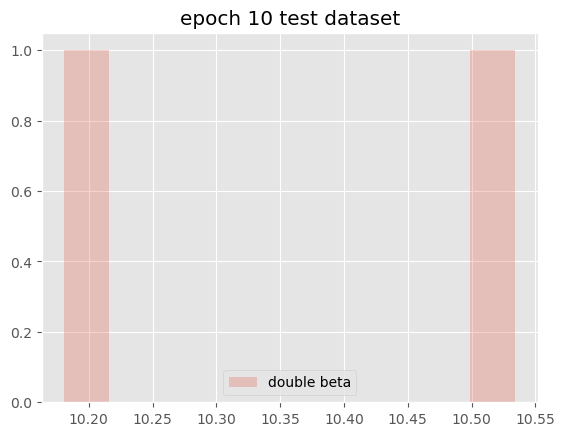

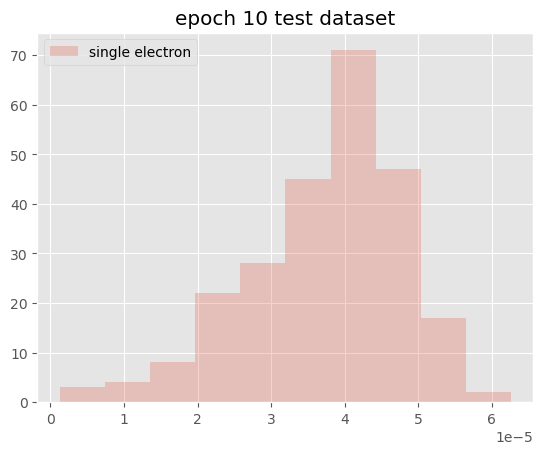

Epoch: 010, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 011, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 012, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 013, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 014, Train Acc: 0.9879, Test Acc: 0.9920


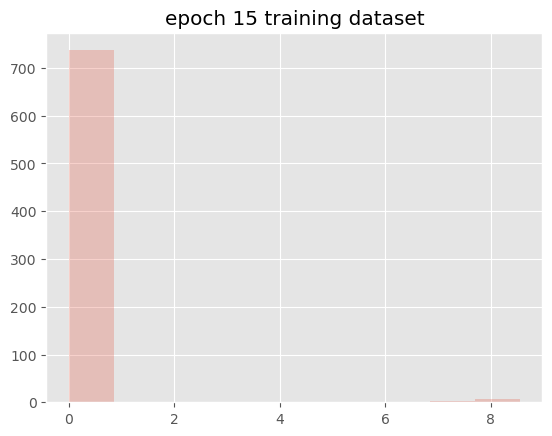

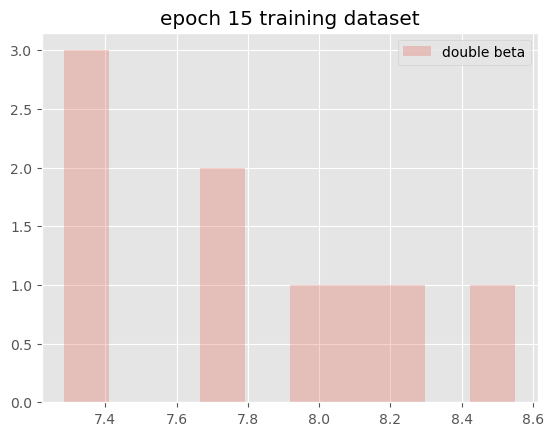

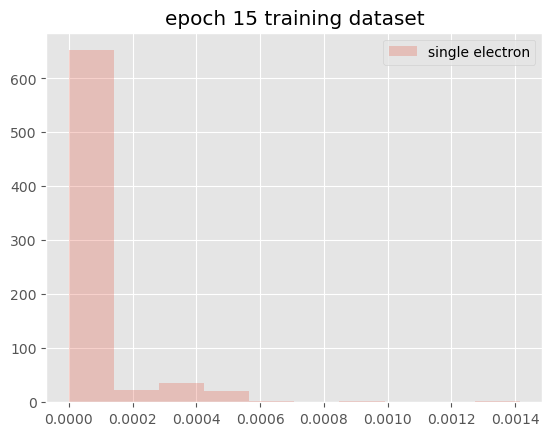

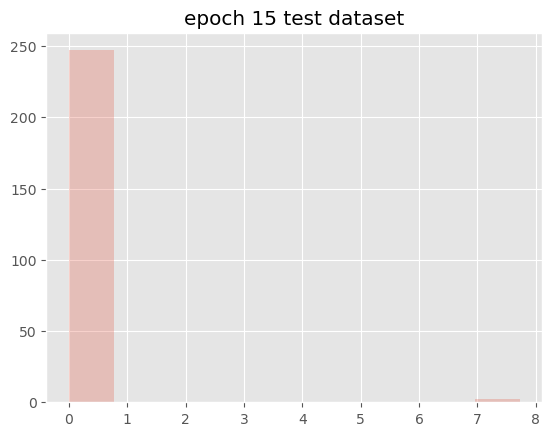

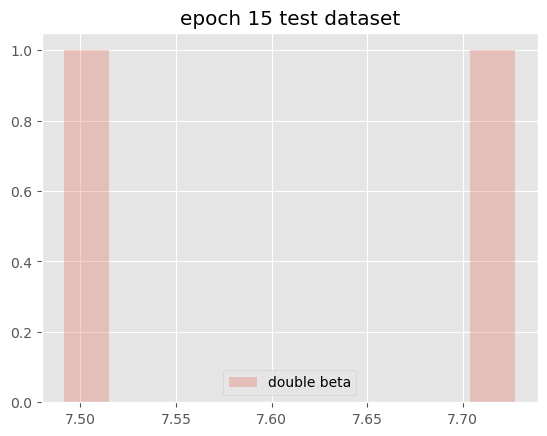

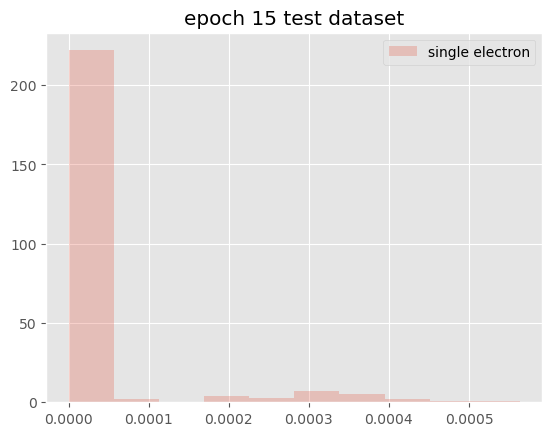

Epoch: 015, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 016, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 017, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 018, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 019, Train Acc: 0.9879, Test Acc: 0.9920


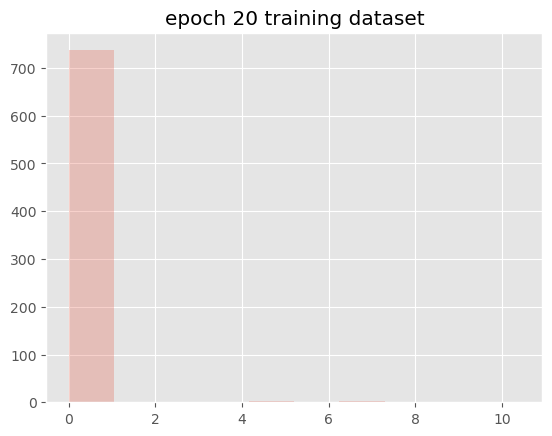

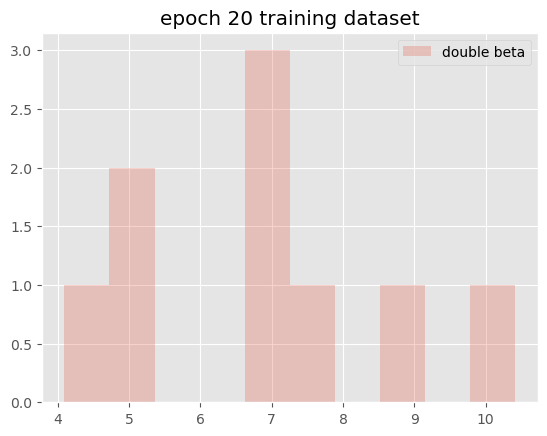

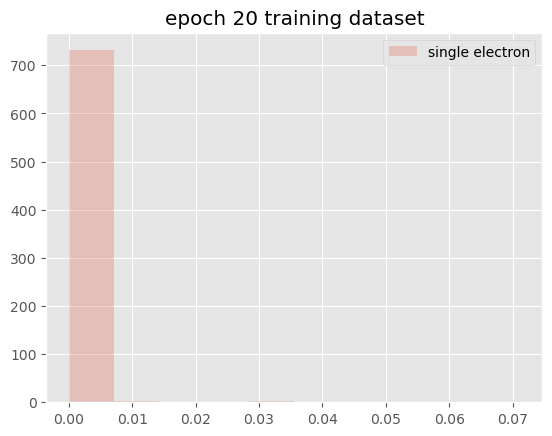

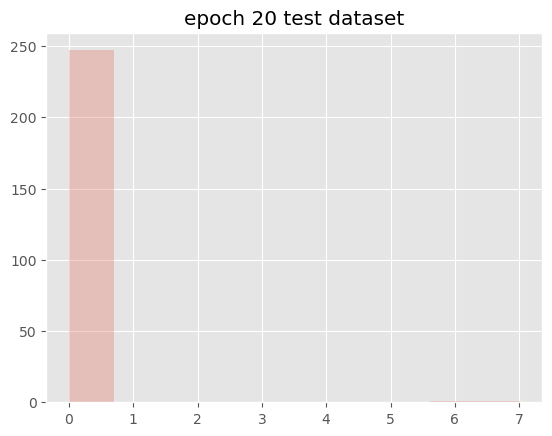

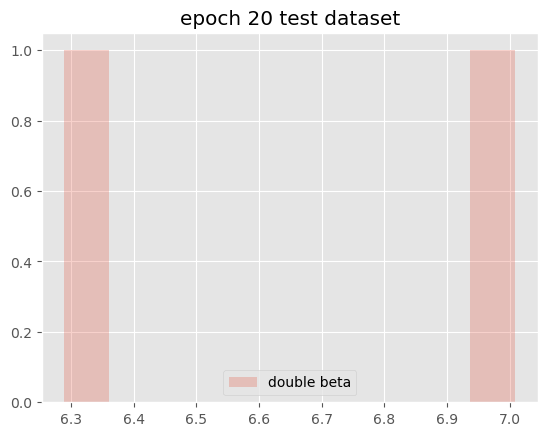

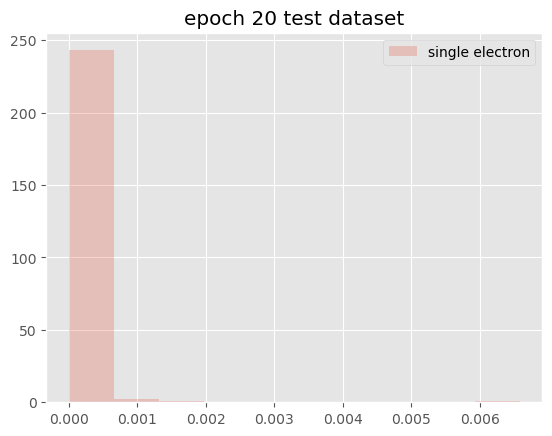

Epoch: 020, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 021, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 022, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 023, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 024, Train Acc: 0.9879, Test Acc: 0.9920


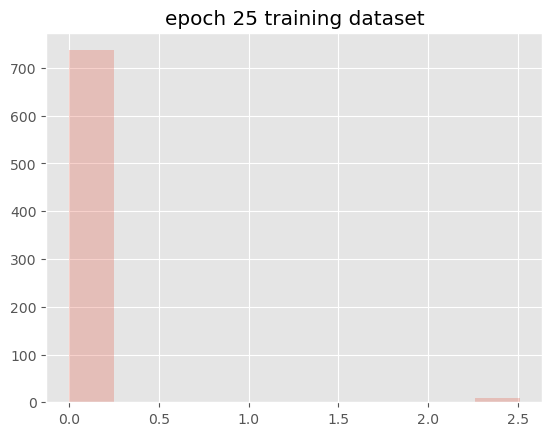

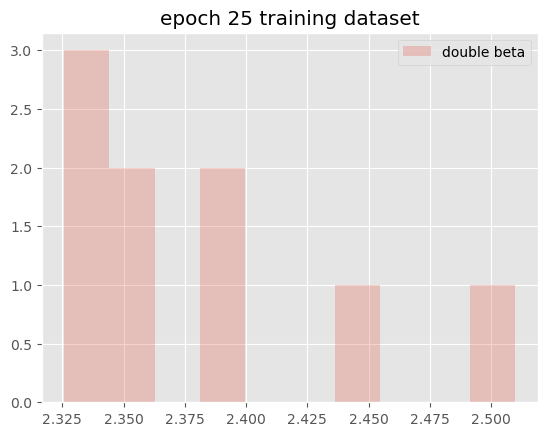

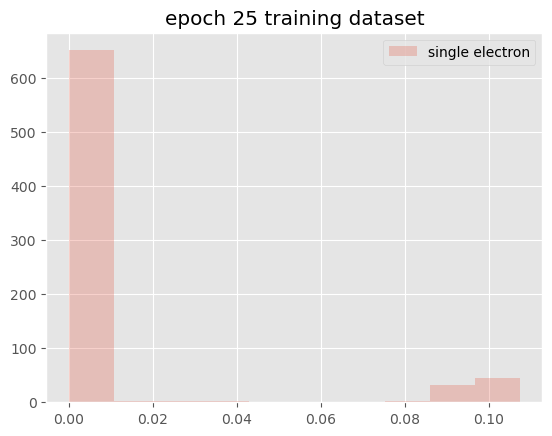

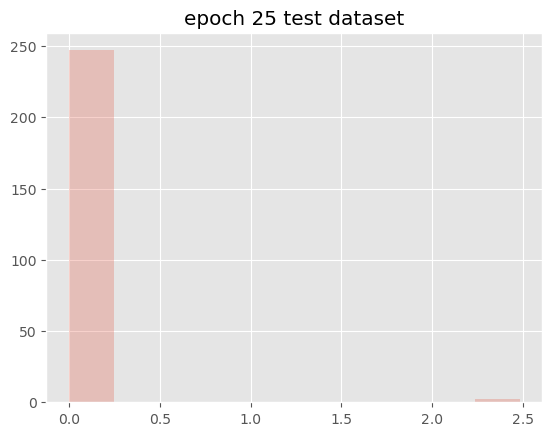

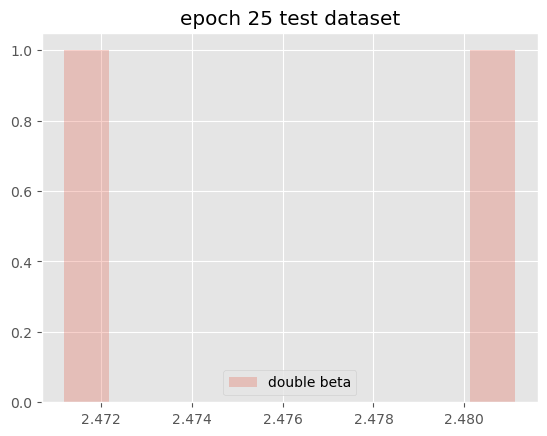

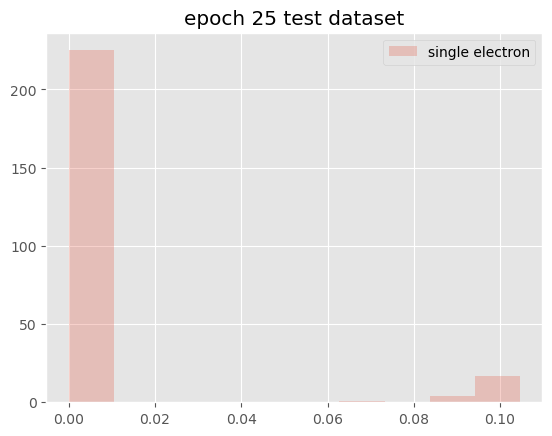

Epoch: 025, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 026, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 027, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 028, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 029, Train Acc: 0.9879, Test Acc: 0.9920


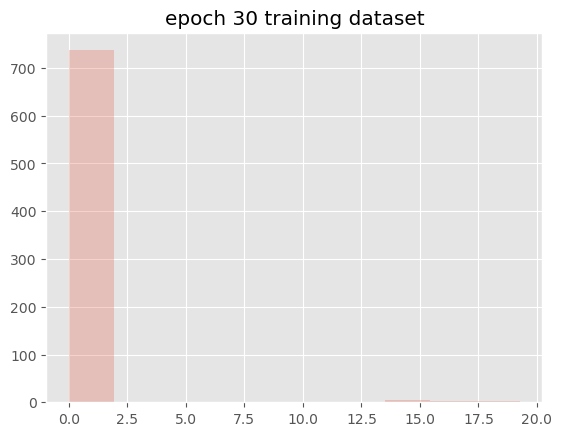

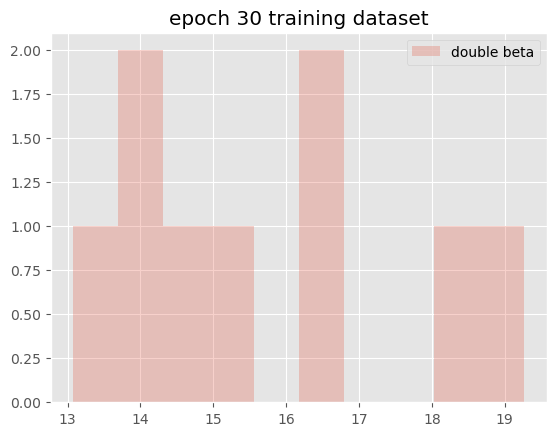

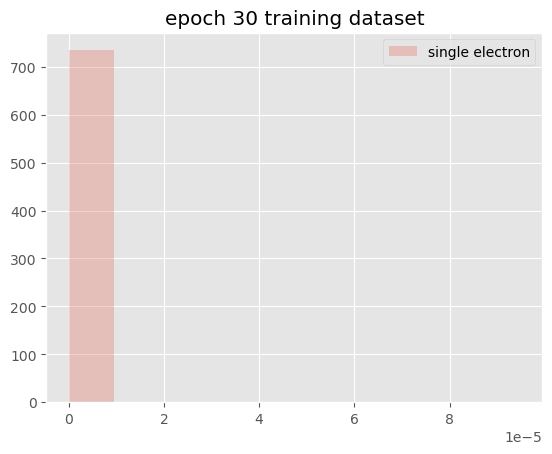

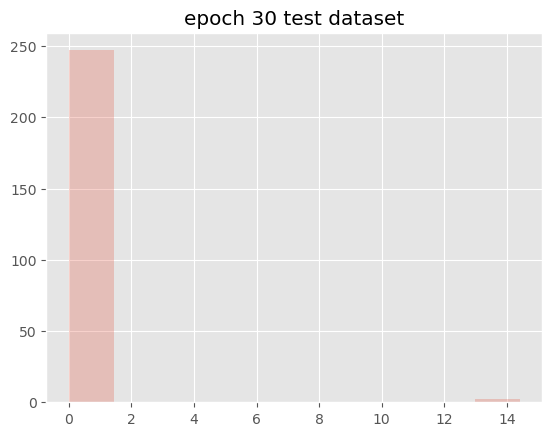

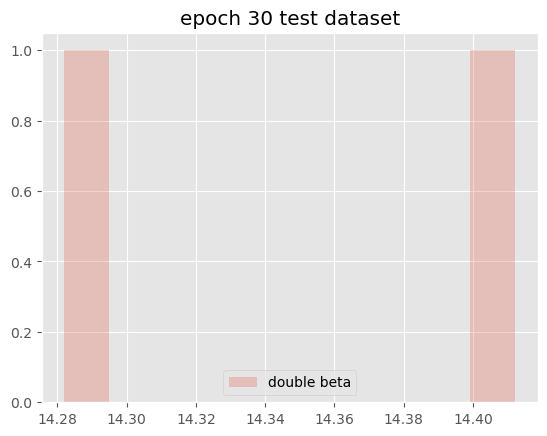

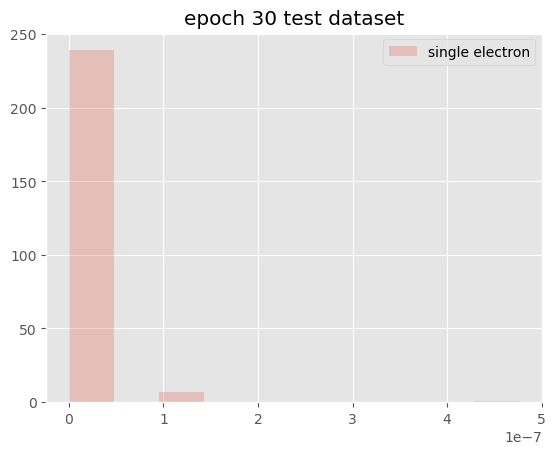

Epoch: 030, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 031, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 032, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 033, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 034, Train Acc: 0.9879, Test Acc: 0.9920


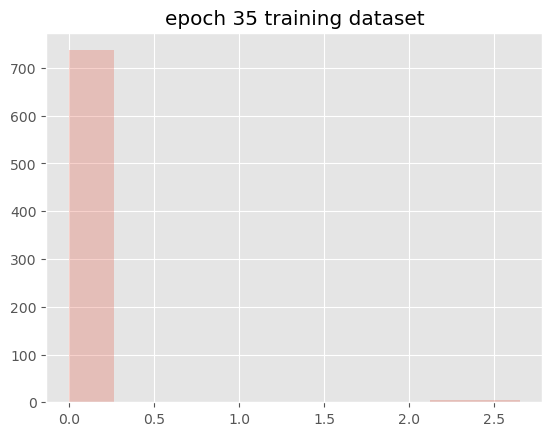

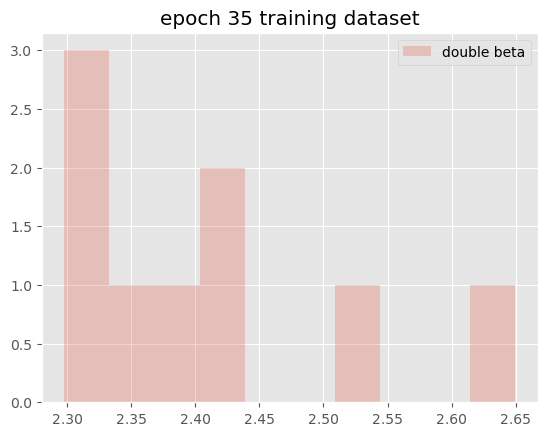

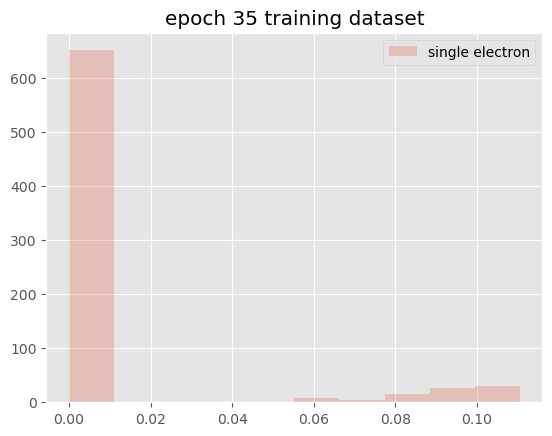

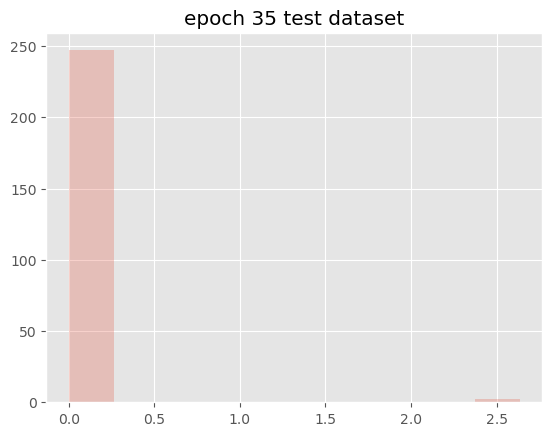

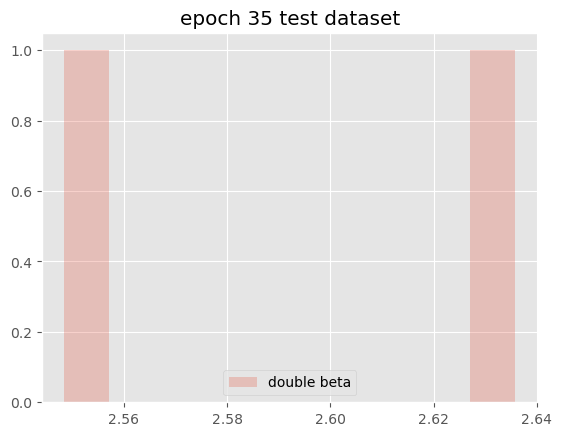

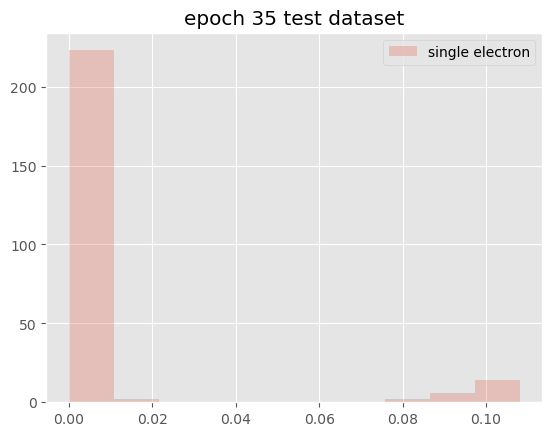

Epoch: 035, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 036, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 037, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 038, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 039, Train Acc: 0.9879, Test Acc: 0.9920


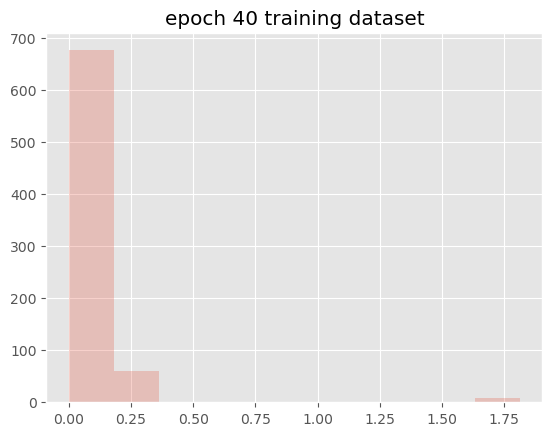

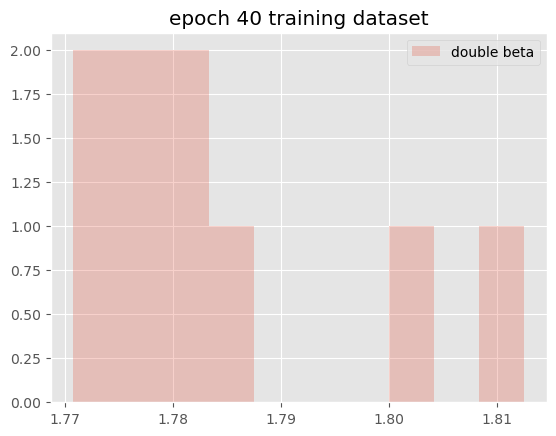

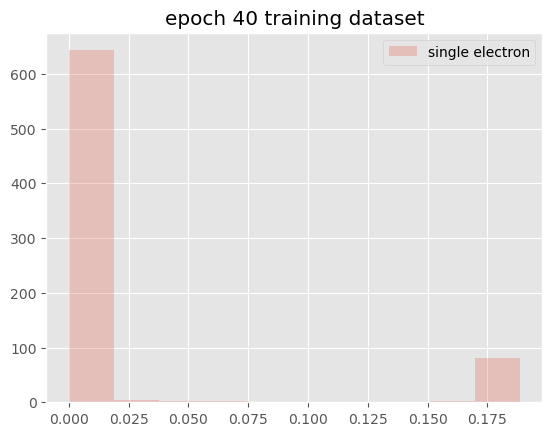

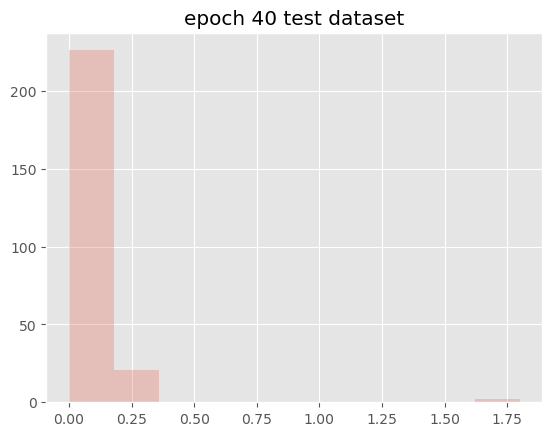

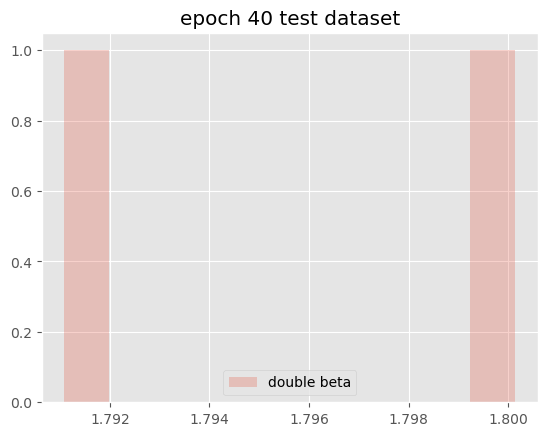

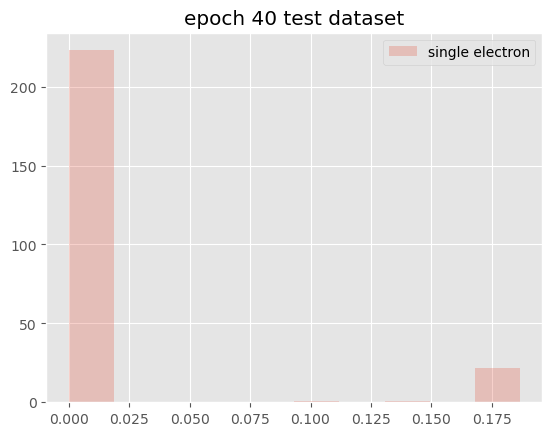

Epoch: 040, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 041, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 042, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 043, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 044, Train Acc: 0.9879, Test Acc: 0.9920


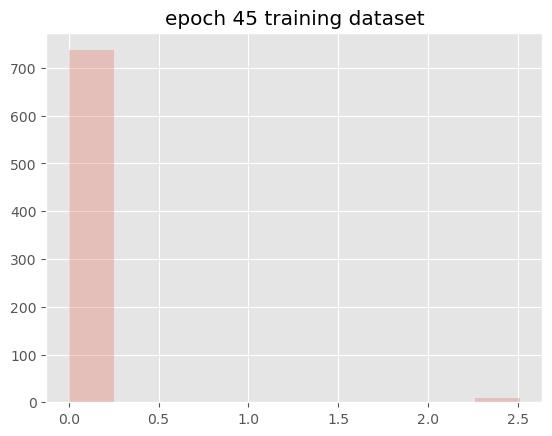

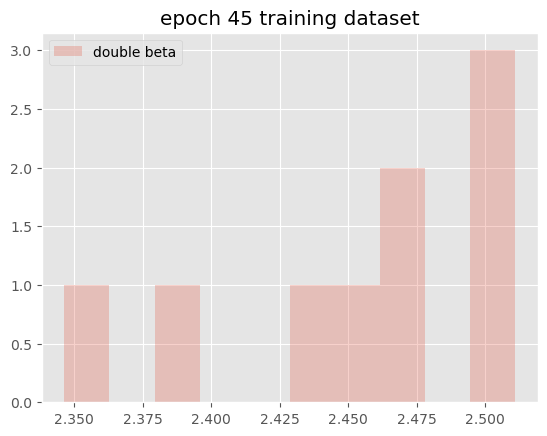

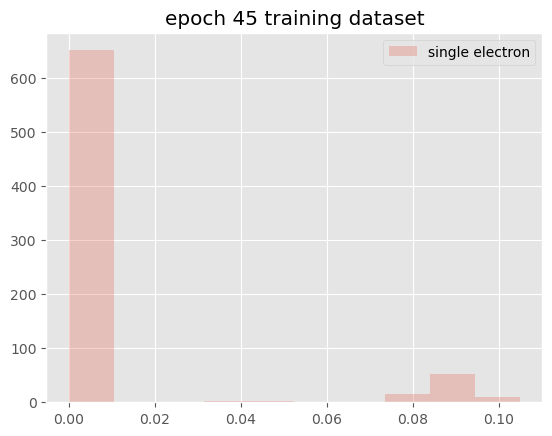

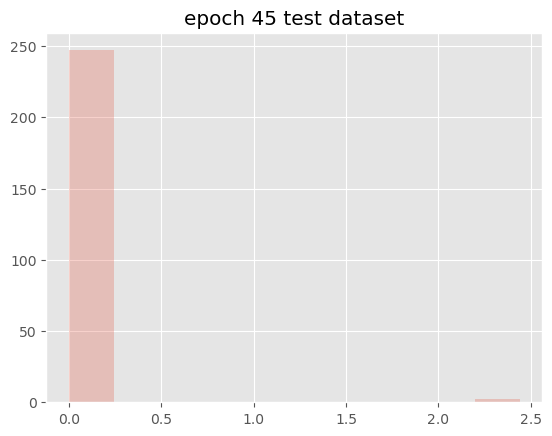

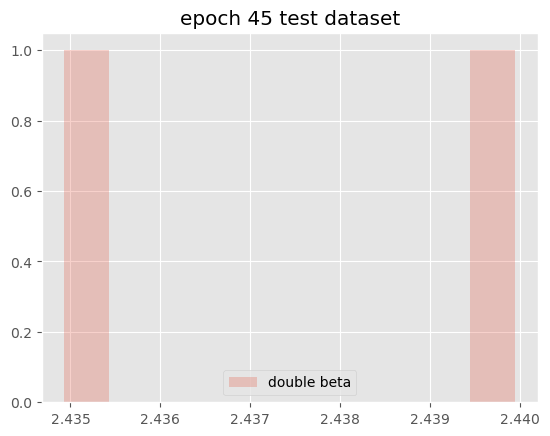

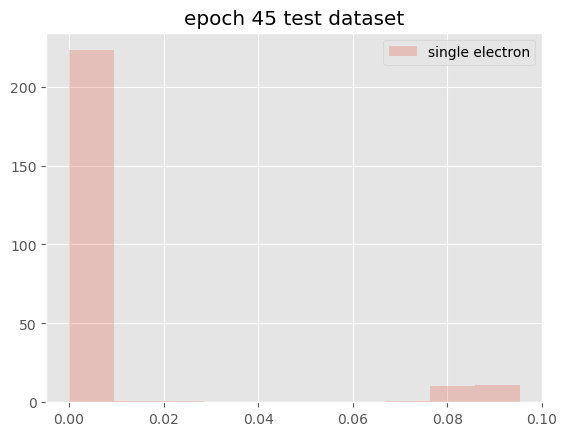

Epoch: 045, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 046, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 047, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 048, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 049, Train Acc: 0.9879, Test Acc: 0.9920


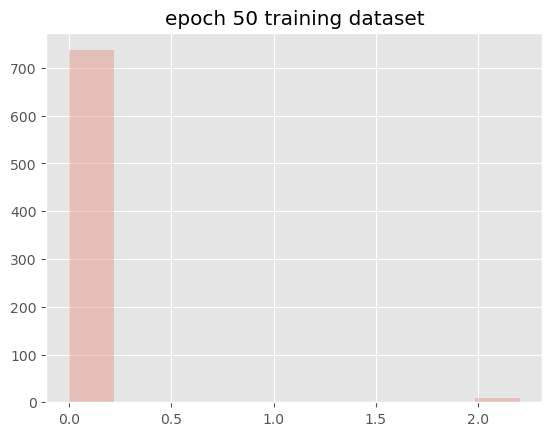

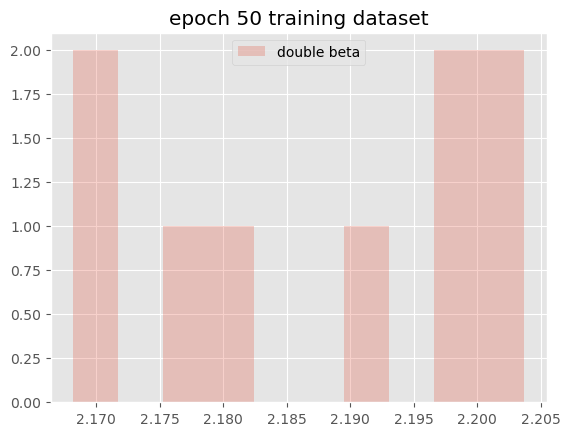

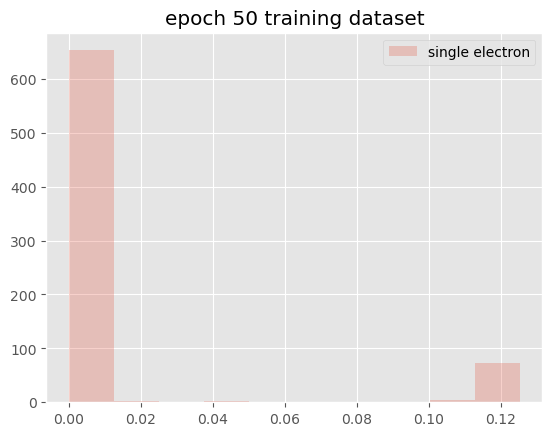

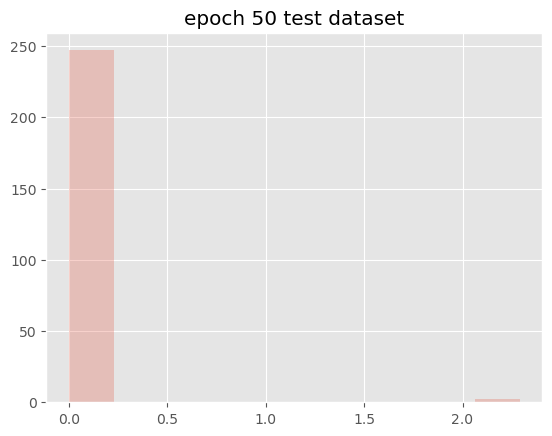

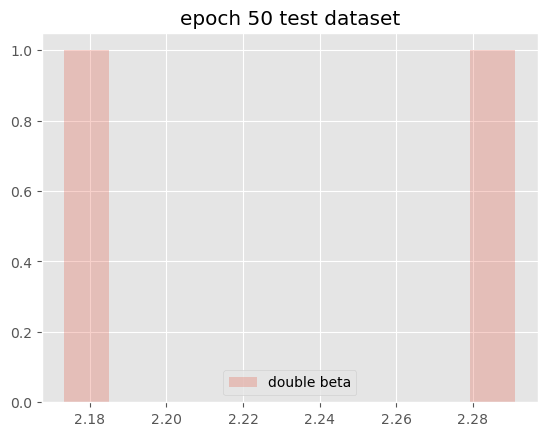

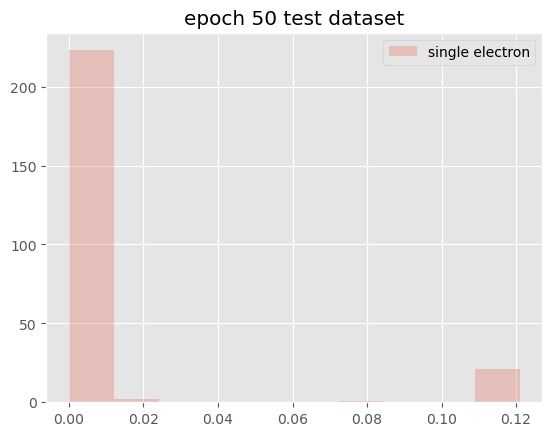

Epoch: 050, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 051, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 052, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 053, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 054, Train Acc: 0.9879, Test Acc: 0.9920


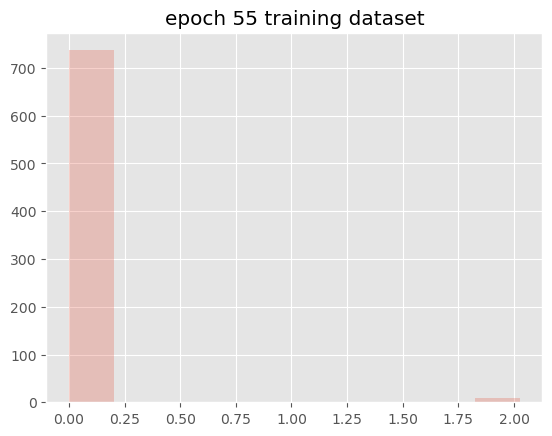

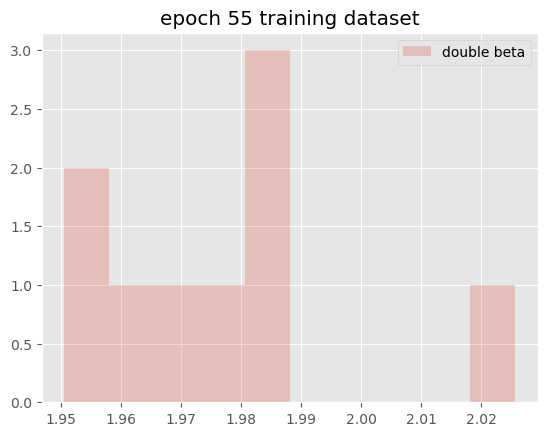

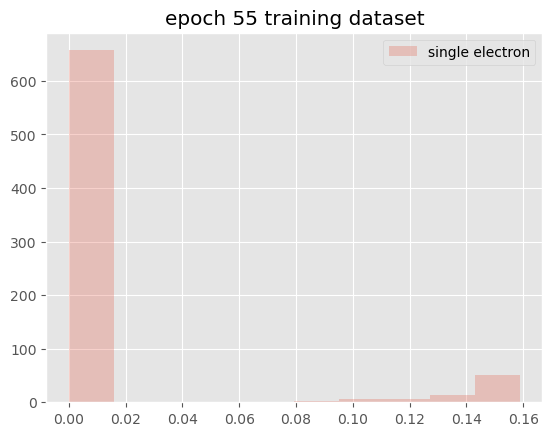

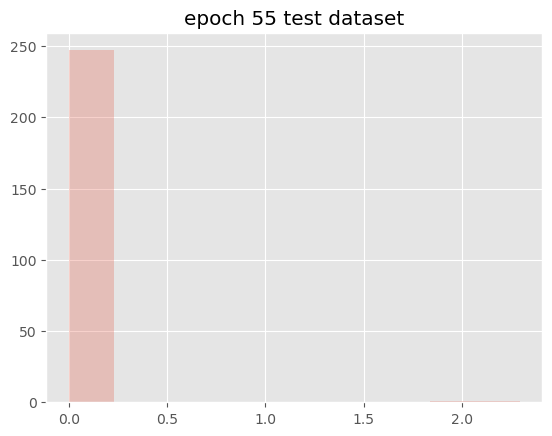

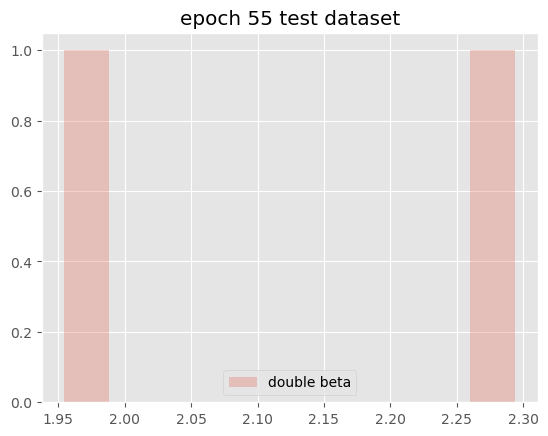

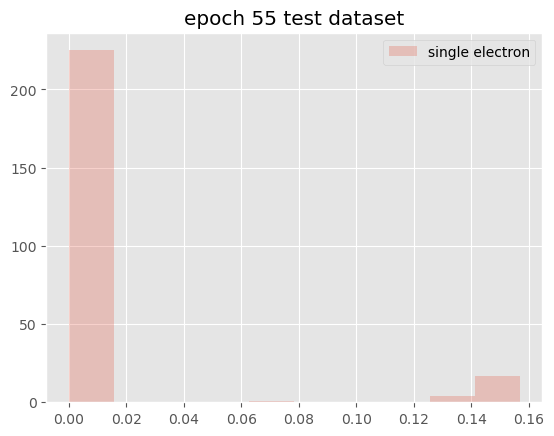

Epoch: 055, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 056, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 057, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 058, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 059, Train Acc: 0.9879, Test Acc: 0.9920


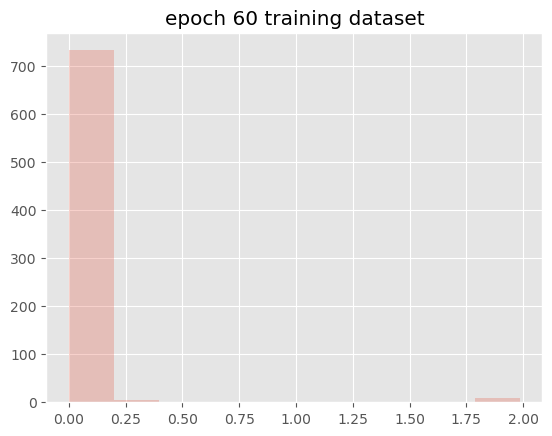

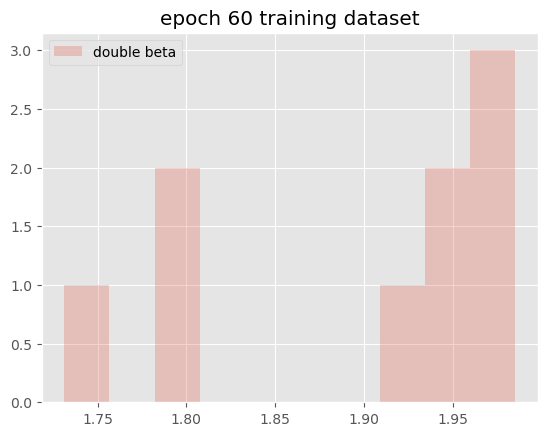

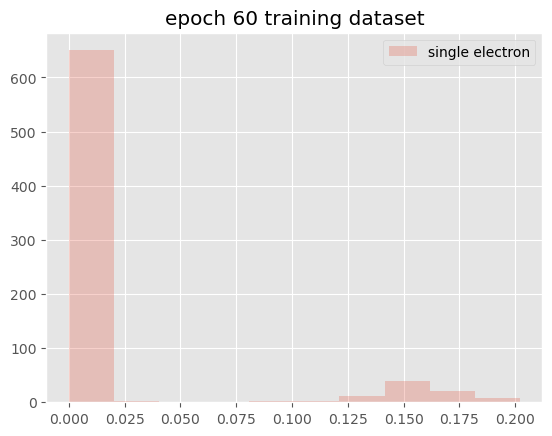

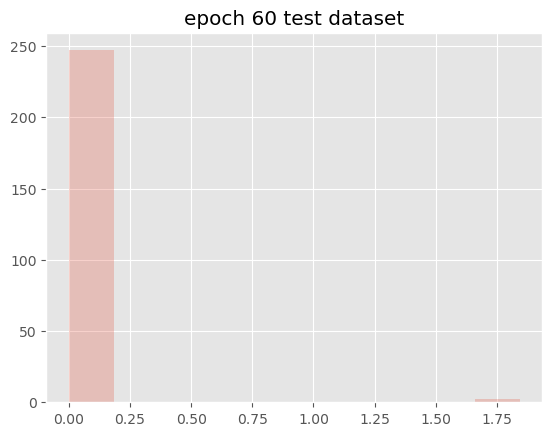

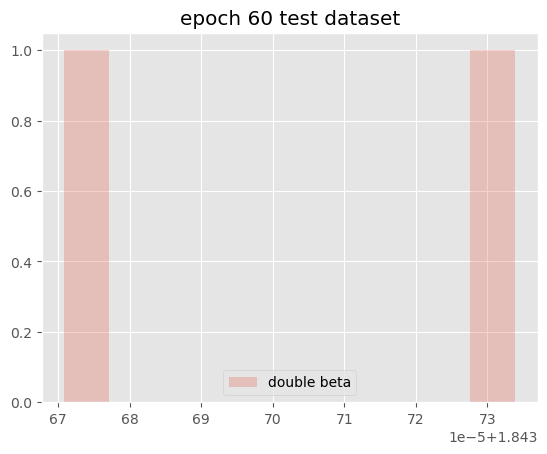

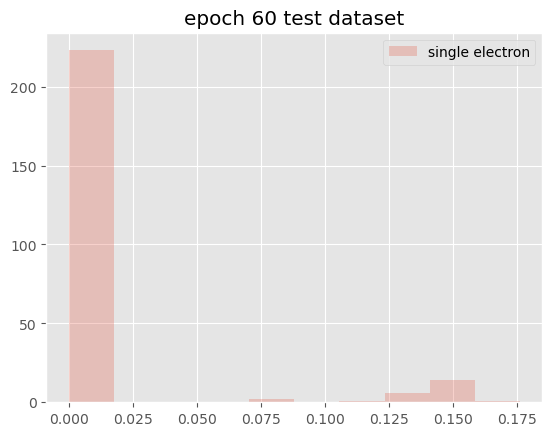

Epoch: 060, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 061, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 062, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 063, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 064, Train Acc: 0.9879, Test Acc: 0.9920


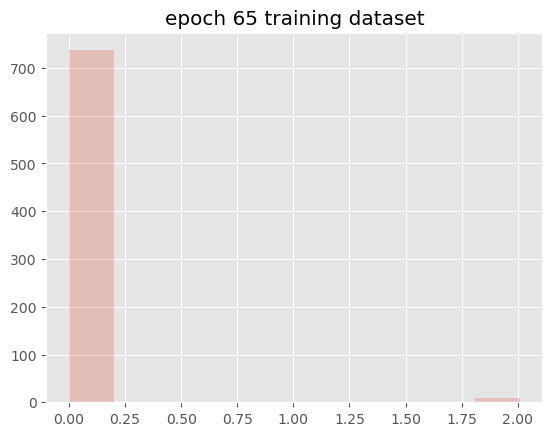

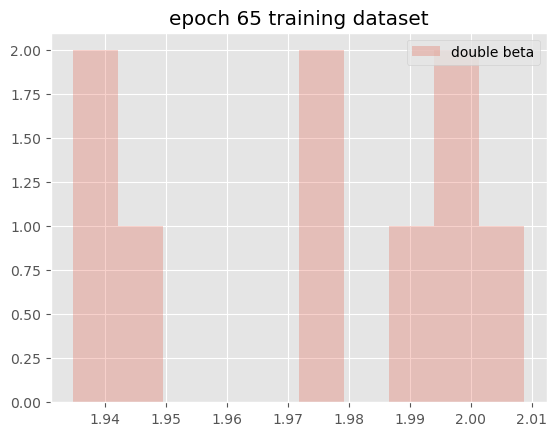

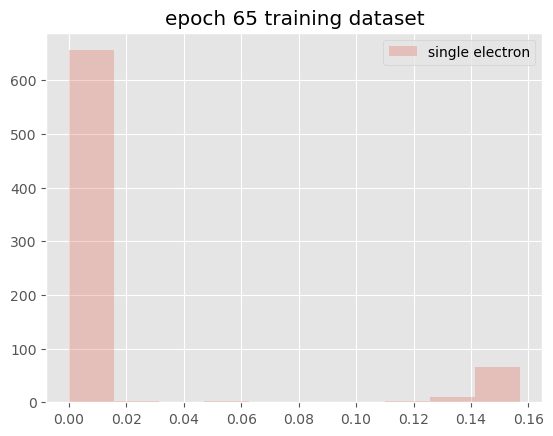

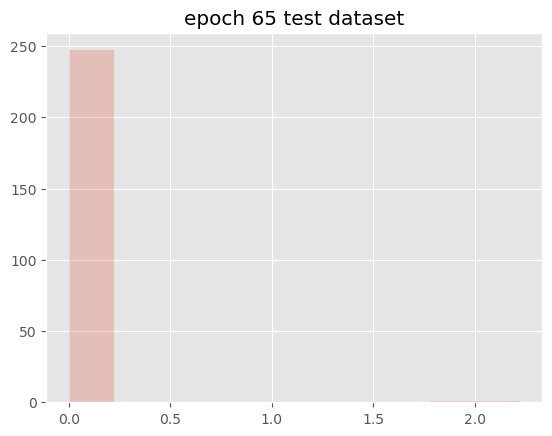

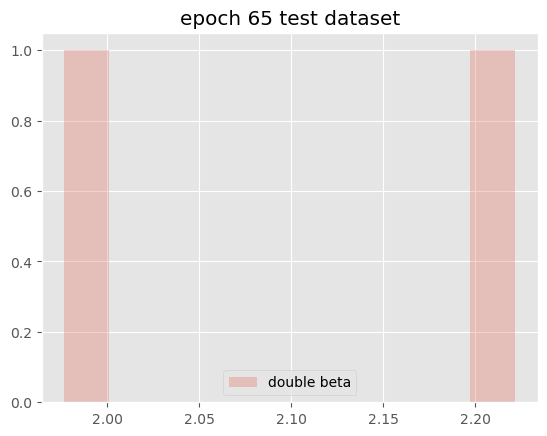

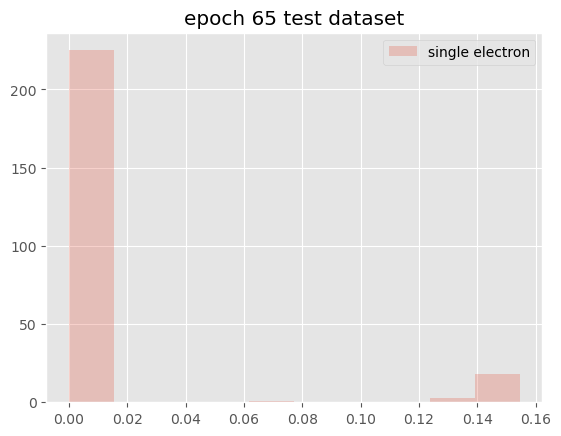

Epoch: 065, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 066, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 067, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 068, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 069, Train Acc: 0.9879, Test Acc: 0.9920


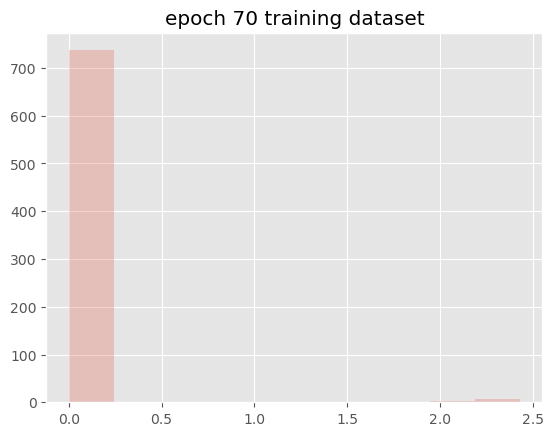

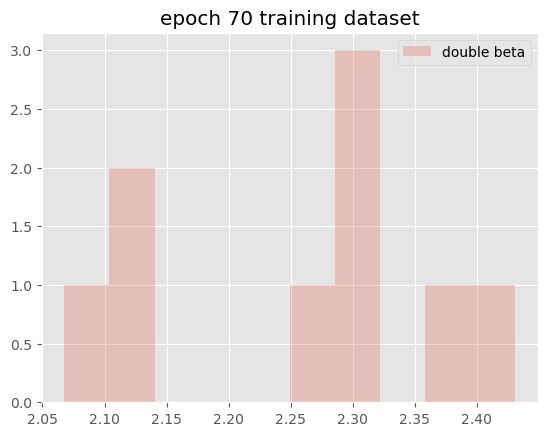

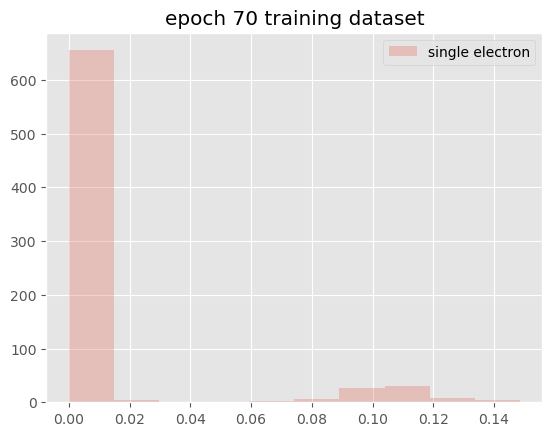

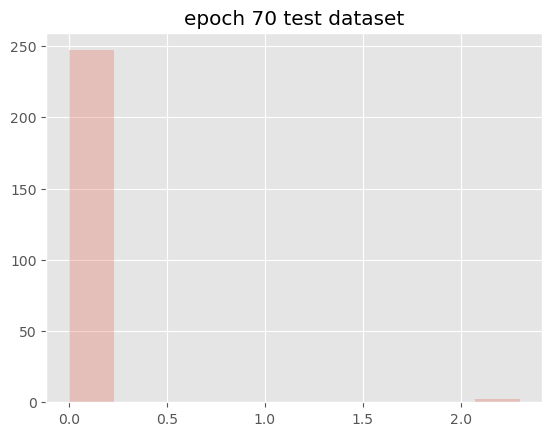

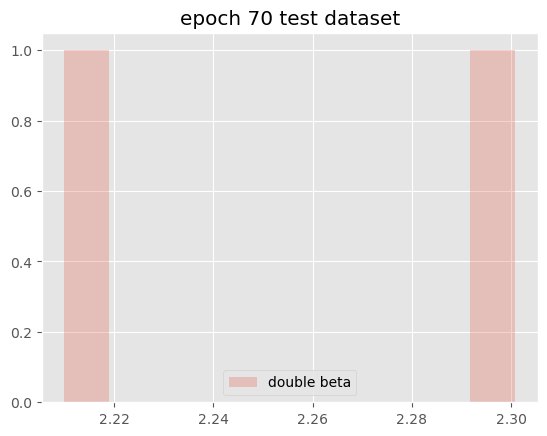

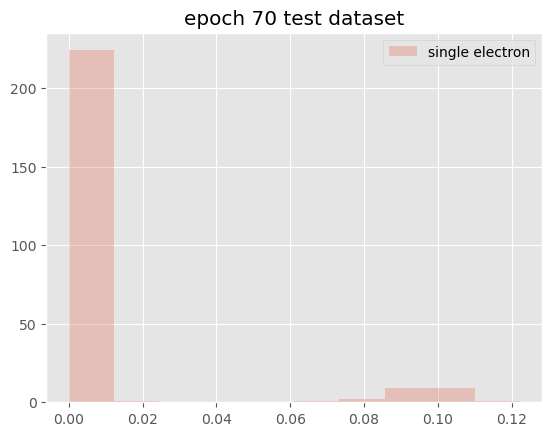

Epoch: 070, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 071, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 072, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 073, Train Acc: 0.9879, Test Acc: 0.9920
Epoch: 074, Train Acc: 0.9879, Test Acc: 0.9920


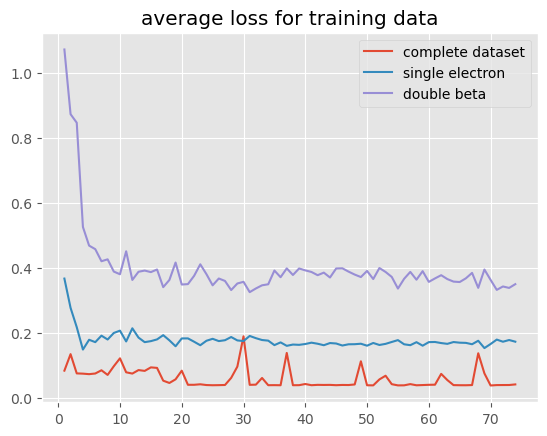

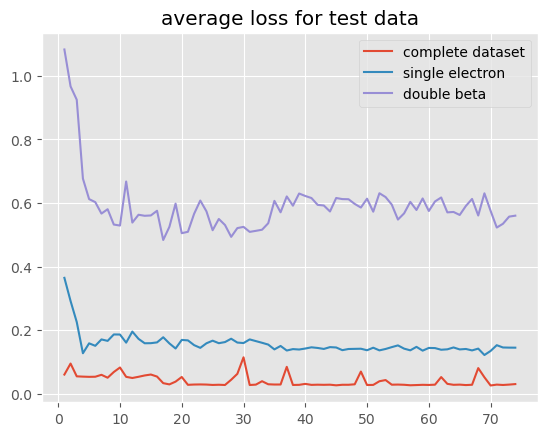

In [183]:
allGraphData = allGraphDataDf.sample(frac = 1,random_state=None) # shuffles data

allGraphData = allGraphData.to_numpy()
nbbSignalOnly = np.where(allGraphData[:,-1] == allGraphData[:,-3] )[0]
allGraphData = allGraphData[nbbSignalOnly]

endTrainData = int(np.floor(3/4*len(allGraphData)))
train_dataset = allGraphData[0:endTrainData,:]
test_dataset = allGraphData[endTrainData:,:]
if energySignalEnalbed:
    train_loader = DataLoader(train_dataset[:,-2] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-2] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-3]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-3]
else:
    train_loader = DataLoader(train_dataset[:,-1] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-1] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-2]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-2]
model = GAT(hidden_channels=64, num_classes=2, num_node_features = 4)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
criterion = torch.nn.CrossEntropyLoss()

plt.style.use("ggplot")

avgLossTrainList = []
avgLossTestList = []

avgLossNbbTestList = []
avgLossSeTestList = []

avgLossNbbTrainList = []
avgLossSeTrainList = []

nbbTrain = np.where(train_dataset[:,-3]==1)[0] #nutrinoless double beta decay
seTrain = np.where(train_dataset[:,-3]==0)[0]#single electron
nbbTest = np.where(test_dataset[:,-3]==1)[0] #nutrinoless double beta decay
seTest = np.where(test_dataset[:,-3]==0)[0]#single electron
for epoch in range(1, 75):
    train()


    train_acc,train_signal_acc,train_background_acc,lossTrainList = test(train_loader,isSignalArrayTraining)
    lossTrainList = np.array(lossTrainList)

    test_acc,test_signal_acc,test_background_acc,lossTestList = test(test_loader,isSignalArrayTesting)
    lossTestList = np.array(lossTestList)
    
    avgLossTrainList += [np.mean(lossTrainList)]
    avgLossTestList += [np.mean(lossTestList)]
    
    avgLossNbbTestList += [np.mean(lossTestList[nbbTest])]
    avgLossSeTestList += [np.mean(lossTestList[seTest])]

    avgLossNbbTrainList += [np.mean(lossTrainList[nbbTrain])]
    avgLossSeTrainList += [np.mean(lossTrainList[seTrain])]
    
    if epoch%5 == 0 or epoch==1:
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList,alpha=0.25)
        plt.show()
        
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList[nbbTrain],alpha=0.25,label="double beta")
        plt.legend()
        plt.show()
        
        plt.title("epoch {} training dataset".format(epoch))
        plt.hist(lossTrainList[seTrain],alpha=0.25,label="single electron")
        plt.legend()
        plt.show()
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList,alpha=0.25)
        plt.show()
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList[nbbTest],alpha=0.25,label="double beta")
        plt.legend()
        plt.show()
        
        plt.title("epoch {} test dataset".format(epoch))
        plt.hist(lossTestList[seTest],alpha=0.25,label="single electron")
        plt.legend()
        plt.show()
    
    print(f'''Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}''')
plt.title("average loss for training data")
plt.plot(list(range(1,epoch+1)), avgLossTrainList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTrainList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTrainList,label="double beta")
plt.legend()
plt.show()

plt.title("average loss for test data")
plt.plot(list(range(1,epoch+1)), avgLossTestList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTestList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTestList,label="double beta")
plt.legend()
plt.show()

In [53]:
energySignalEnalbed = True
fileNames,graphClass = setGraphs(data_path)
allGraphDataDf = createGraphData(fileNames
                                 ,graphClass
                                 ,distanceMetric = 'euclidean'
                                 ,energySignalEnalbed=energySignalEnalbed
                                 ,energyCut=0 # setting this to 0.0 will include all of the dataset
                                 ,distanceCutoff = 0.1
                                )

double_beta
single_electron
it's a zero!
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal
it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

it's a signal
it's a signal
it's a signal


C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLinkDist) \
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:256: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allData = allData.append({'GraphFileNames':name, 'nodes':nodes, 'nodeFeatures':x
C:\Users\Josh\AppData\Local\Temp\ipykernel_24476\3580756804.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  , np.array(avgLink

In [17]:
allGraphData = allGraphDataDf.sample(frac = 1,random_state=None) # shuffles data

allGraphData = allGraphData.to_numpy()
nbbSignalOnly = np.where(allGraphData[:,-1] == allGraphData[:,-3] )[0]

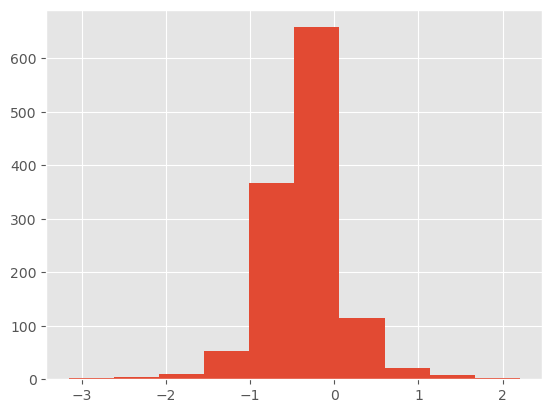

0
0
Epoch: 001, Train Acc: 0.6019, Test Acc: 0.5725
0
0
Epoch: 002, Train Acc: 0.6019, Test Acc: 0.5725


KeyboardInterrupt: 

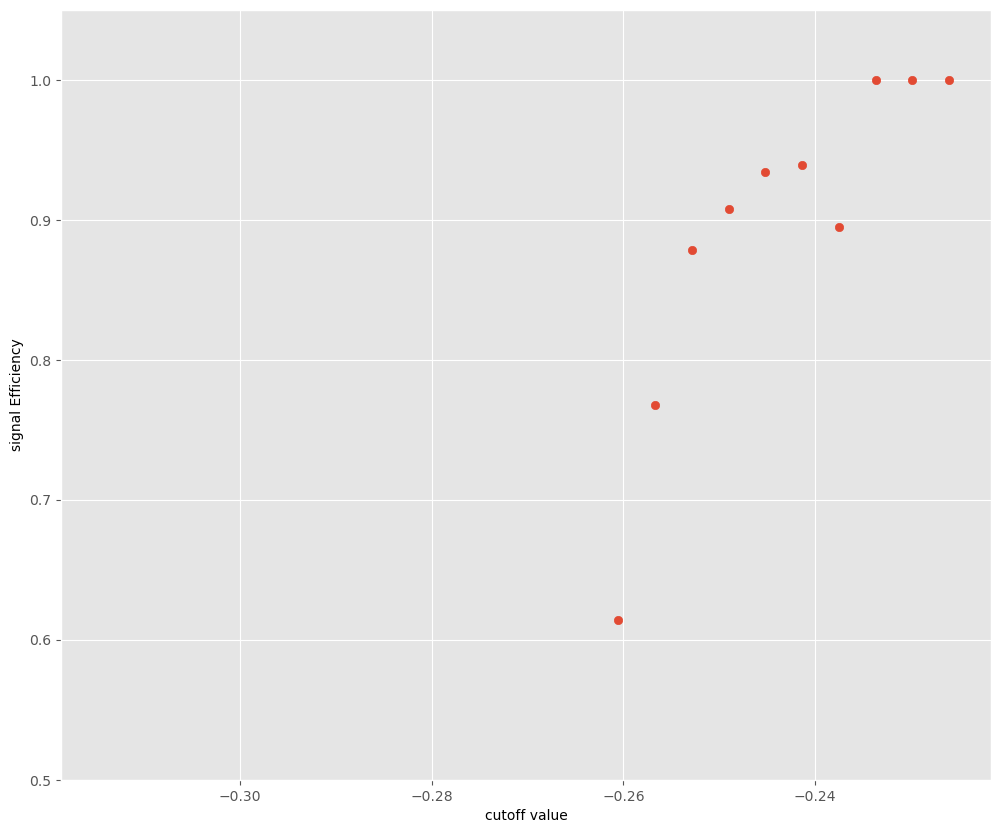

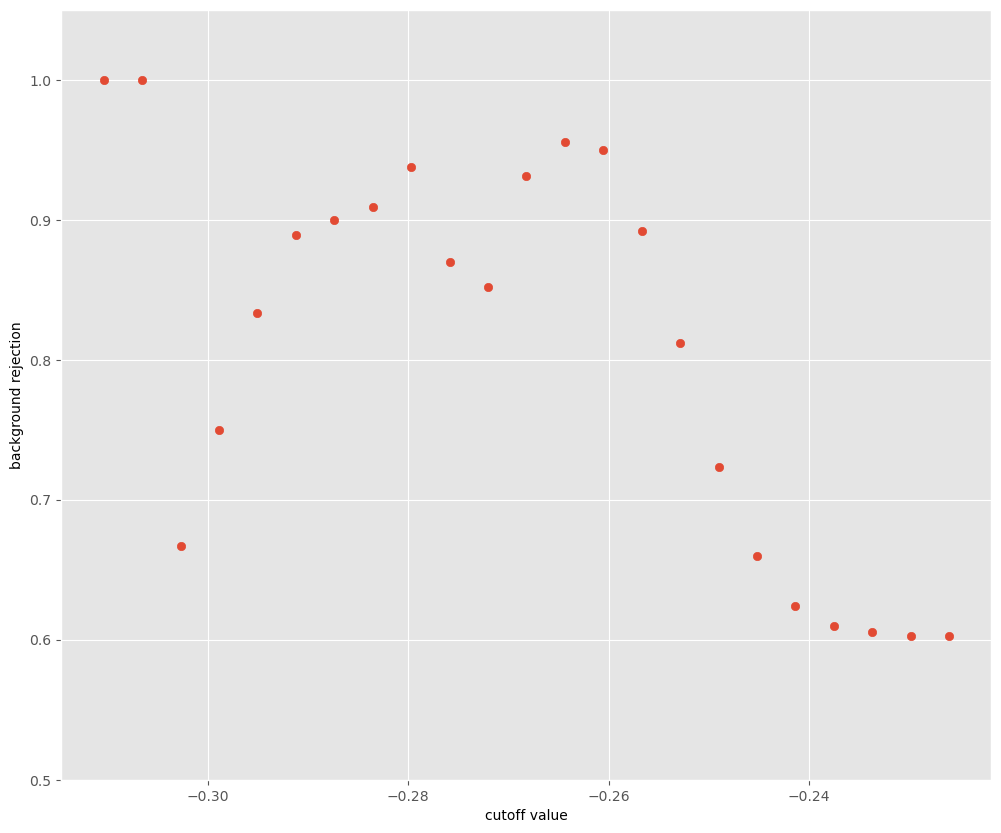

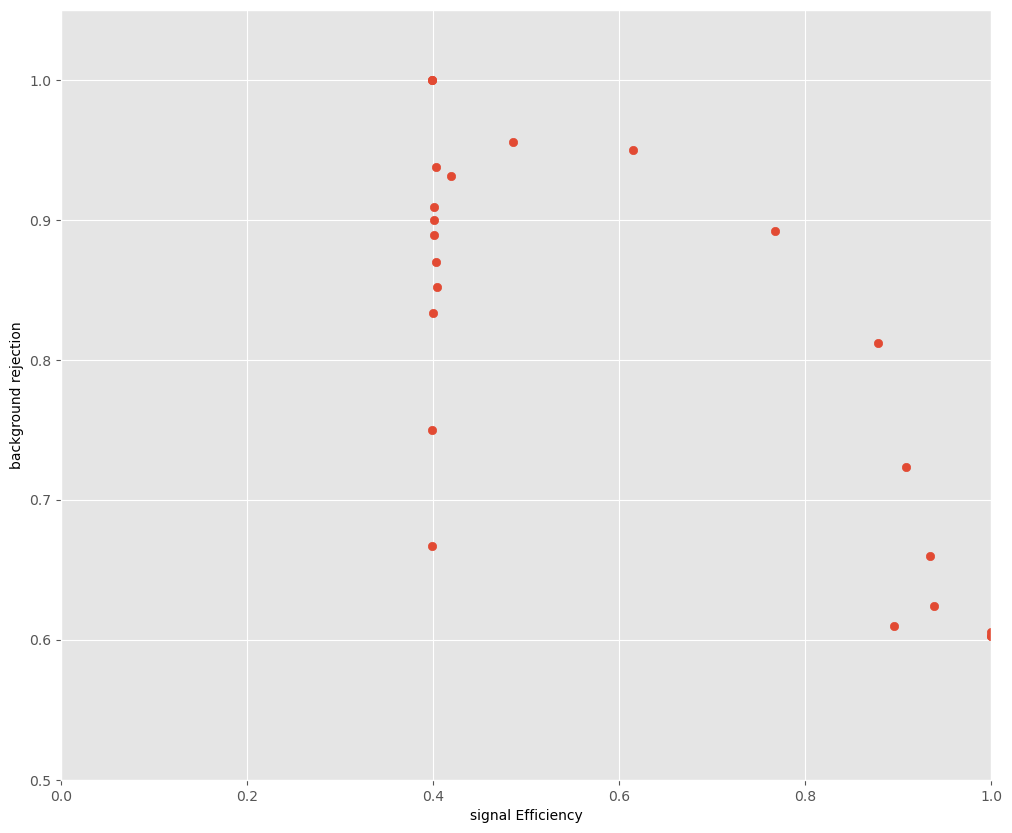

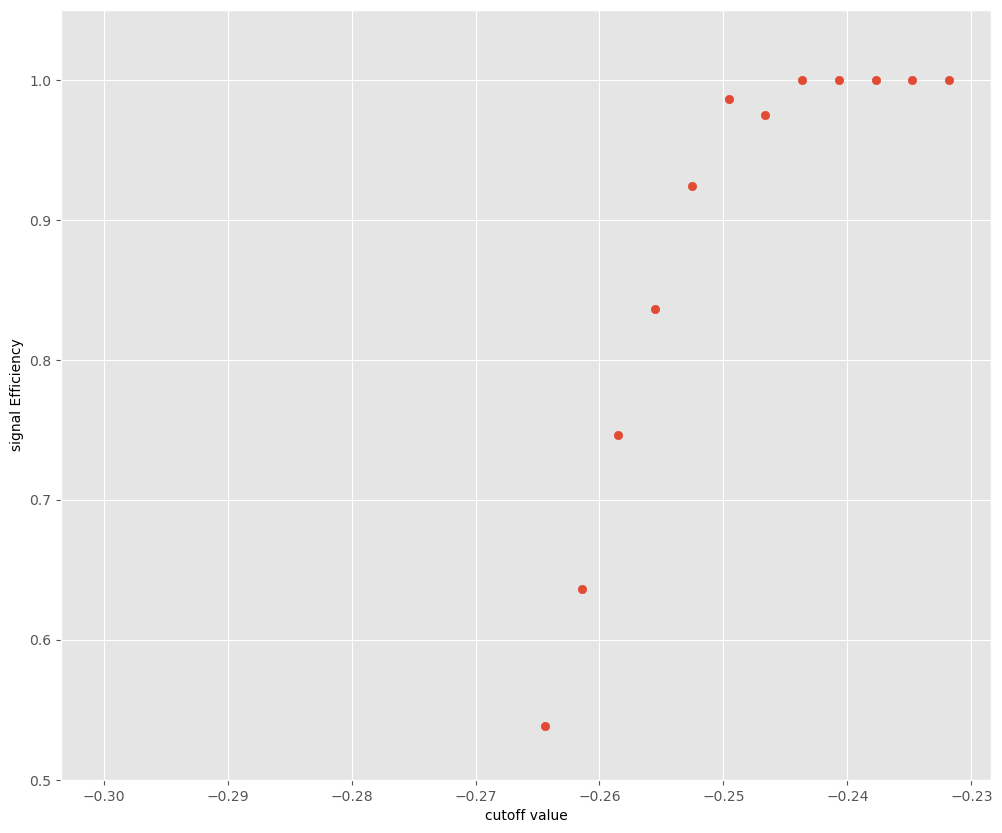

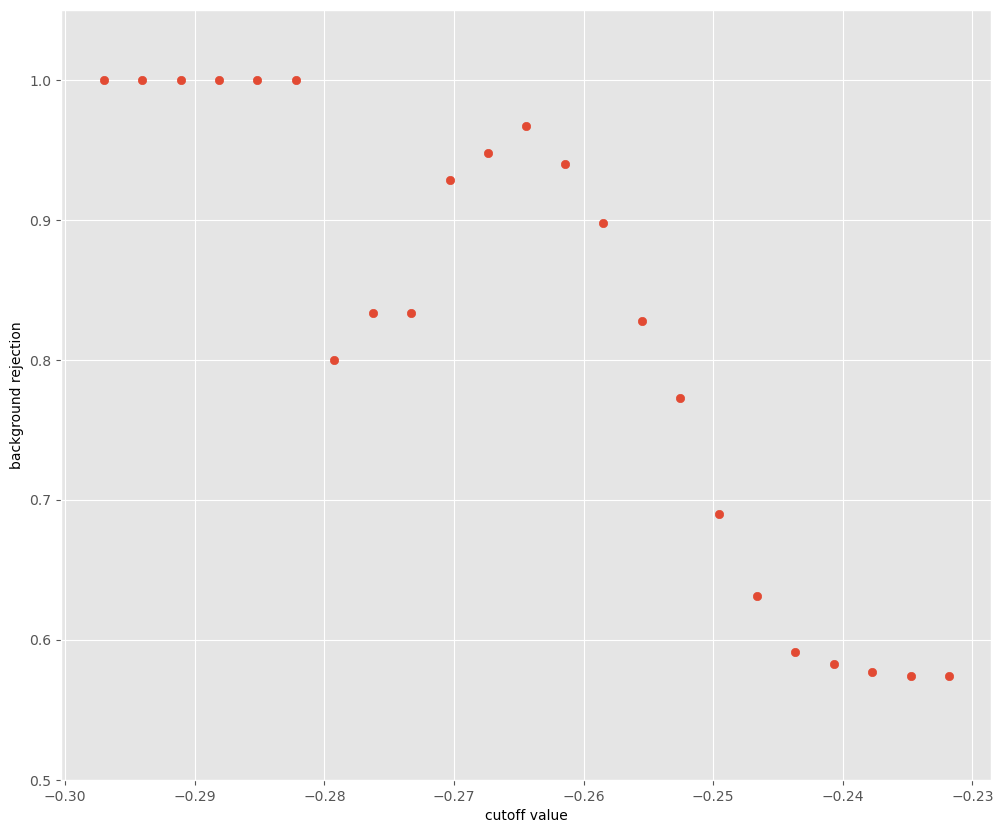

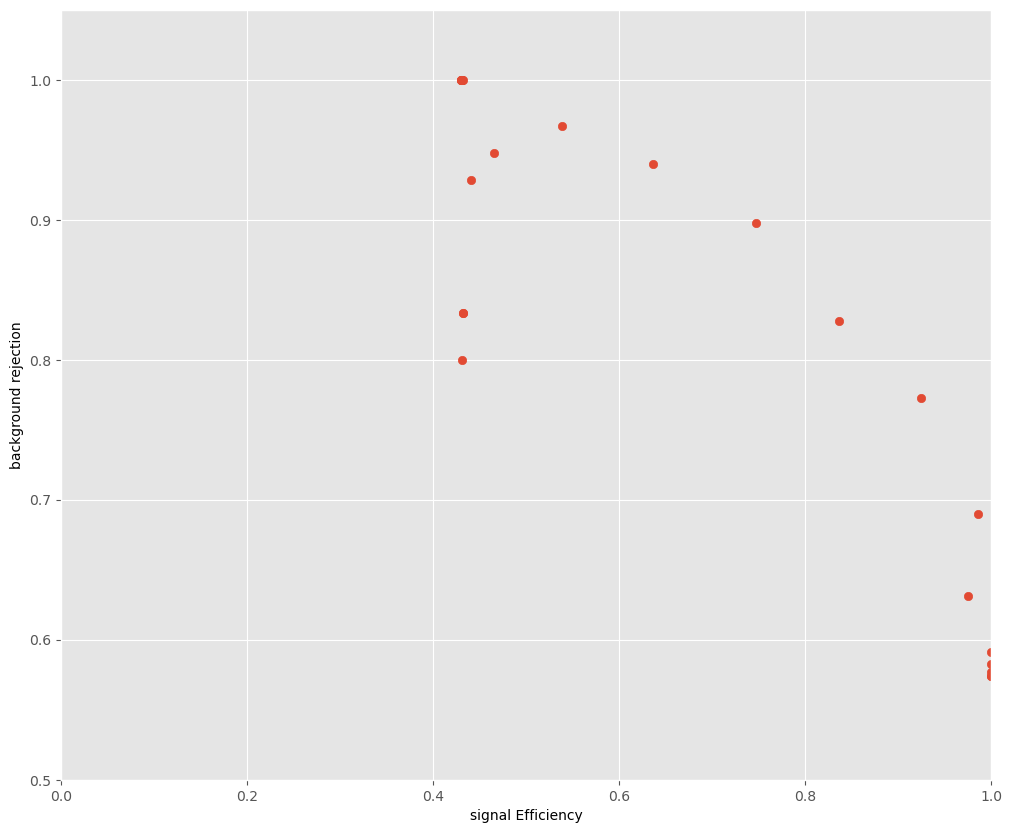

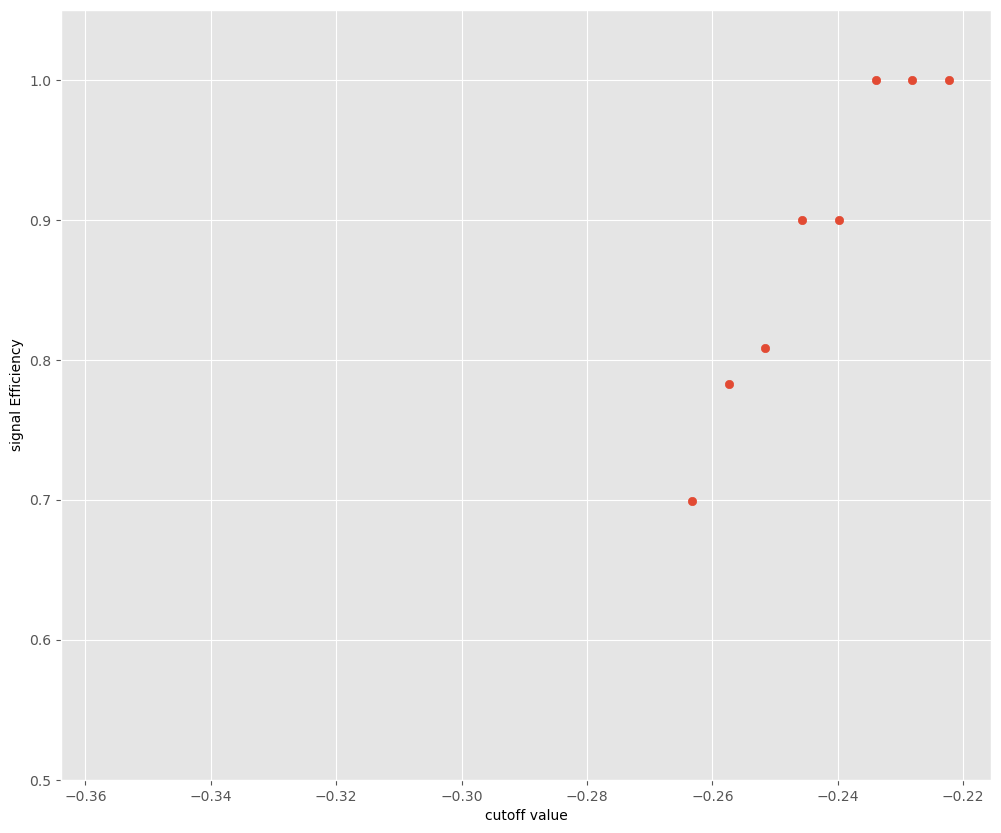

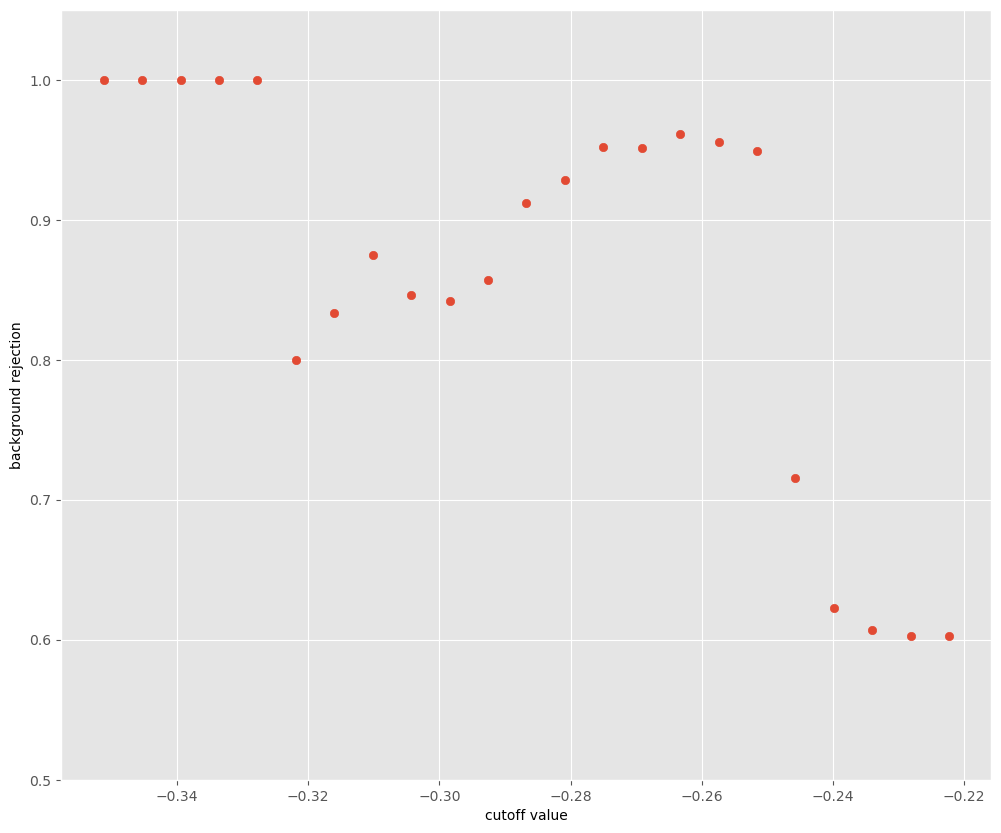

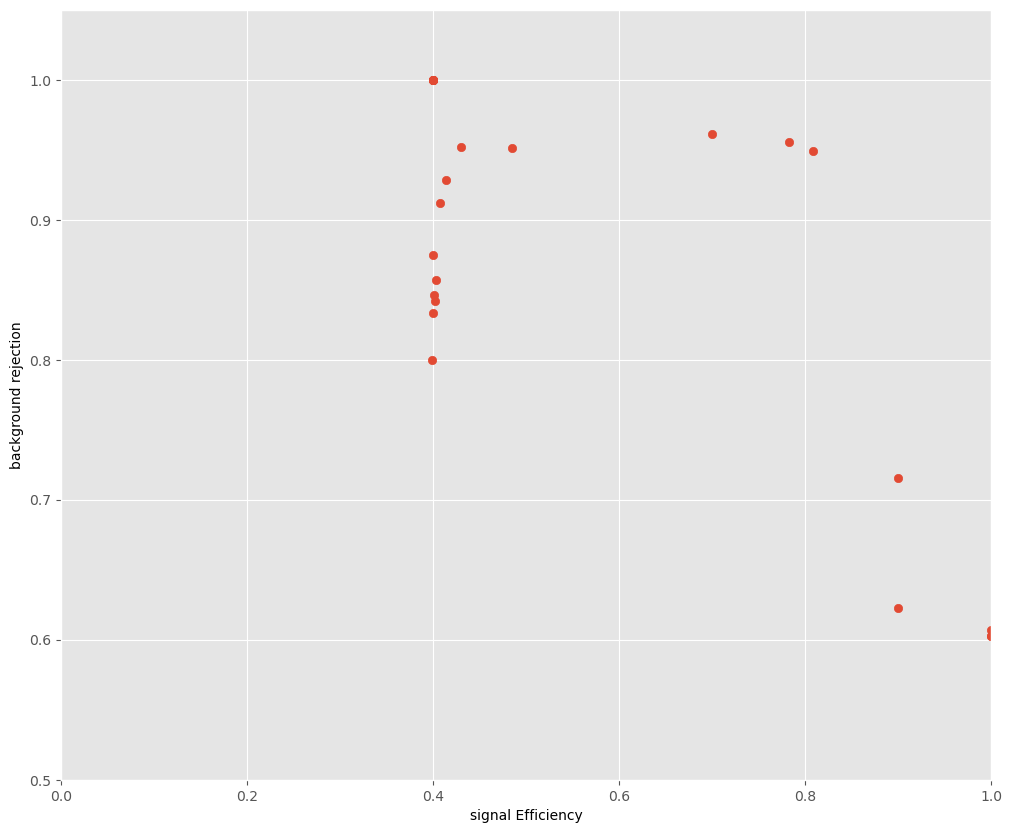

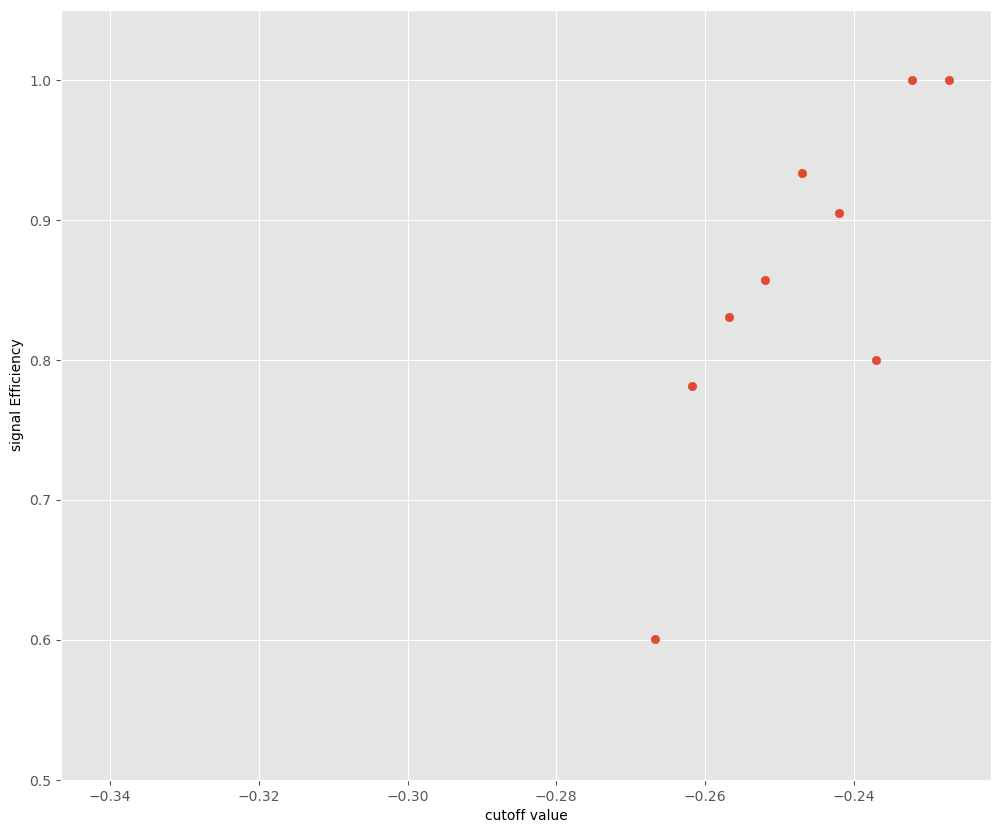

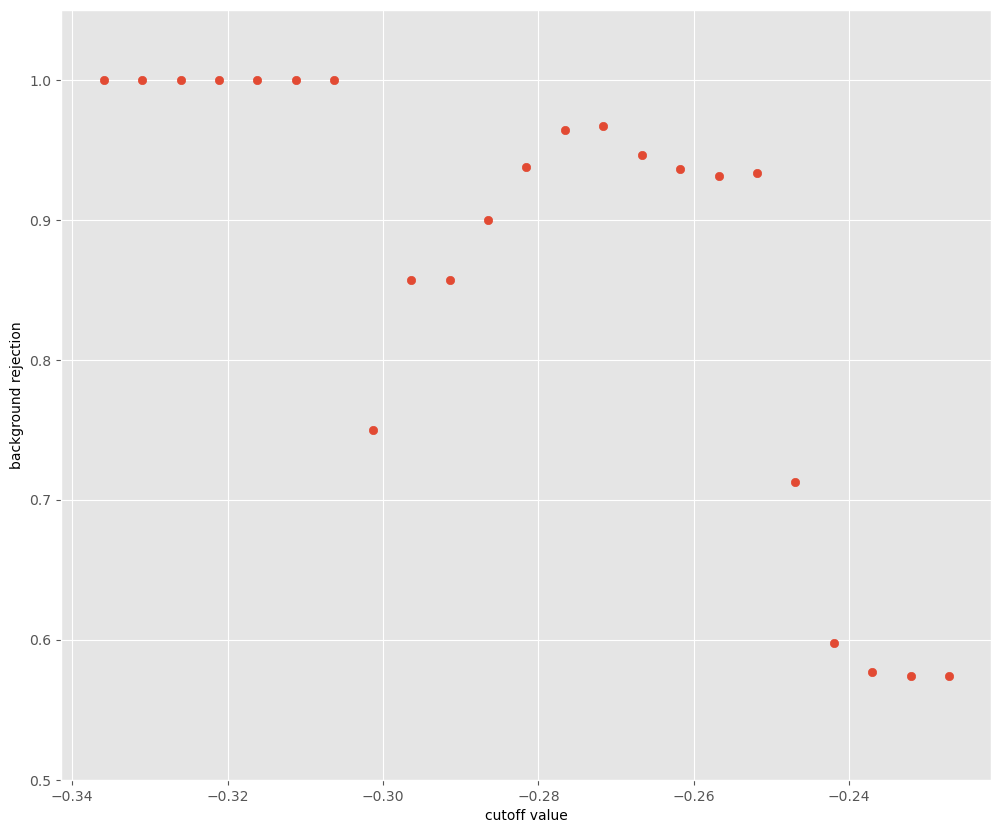

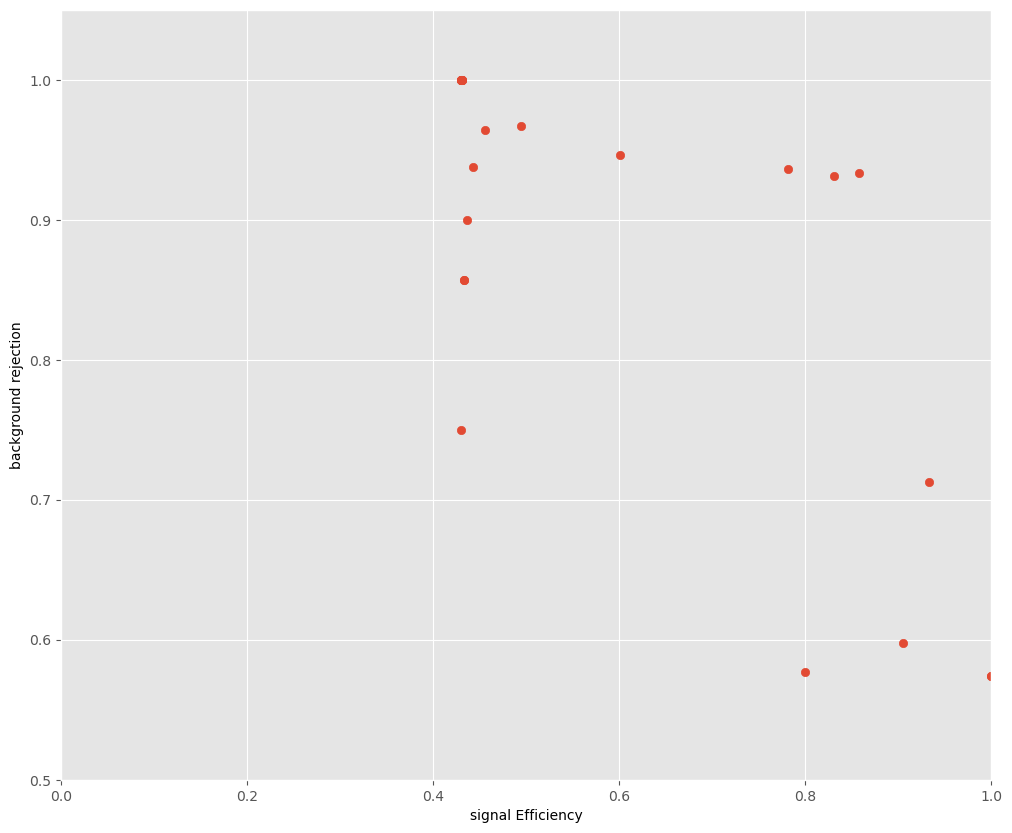

In [15]:
def train():
    model.train()
    #lossList = []
    outList = []
    for data in train_loader:  # Iterate in batches over the training dataset.
        #print(data)
        out = model(data.x, data.edge_index, data.batch, data.edge_attr)  # Perform a single forward pass.
        #print(out[0])
        outList += [out.detach().numpy().tolist()]
        #print(data.y)
        loss = criterion(out[0].float(), data.y.float())  # Compute the loss.
        #lossList += [loss.detach().numpy().tolist()]
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return outList #lossList

    #print(f'loss: {loss:.4f}')


def test(loader, isSignalArray):
    model.eval()
    correct = 0
    signalCorrect = 0
    backgroundCorrect = 0
    startSlice = 0
    endSlice = loader.batch_size
    signalNum = 0
    backgroundNum = 0
    outList = []
    lossList = []
    sig = torch.nn.Sigmoid()
    #print(len(outList))
    for data in loader:  # Iterate in batches over the training/test dataset.
        batch_num = data.num_graphs
        isSignalArraySlice = isSignalArray[startSlice:endSlice]
        out = model(data.x, data.edge_index, data.batch, data.edge_attr) 
        #print(out)
        outList += out.detach().numpy().tolist()
        #for name, param in model.named_parameters():
        #    if param.requires_grad:
        #        print(torch.sum(param.data.clone()))
        #pred = out.argmax(dim=1)  # Use the class with highest probability.
        #print(sig(out[0][0]),data.y.float())
        if sig(out[0][0])>=0.5:
            pred = 1.0
        else:
            pred = 0.0
        
        #whereSignal = np.where(isSignalArraySlice==1)[0]
        #whereNotSignal = np.where(isSignalArraySlice==0)[0]
        #signalPred = pred[whereSignal]
        #backgroundPred = pred[whereNotSignal]
        #signalNum += len(signalPred)
        #backgroundNum += len(backgroundPred)
        #
        #signalCorrect += int((signalPred == data.y[whereSignal]).sum())
        #backgroundCorrect += int((backgroundPred == data.y[whereNotSignal]).sum())
        correct += int((pred == data.y))  # Check against ground-truth labels.
        
        
        startSlice+= batch_num
        endSlice+= batch_num
        
        loss = criterion(out[0].float(), data.y.float())  # Compute the loss.
        lossList += [loss.detach().numpy().tolist()]
    
        
    return correct / len(loader.dataset),lossList ,outList#signalCorrect/signalNum, backgroundCorrect/backgroundNum \#,whereSignal,whereNotSignal  # Derive ratio of correct predictions.








#allGraphData = allGraphData[nbbSignalOnly]

endTrainData = int(np.floor(3/4*len(allGraphData)))
train_dataset = allGraphData[0:endTrainData,:]
test_dataset = allGraphData[endTrainData:,:]
#test_dataset = np.append(test_dataset,allGraphData[backgroundNbb])

if energySignalEnalbed:
    train_loader = DataLoader(train_dataset[:,-2] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-2] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-3]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-3]
else:
    train_loader = DataLoader(train_dataset[:,-1] # get the Data classes constructed by Pytorch
                              , batch_size=1
                              #, shuffle=True
                             )
    test_loader = DataLoader(test_dataset[:,-1] # get the Data classes constructed by Pytorch
                             , batch_size=1
                             #, shuffle=True
                            )
    isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-2]
    isSignalArrayTesting = allGraphData[endTrainData:,:][:,-2]
    
model = GAT(hidden_channels=64, num_classes=1, num_node_features = 4)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
#criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()

plt.style.use("ggplot")

avgLossTrainList = []
avgLossTestList = []

avgLossNbbTestList = []
avgLossSeTestList = []

avgLossNbbTrainList = []
avgLossSeTrainList = []

nbbTrain = np.where((train_dataset[:,-3]==1))[0] #nutrinoless double beta decay
nbbTrainSignal = np.where((train_dataset[:,-3]==1) & (train_dataset[:,-1]==1))[0] #nutrinoless double beta decay
nbbTrainBackground = np.where((train_dataset[:,-3]==1) & (train_dataset[:,-1]==0))[0] #nutrinoless double beta decay
seTrain = np.where(train_dataset[:,-3]==0)[0]#single electron

nbbTest = np.where(test_dataset[:,-3]==1)[0] #nutrinoless double beta decay
nbbTestSignal = np.where((test_dataset[:,-3]==1) & (test_dataset[:,-1]==1))[0] #nutrinoless double beta decay
nbbTestBackground = np.where((test_dataset[:,-3]==1) & (test_dataset[:,-1]==0))[0] #nutrinoless double beta decay
seTest = np.where(test_dataset[:,-3]==0)[0]#single electron

for epoch in range(1, 101):
    outList =[]
    outList += train()


    train_acc,lossTrainList,outTrainList = test(train_loader,isSignalArrayTraining)
    lossTrainList = np.array(lossTrainList)
    outTrainList = np.array(outTrainList)
    
    #np.savetxt("out/raw/train/SignalEpoch{}.txt".format(epoch), outTrainList[nbbTrain], delimiter=",")
    #np.savetxt("out/raw/train/BackgroundEpoch{}.txt".format(epoch), outTrainList[seTrain], delimiter=",")
    #np.savetxt("out/maxProb/train/SignalEpoch{}.txt".format(epoch), 
    #           np.array([max(x) for x in outTrainList[nbbTrain]]).flatten(), delimiter=",")
    #np.savetxt("out/maxProb/train/BackgroundEpoch{}.txt".format(epoch), 
    #           np.array([max(x) for x in outTrainList[seTrain]]).flatten(), delimiter=",")
    

    test_acc,lossTestList,outTestList = test(test_loader,isSignalArrayTesting)
    lossTestList = np.array(lossTestList)
    outTestList = np.array(outTestList)
    
    #np.savetxt("out/raw/test/SignalEpoch{}.txt".format(epoch), outTestList[nbbTest], delimiter=",")
    #np.savetxt("out/raw/test/BackgroundEpoch{}.txt".format(epoch), outTestList[seTest], delimiter=",")
    #np.savetxt("out/maxProb/test/SignalEpoch{}.txt".format(epoch), 
    #           np.array([max(x) for x in outTestList[nbbTest]]).flatten(), delimiter=",")
    #np.savetxt("out/maxProb/test/BackgroundEpoch{}.txt".format(epoch), 
    #           np.array([max(x) for x in outTestList[seTest]]).flatten(), delimiter=",")
    
    avgLossTrainList += [np.mean(lossTrainList)]
    avgLossTestList += [np.mean(lossTestList)]
    
    avgLossNbbTestList += [np.mean(lossTestList[nbbTest])]
    avgLossSeTestList += [np.mean(lossTestList[seTest])]

    avgLossNbbTrainList += [np.mean(lossTrainList[nbbTrain])]
    avgLossSeTrainList += [np.mean(lossTrainList[seTrain])]
    
    if epoch%5 == 0 or epoch==1:
        #plt.title("epoch {} training dataset".format(epoch))
        #plt.hist(lossTrainList,alpha=0.25)
        #plt.show()
        #
        #plt.title("epoch {} training dataset".format(epoch))
        #plt.hist(lossTrainList[nbbTrain],alpha=0.25,label="double beta")
        #plt.legend()
        #plt.show()
        #
        #plt.title("epoch {} training dataset".format(epoch))
        #plt.hist(lossTrainList[seTrain],alpha=0.25,label="single electron")
        #plt.legend()
        #plt.show()
        #
        #plt.title("epoch {} test dataset".format(epoch))
        #plt.hist(lossTestList,alpha=0.25)
        #plt.show()
        #
        #plt.title("epoch {} test dataset".format(epoch))
        #plt.hist(lossTestList[nbbTest],alpha=0.25,label="double beta")
        #plt.legend()
        #plt.show()
        #
        #plt.title("epoch {} test dataset".format(epoch))
        #plt.hist(lossTestList[seTest],alpha=0.25,label="single electron")
        #plt.legend()
        #plt.show()
        plt.hist(np.array(outList).flatten())
        plt.show()
        
    sig = torch.nn.Sigmoid()
    acceptedValues = np.array(outTrainList).flatten()#np.array([max(i[0]) for i in outList])
    rangeCuts = np.linspace(min(acceptedValues),max(acceptedValues),24)
    
    signalEfficiency = []
    backgroundRejection = []
    for num in rangeCuts:
        sigLoc = np.where(acceptedValues>=num)[0]
        backLoc = np.where(acceptedValues<num)[0]
        lenSigLoc = len(sigLoc)
        lenBackLoc = len(backLoc)

        if len(sigLoc)==0:
            signalEfficiency += [0]

        elif len(sigLoc)>=1:
            if sum(train_dataset[sigLoc,-3] == 1) >= 1:
                signalEfficiency += [sum(train_dataset[sigLoc,-3] == 1)/lenSigLoc]

            else:
                signalEfficiency += [0]



        if len(backLoc)==0:
            print("0")
            backgroundRejection += [0]
        elif len(backLoc)>=1:      
            #print("1",sum(train_dataset[backLoc,-3] == 0))
            if sum(train_dataset[backLoc,-3] == 0) >= 1:
                backgroundRejection += [sum(train_dataset[backLoc,-3] == 0)/lenBackLoc]
            else:
                #print("2")
                backgroundRejection += [0]
                
    signalEfficiency = np.array(signalEfficiency)
    backgroundRejection = np.array(backgroundRejection)
    nonzero = np.where((signalEfficiency!=0) & (backgroundRejection!=0))[0]

    plt.figure(figsize=(12,10))
    plt.scatter(rangeCuts,signalEfficiency)
    plt.xlabel("cutoff value")
    plt.ylabel("signal Efficiency")
    #plt.xlim([0,1])
    plt.ylim([0.5,1.05])
    #plt.savefig("fig/train/sig/sig{}".format(epoch))
    #plt.show()
    plt.figure(figsize=(12,10))
    plt.scatter(rangeCuts[nonzero],backgroundRejection[nonzero])
    plt.xlabel("cutoff value")
    plt.ylabel("background rejection")
    #plt.xlim([0,1])
    plt.ylim([0.5,1.05])
    #plt.savefig("fig/train/back/back{}".format(epoch))
    #plt.show()
    plt.figure(figsize=(12,10))
    plt.scatter(signalEfficiency[nonzero],backgroundRejection[nonzero])
    plt.xlabel("signal Efficiency")
    plt.ylabel("background rejection")
    plt.xlim([0,1])
    plt.ylim([0.5,1.05])
    #plt.savefig("fig/train/both/both{}".format(epoch))
    #plt.show()
    
    
    
    
    
    
    
    
    
    #sig = torch.nn.Sigmoid()
    acceptedValues = np.array(outTestList).flatten()#np.array([max(i[0]) for i in outList])
    rangeCuts = np.linspace(min(acceptedValues),max(acceptedValues),24)
    
    signalEfficiency = []
    backgroundRejection = []
    for num in rangeCuts:
        sigLoc = np.where(acceptedValues>=num)[0]
        backLoc = np.where(acceptedValues<num)[0]
        lenSigLoc = len(sigLoc)
        lenBackLoc = len(backLoc)

        if len(sigLoc)==0:
            signalEfficiency += [0]

        elif len(sigLoc)>=1:
            if sum(test_dataset[sigLoc,-3] == 1) >= 1:
                signalEfficiency += [sum(test_dataset[sigLoc,-3] == 1)/lenSigLoc]

            else:
                signalEfficiency += [0]



        if len(backLoc)==0:
            print("0")
            backgroundRejection += [0]
        elif len(backLoc)>=1:      
            #print("1",sum(train_dataset[backLoc,-3] == 0))
            if sum(test_dataset[backLoc,-3] == 0) >= 1:
                backgroundRejection += [sum(test_dataset[backLoc,-3] == 0)/lenBackLoc]
            else:
                #print("2")
                backgroundRejection += [0]
                
    signalEfficiency = np.array(signalEfficiency)
    backgroundRejection = np.array(backgroundRejection)
    nonzero = np.where((signalEfficiency!=0) & (backgroundRejection!=0))[0]

    plt.figure(figsize=(12,10))
    plt.scatter(rangeCuts,signalEfficiency)
    plt.xlabel("cutoff value")
    plt.ylabel("signal Efficiency")
    #plt.xlim([0,1])
    plt.ylim([0.5,1.05])
    #plt.savefig("fig/test/sig/sig{}".format(epoch))
    #plt.show()
    plt.figure(figsize=(12,10))
    plt.scatter(rangeCuts[nonzero],backgroundRejection[nonzero])
    plt.xlabel("cutoff value")
    plt.ylabel("background rejection")
    #plt.xlim([0,1])
    plt.ylim([0.5,1.05])
    #plt.savefig("fig/test/back/back{}".format(epoch))
    #plt.show()
    plt.figure(figsize=(12,10))
    plt.scatter(signalEfficiency[nonzero],backgroundRejection[nonzero])
    plt.xlabel("signal Efficiency")
    plt.ylabel("background rejection")
    plt.xlim([0,1])
    plt.ylim([0.5,1.05])
    #plt.savefig("fig/test/both/both{}".format(epoch))
    #plt.show()
    
    print(f'''Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}''')

In [ ]:
backgroundRejection

In [ ]:
plt.title("average loss for training data")
plt.plot(list(range(1,epoch+1)), avgLossTrainList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTrainList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTrainList,label="double beta")

#plt.plot(list(range(1,epoch+1)), avgLossNbbSignalTrainList,label="double beta Signal")

#plt.plot(list(range(1,epoch+1)), avgLossNbbBackgroundTrainList,label="double beta Background")
plt.ylabel("average Loss values")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.title("average loss for test data")
plt.plot(list(range(1,epoch+1)), avgLossTestList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTestList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTestList,label="double beta")

#plt.plot(list(range(1,epoch+1)), avgLossNbbSignalTestList,label="double beta Signal")

#plt.plot(list(range(1,epoch+1)), avgLossNbbBackgroundTestList,label="double beta Background")
plt.ylabel("average Loss values")
plt.xlabel("epoch")
plt.legend()
plt.show()

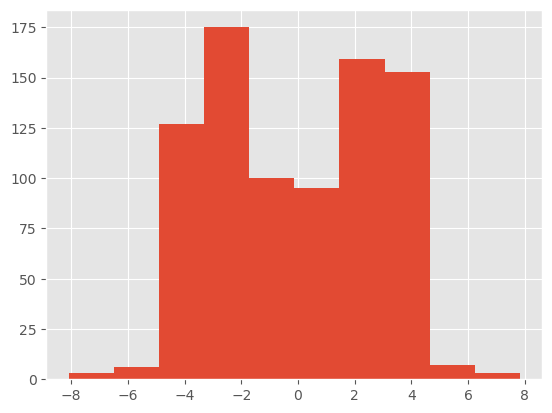

In [169]:
plt.hist(np.array(outTestList).flatten())
plt.show()

In [ ]:
#np.savetxt("foo.csv", outTestList, delimiter=",")

In [ ]:
#np.array([max(x) for x in outTestList]).flatten()

In [41]:
#outList

[[[-4.219892978668213]],
 [[2.3635804653167725]],
 [[-4.671831130981445]],
 [[3.628554582595825]],
 [[2.096771717071533]],
 [[-6.840987205505371]],
 [[-14.837371826171875]],
 [[2.505920886993408]],
 [[-0.9290127754211426]],
 [[-5.0477681159973145]],
 [[-2.840208053588867]],
 [[-6.19722843170166]],
 [[-0.2922907769680023]],
 [[-6.379700660705566]],
 [[-5.625657081604004]],
 [[-3.6934800148010254]],
 [[-3.9292874336242676]],
 [[2.4137182235717773]],
 [[0.8619457483291626]],
 [[-5.438029766082764]],
 [[-2.187736749649048]],
 [[-2.848672866821289]],
 [[-7.198044300079346]],
 [[-4.625701427459717]],
 [[0.8506819605827332]],
 [[-6.0201592445373535]],
 [[-4.86848783493042]],
 [[-5.376461029052734]],
 [[2.430723190307617]],
 [[4.500799179077148]],
 [[-3.6232128143310547]],
 [[1.5266345739364624]],
 [[0.1627926528453827]],
 [[1.342039704322815]],
 [[1.2163469791412354]],
 [[-0.7020803093910217]],
 [[-3.5177247524261475]],
 [[1.1849864721298218]],
 [[0.5002049207687378]],
 [[1.6868926286697388]]

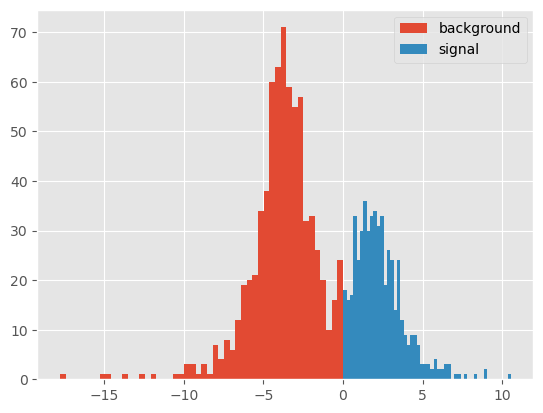

In [76]:
for epoch in range(1, 101):
    outList = pd.read_csv("raw/")
    sig = torch.nn.Sigmoid()
    acceptedValues = np.array(outList).flatten()#np.array([max(i[0]) for i in outList])
    rangeCuts = np.linspace(min(acceptedValues),max(acceptedValues),20)
    
    #sigOrBack = np.array([i[0].index(max(i[0])) for i in outList])
    #sigOrBack = np.where(sig(torch.Tensor(outList))>=0.5)[0]
    #plt.hist(acceptedValues[np.where(sig(torch.Tensor(outList))<0.5)[0]],label="background",bins=50)
    #plt.hist(acceptedValues[np.where(sig(torch.Tensor(outList))>=0.5
    #                                )[0]], label = "signal",bins=50)
    #plt.legend()
    #plt.show()

In [71]:
signalEfficiency = []
backgroundRejection = []
for num in rangeCuts:
    sigLoc = np.where(acceptedValues>=num)[0]
    backLoc = np.where(acceptedValues<num)[0]
    lenSigLoc = len(sigLoc)
    lenBackLoc = len(backLoc)
    
    if len(sigLoc)==0:
        signalEfficiency += [0]
        
    elif len(sigLoc)>=1:
        if sum(train_dataset[sigLoc,-3] == 1) >= 1:
            signalEfficiency += [sum(train_dataset[sigLoc,-3] == 1)/lenSigLoc]
            
    else:
        if  0 + train_dataset[sigLoc[0],-3] == 1 >= 1:
            signalEfficiency += [(0 + train_dataset[sigLoc[0],-3] == 1)/lenSigLoc]
            
            
            
    if len(backLoc)==0:
        backgroundRejection += [0]
    elif len(backLoc)>=1:      
        if sum(train_dataset[backLoc,-3] == 0) >= 1:
            backgroundRejection += [sum(train_dataset[backLoc,-3] == 0)/lenBackLoc]
    else:
        if 0 + train_dataset[backLoc[0],-3] == 1 >= 1:
            backgroundRejection += [(0 + train_dataset[backLoc[0],-3] == 1)/lenBackLoc]

In [72]:
len(signalEfficiency),len(backgroundRejection)

(20, 20)

In [73]:
signalEfficiency = np.array(signalEfficiency)
backgroundRejection = np.array(backgroundRejection)
nonzero = np.where((signalEfficiency!=0) & (backgroundRejection!=0))[0]

plt.scatter(rangeCuts,signalEfficiency)
plt.show()
plt.scatter(rangeCuts[nonzero],backgroundRejection[nonzero])
plt.show()
plt.scatter(signalEfficiency[nonzero],backgroundRejection[nonzero])

In [74]:
nonzero = np.where((signalEfficiency!=0) & (backgroundRejection!=0))[0]


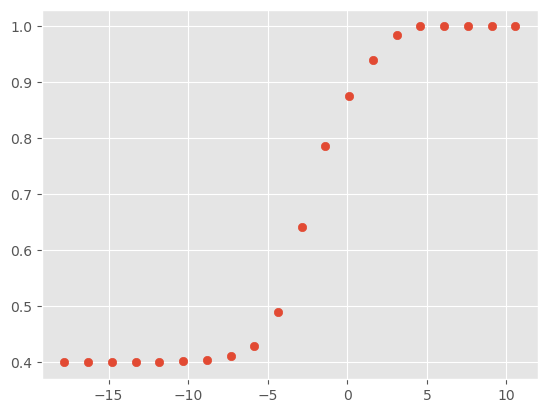

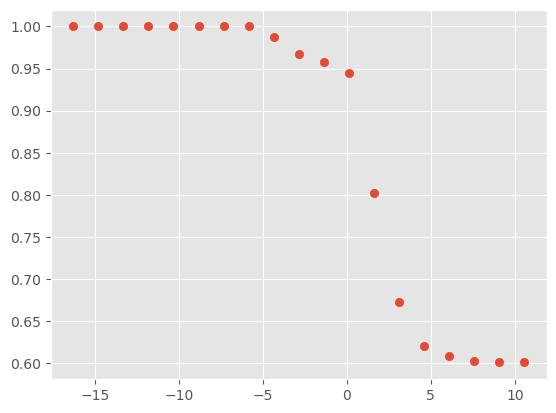

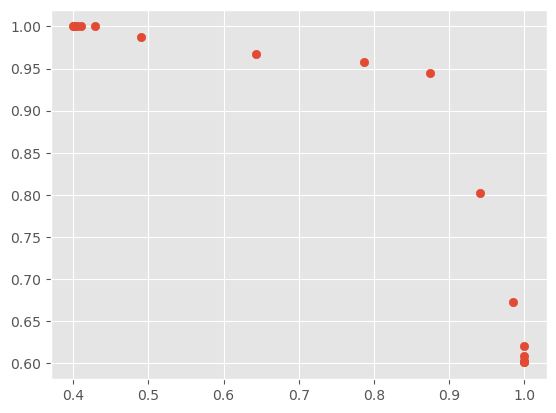

In [75]:

plt.scatter(rangeCuts,signalEfficiency)
plt.show()
plt.scatter(rangeCuts[nonzero],backgroundRejection[nonzero])
plt.show()
plt.scatter(signalEfficiency[nonzero],backgroundRejection[nonzero])

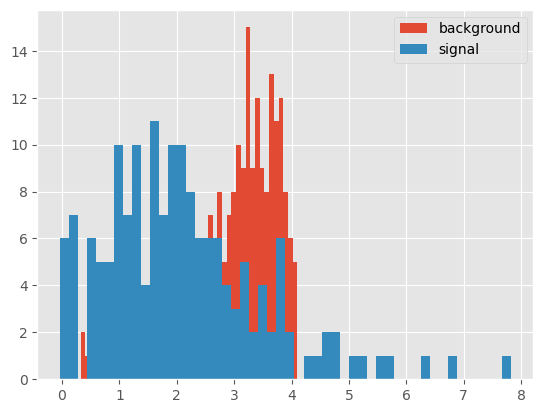

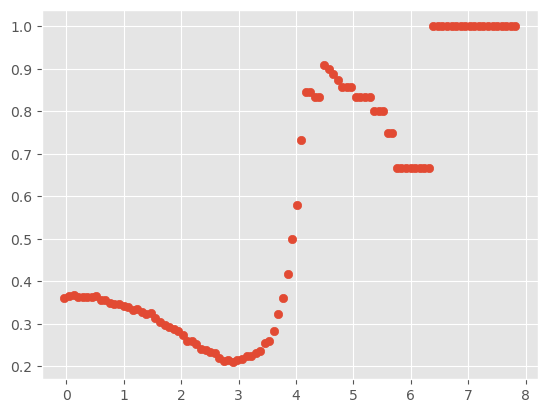

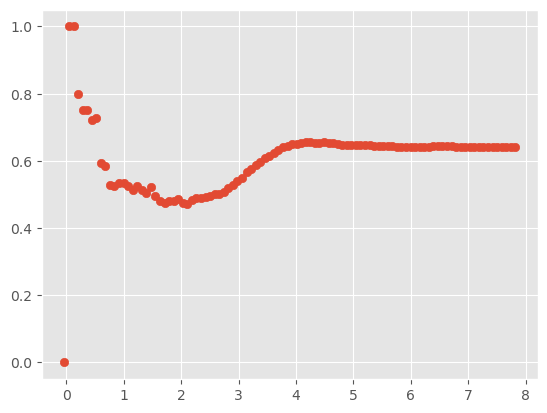

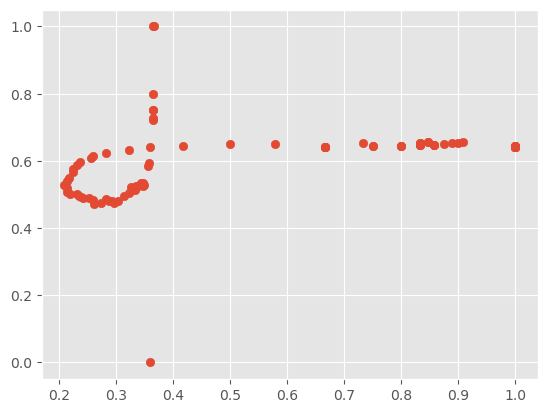

In [164]:
acceptedValues = np.array([max(i) for i in outTestList])
rangeCuts = np.linspace(min(acceptedValues),max(acceptedValues),100)
sigOrBack = np.array([i.index(max(i)) for i in outTestList])
plt.hist(acceptedValues[np.where(sigOrBack==0)[0]],label="background",bins=50)
plt.hist(acceptedValues[np.where(sigOrBack==1)[0]], label = "signal",bins=50)
plt.legend()
plt.show()

signalEfficiency = []
backgroundRejection = []
for num in rangeCuts:
    sigLoc = np.where(acceptedValues>=num)[0]
    backLoc = np.where(acceptedValues<num)[0]
    lenSigLoc = len(sigLoc)
    lenBackLoc = len(backLoc)
    
    if len(sigLoc)==0:
        signalEfficiency += [0]
        
    elif len(sigLoc)>1:
        if sum(test_dataset[sigLoc,-3] == 1) >= 1:
            signalEfficiency += [sum(test_dataset[sigLoc,-3] == 1)/lenSigLoc]
            
    else:
        if  0 + test_dataset[sigLoc[0],-3] == 1 >= 1:
            signalEfficiency += [(0 + test_dataset[sigLoc[0],-3] == 1)/lenSigLoc]
            
            
            
    if len(backLoc)==0:
        backgroundRejection += [0]
    elif len(backLoc)>1:      
        if sum(test_dataset[backLoc,-3] == 0) >= 1:
            backgroundRejection += [sum(test_dataset[backLoc,-3] == 0)/lenBackLoc]
    else:
        if 0 + test_dataset[backLoc[0],-3] == 1 >= 1:
            backgroundRejection += [(0 + test_dataset[backLoc[0],-3] == 1)/lenBackLoc]
            
plt.scatter(rangeCuts,signalEfficiency)
plt.show()
plt.scatter(rangeCuts,backgroundRejection)
plt.show()
plt.scatter(signalEfficiency,backgroundRejection)

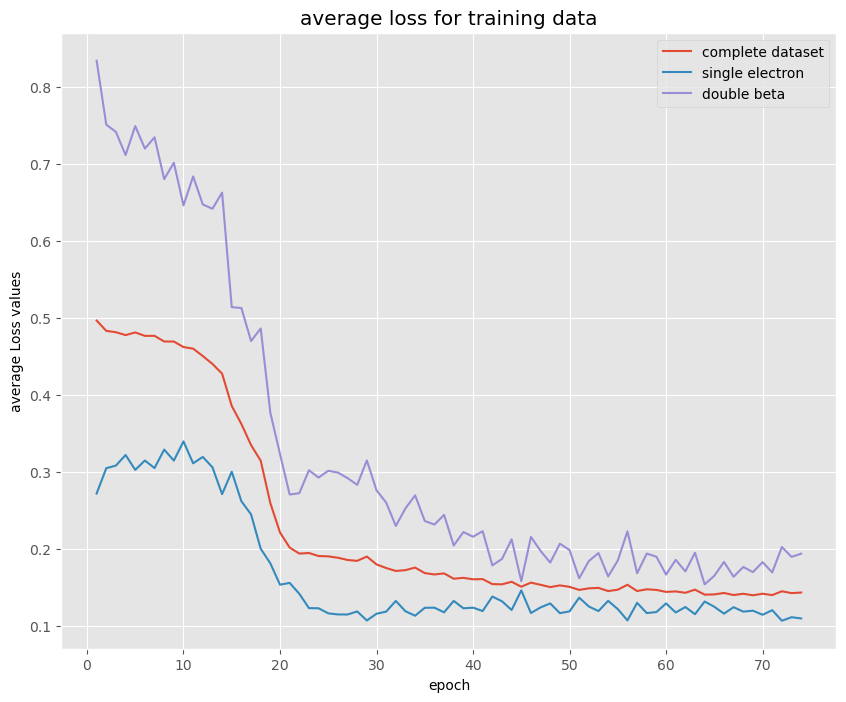

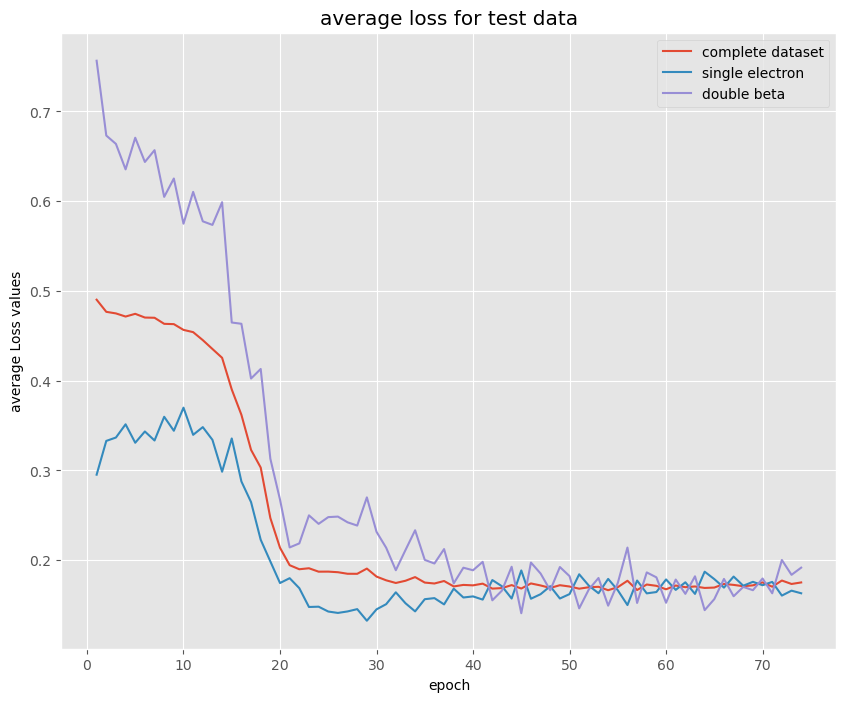

In [11]:
plt.figure(figsize=(10,8))
plt.title("average loss for training data")
plt.plot(list(range(1,epoch+1)), avgLossTrainList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTrainList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTrainList,label="double beta")

#plt.plot(list(range(1,epoch+1)), avgLossNbbSignalTrainList,label="double beta Signal")
#
#plt.plot(list(range(1,epoch+1)), avgLossNbbBackgroundTrainList,label="double beta Background")
plt.ylabel("average Loss values")
plt.xlabel("epoch")
plt.legend()
plt.savefig("train.png")
plt.show()

plt.figure(figsize=(10,8))
plt.title("average loss for test data")
plt.plot(list(range(1,epoch+1)), avgLossTestList, label="complete dataset")


plt.plot(list(range(1,epoch+1)), avgLossSeTestList,label="single electron")


plt.plot(list(range(1,epoch+1)), avgLossNbbTestList,label="double beta")

#plt.plot(list(range(1,epoch+1)), avgLossNbbSignalTestList,label="double beta Signal")
#
#plt.plot(list(range(1,epoch+1)), avgLossNbbBackgroundTestList,label="double beta Background")
plt.ylabel("average Loss values")
plt.xlabel("epoch")
plt.legend()
plt.savefig("test.png")
plt.show()

In [224]:
test_loader.dataset[-1].x

tensor([[4.5605e-03, 0.0000e+00, 4.5605e-03, 0.0000e+00],
        [1.0918e-02, 0.0000e+00, 1.0918e-02, 0.0000e+00],
        [3.8780e-03, 0.0000e+00, 3.8780e-03, 0.0000e+00],
        ...,
        [5.9797e-03, 3.0000e+00, 1.1613e-02, 3.3120e-02],
        [1.4447e-02, 4.0000e+00, 1.0330e-02, 3.5923e-02],
        [1.7085e-03, 4.0000e+00, 1.0330e-02, 3.5974e-02]])

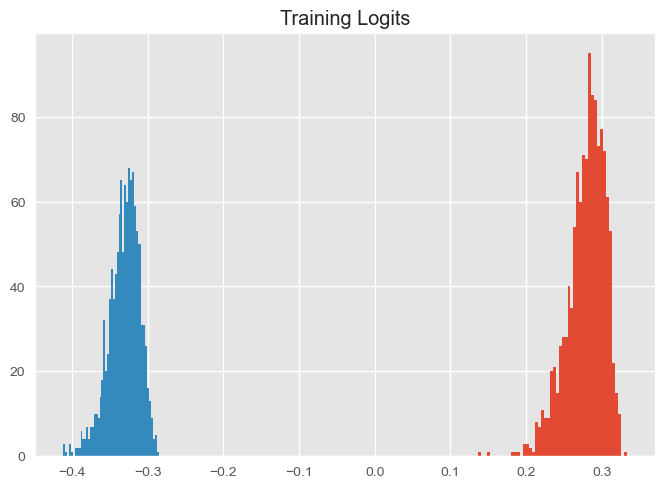

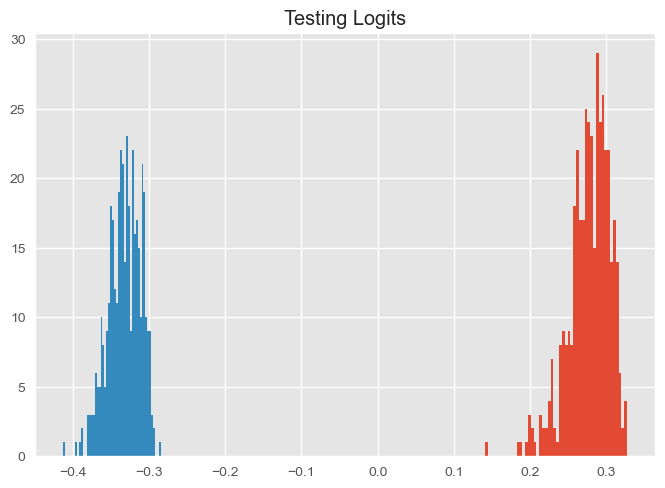

Epoch: 001, Train Acc: 0.6003, Test Acc: 0.5773
Epoch: 001, train_signal_acc: 0.4000, train_background_acc: 0.6028
Epoch: 001, test_signal_acc: 0.7143, test_background_acc: 0.5749
Epoch: 002, Train Acc: 0.6003, Test Acc: 0.5773
Epoch: 002, train_signal_acc: 0.4000, train_background_acc: 0.6028
Epoch: 002, test_signal_acc: 0.7143, test_background_acc: 0.5749
Epoch: 003, Train Acc: 0.6060, Test Acc: 0.5821
Epoch: 003, train_signal_acc: 0.4000, train_background_acc: 0.6085
Epoch: 003, test_signal_acc: 0.7143, test_background_acc: 0.5799
Epoch: 004, Train Acc: 0.6962, Test Acc: 0.6425
Epoch: 004, train_signal_acc: 0.6000, train_background_acc: 0.6974
Epoch: 004, test_signal_acc: 0.8571, test_background_acc: 0.6388


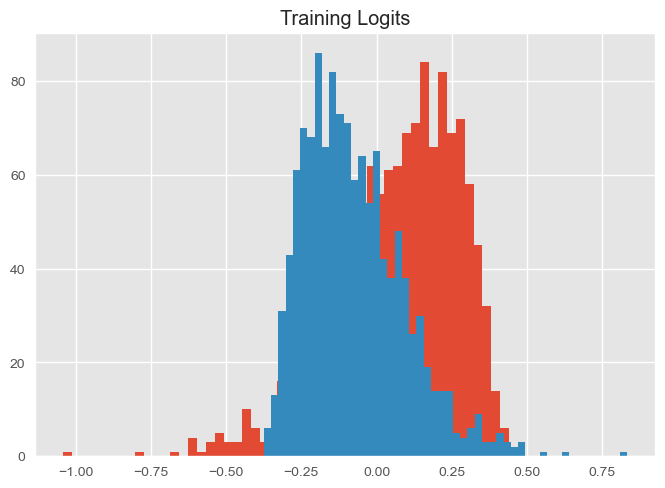

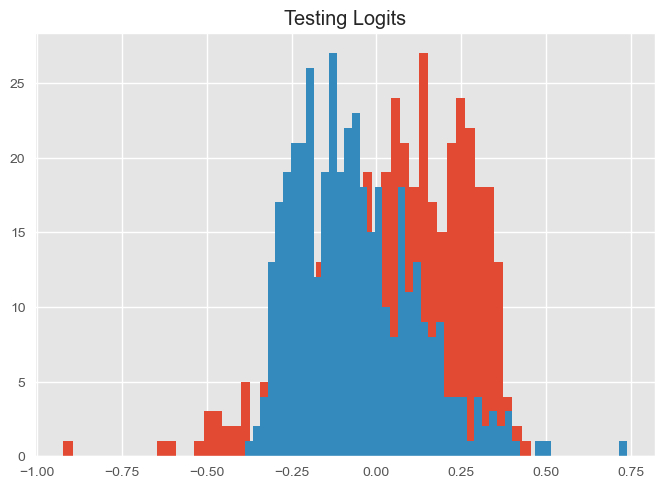

Epoch: 005, Train Acc: 0.7639, Test Acc: 0.7295
Epoch: 005, train_signal_acc: 0.8000, train_background_acc: 0.7635
Epoch: 005, test_signal_acc: 1.0000, test_background_acc: 0.7248
Epoch: 006, Train Acc: 0.7365, Test Acc: 0.7174
Epoch: 006, train_signal_acc: 0.7333, train_background_acc: 0.7365
Epoch: 006, test_signal_acc: 1.0000, test_background_acc: 0.7125
Epoch: 007, Train Acc: 0.7526, Test Acc: 0.7295
Epoch: 007, train_signal_acc: 0.8000, train_background_acc: 0.7520
Epoch: 007, test_signal_acc: 1.0000, test_background_acc: 0.7248
Epoch: 008, Train Acc: 0.7631, Test Acc: 0.7319
Epoch: 008, train_signal_acc: 0.8000, train_background_acc: 0.7626
Epoch: 008, test_signal_acc: 1.0000, test_background_acc: 0.7273
Epoch: 009, Train Acc: 0.7800, Test Acc: 0.7512
Epoch: 009, train_signal_acc: 0.7333, train_background_acc: 0.7806
Epoch: 009, test_signal_acc: 1.0000, test_background_acc: 0.7469


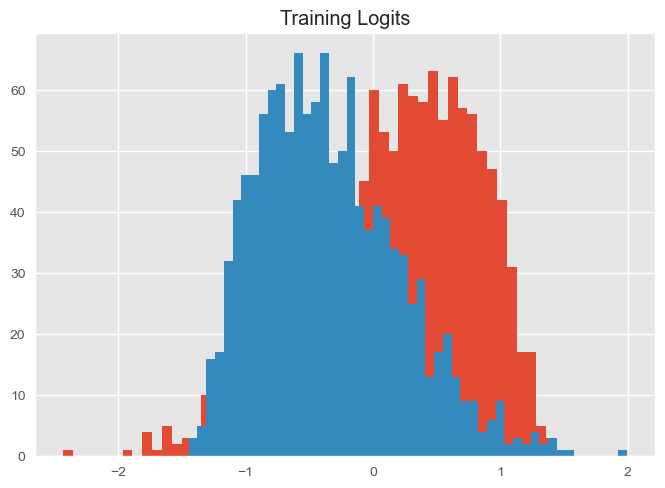

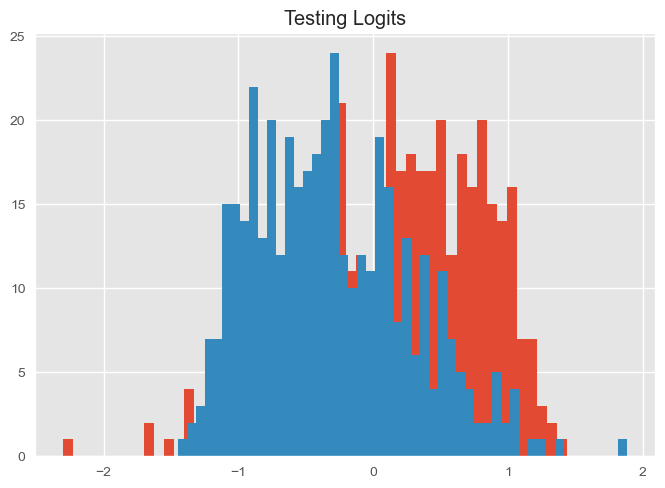

Epoch: 010, Train Acc: 0.7897, Test Acc: 0.7609
Epoch: 010, train_signal_acc: 0.7333, train_background_acc: 0.7904
Epoch: 010, test_signal_acc: 1.0000, test_background_acc: 0.7568
Epoch: 011, Train Acc: 0.7977, Test Acc: 0.7585
Epoch: 011, train_signal_acc: 0.8000, train_background_acc: 0.7977
Epoch: 011, test_signal_acc: 1.0000, test_background_acc: 0.7543
Epoch: 012, Train Acc: 0.7961, Test Acc: 0.7681
Epoch: 012, train_signal_acc: 0.6667, train_background_acc: 0.7977
Epoch: 012, test_signal_acc: 1.0000, test_background_acc: 0.7641
Epoch: 013, Train Acc: 0.8082, Test Acc: 0.7585
Epoch: 013, train_signal_acc: 0.8667, train_background_acc: 0.8075
Epoch: 013, test_signal_acc: 1.0000, test_background_acc: 0.7543
Epoch: 014, Train Acc: 0.8034, Test Acc: 0.7729
Epoch: 014, train_signal_acc: 0.6667, train_background_acc: 0.8051
Epoch: 014, test_signal_acc: 1.0000, test_background_acc: 0.7690


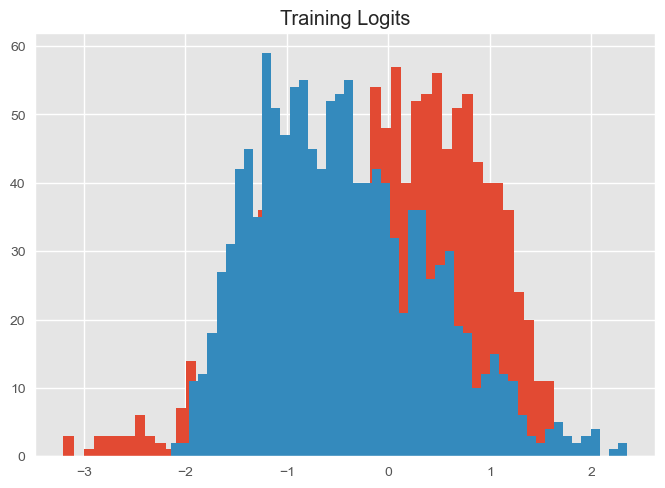

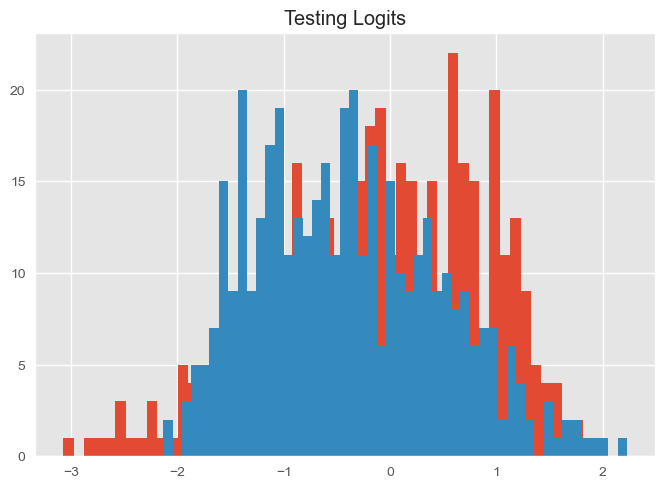

Epoch: 015, Train Acc: 0.8147, Test Acc: 0.7657
Epoch: 015, train_signal_acc: 0.8000, train_background_acc: 0.8148
Epoch: 015, test_signal_acc: 1.0000, test_background_acc: 0.7617
Epoch: 016, Train Acc: 0.8163, Test Acc: 0.7778
Epoch: 016, train_signal_acc: 0.7333, train_background_acc: 0.8173
Epoch: 016, test_signal_acc: 1.0000, test_background_acc: 0.7740
Epoch: 017, Train Acc: 0.8171, Test Acc: 0.7729
Epoch: 017, train_signal_acc: 0.7333, train_background_acc: 0.8181
Epoch: 017, test_signal_acc: 1.0000, test_background_acc: 0.7690
Epoch: 018, Train Acc: 0.8219, Test Acc: 0.7778
Epoch: 018, train_signal_acc: 0.7333, train_background_acc: 0.8230
Epoch: 018, test_signal_acc: 1.0000, test_background_acc: 0.7740
Epoch: 019, Train Acc: 0.8203, Test Acc: 0.7754
Epoch: 019, train_signal_acc: 0.7333, train_background_acc: 0.8214
Epoch: 019, test_signal_acc: 1.0000, test_background_acc: 0.7715


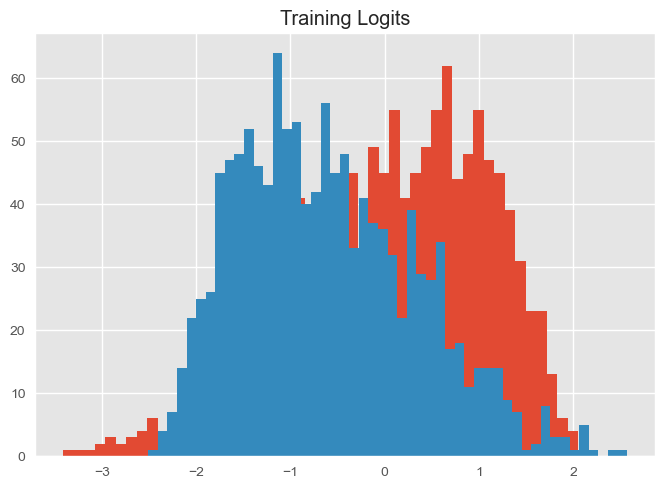

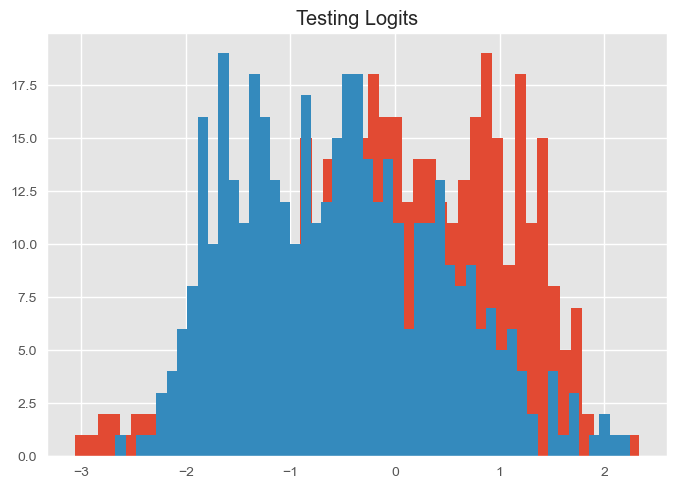

Epoch: 020, Train Acc: 0.8179, Test Acc: 0.7778
Epoch: 020, train_signal_acc: 0.6667, train_background_acc: 0.8197
Epoch: 020, test_signal_acc: 1.0000, test_background_acc: 0.7740
Epoch: 021, Train Acc: 0.8251, Test Acc: 0.7754
Epoch: 021, train_signal_acc: 0.7333, train_background_acc: 0.8263
Epoch: 021, test_signal_acc: 1.0000, test_background_acc: 0.7715
Epoch: 022, Train Acc: 0.8292, Test Acc: 0.7850
Epoch: 022, train_signal_acc: 0.7333, train_background_acc: 0.8303
Epoch: 022, test_signal_acc: 1.0000, test_background_acc: 0.7813
Epoch: 023, Train Acc: 0.8251, Test Acc: 0.7874
Epoch: 023, train_signal_acc: 0.6667, train_background_acc: 0.8271
Epoch: 023, test_signal_acc: 1.0000, test_background_acc: 0.7838
Epoch: 024, Train Acc: 0.8348, Test Acc: 0.7947
Epoch: 024, train_signal_acc: 0.7333, train_background_acc: 0.8361
Epoch: 024, test_signal_acc: 1.0000, test_background_acc: 0.7912


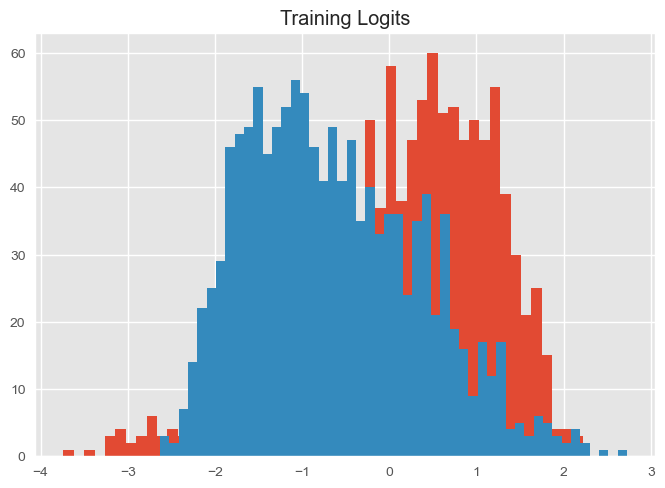

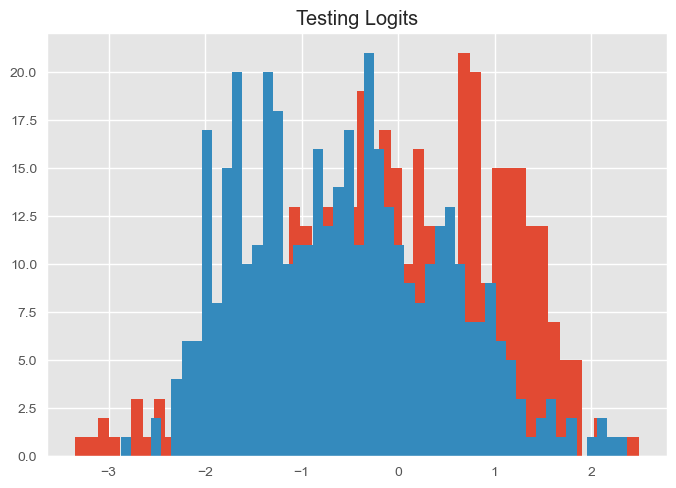

Epoch: 025, Train Acc: 0.8276, Test Acc: 0.7923
Epoch: 025, train_signal_acc: 0.6667, train_background_acc: 0.8295
Epoch: 025, test_signal_acc: 1.0000, test_background_acc: 0.7887
Epoch: 026, Train Acc: 0.8332, Test Acc: 0.7947
Epoch: 026, train_signal_acc: 0.6667, train_background_acc: 0.8352
Epoch: 026, test_signal_acc: 1.0000, test_background_acc: 0.7912
Epoch: 027, Train Acc: 0.8396, Test Acc: 0.7947
Epoch: 027, train_signal_acc: 0.6667, train_background_acc: 0.8418
Epoch: 027, test_signal_acc: 1.0000, test_background_acc: 0.7912
Epoch: 028, Train Acc: 0.8421, Test Acc: 0.8019
Epoch: 028, train_signal_acc: 0.6667, train_background_acc: 0.8442
Epoch: 028, test_signal_acc: 1.0000, test_background_acc: 0.7985
Epoch: 029, Train Acc: 0.8445, Test Acc: 0.8019
Epoch: 029, train_signal_acc: 0.6667, train_background_acc: 0.8467
Epoch: 029, test_signal_acc: 1.0000, test_background_acc: 0.7985


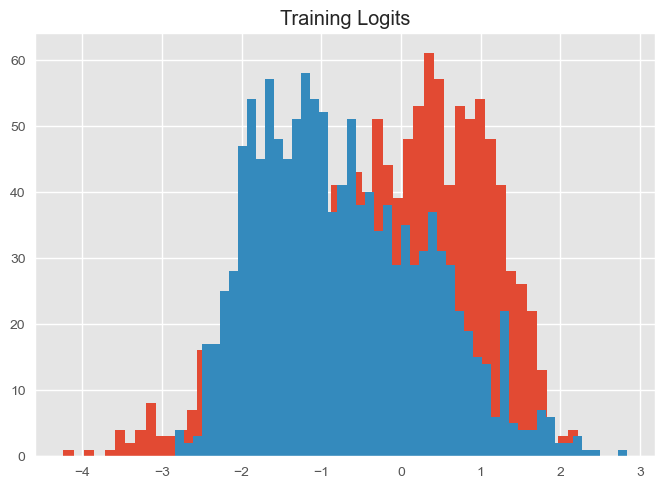

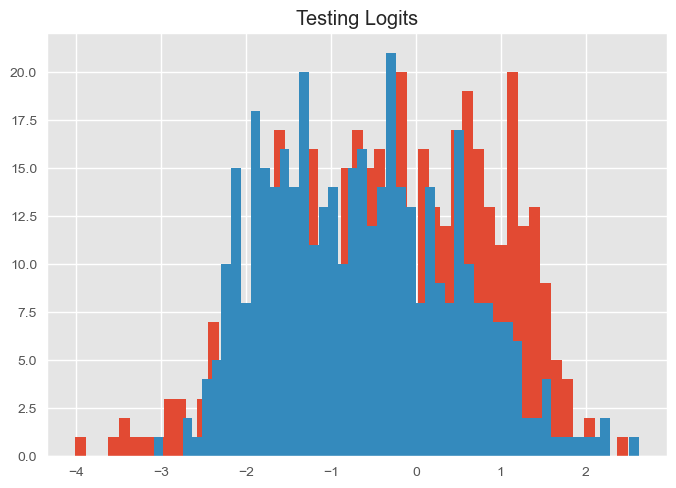

Epoch: 030, Train Acc: 0.8445, Test Acc: 0.7995
Epoch: 030, train_signal_acc: 0.6667, train_background_acc: 0.8467
Epoch: 030, test_signal_acc: 1.0000, test_background_acc: 0.7961
Epoch: 031, Train Acc: 0.8429, Test Acc: 0.8092
Epoch: 031, train_signal_acc: 0.6667, train_background_acc: 0.8450
Epoch: 031, test_signal_acc: 1.0000, test_background_acc: 0.8059
Epoch: 032, Train Acc: 0.8517, Test Acc: 0.8068
Epoch: 032, train_signal_acc: 0.6667, train_background_acc: 0.8540
Epoch: 032, test_signal_acc: 1.0000, test_background_acc: 0.8034
Epoch: 033, Train Acc: 0.8413, Test Acc: 0.8213
Epoch: 033, train_signal_acc: 0.6667, train_background_acc: 0.8434
Epoch: 033, test_signal_acc: 1.0000, test_background_acc: 0.8182
Epoch: 034, Train Acc: 0.8574, Test Acc: 0.8092
Epoch: 034, train_signal_acc: 0.7333, train_background_acc: 0.8589
Epoch: 034, test_signal_acc: 1.0000, test_background_acc: 0.8059


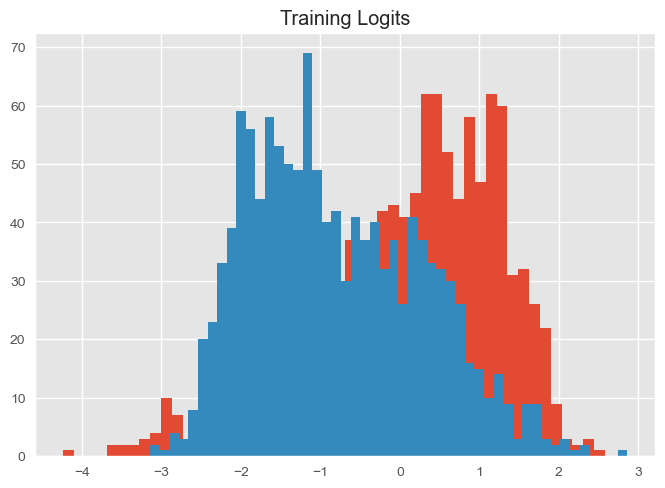

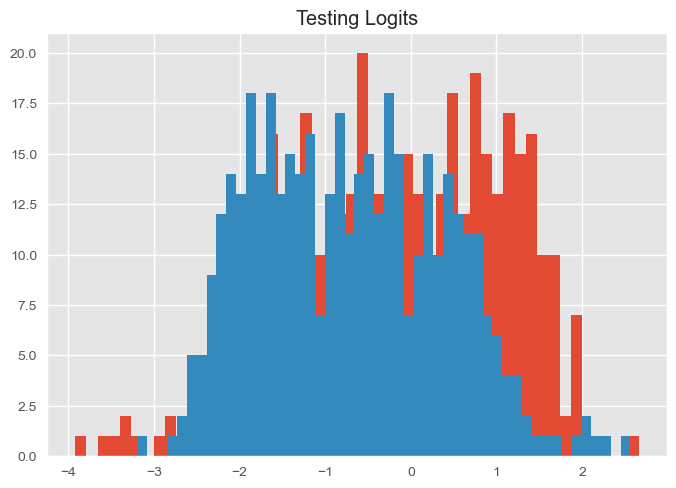

Epoch: 035, Train Acc: 0.8606, Test Acc: 0.8116
Epoch: 035, train_signal_acc: 0.6667, train_background_acc: 0.8630
Epoch: 035, test_signal_acc: 1.0000, test_background_acc: 0.8084
Epoch: 036, Train Acc: 0.8687, Test Acc: 0.8188
Epoch: 036, train_signal_acc: 0.7333, train_background_acc: 0.8703
Epoch: 036, test_signal_acc: 1.0000, test_background_acc: 0.8157
Epoch: 037, Train Acc: 0.8695, Test Acc: 0.8285
Epoch: 037, train_signal_acc: 0.6667, train_background_acc: 0.8719
Epoch: 037, test_signal_acc: 1.0000, test_background_acc: 0.8256
Epoch: 038, Train Acc: 0.8775, Test Acc: 0.8357
Epoch: 038, train_signal_acc: 0.7333, train_background_acc: 0.8793
Epoch: 038, test_signal_acc: 1.0000, test_background_acc: 0.8329
Epoch: 039, Train Acc: 0.8856, Test Acc: 0.8454
Epoch: 039, train_signal_acc: 0.6667, train_background_acc: 0.8883
Epoch: 039, test_signal_acc: 1.0000, test_background_acc: 0.8428


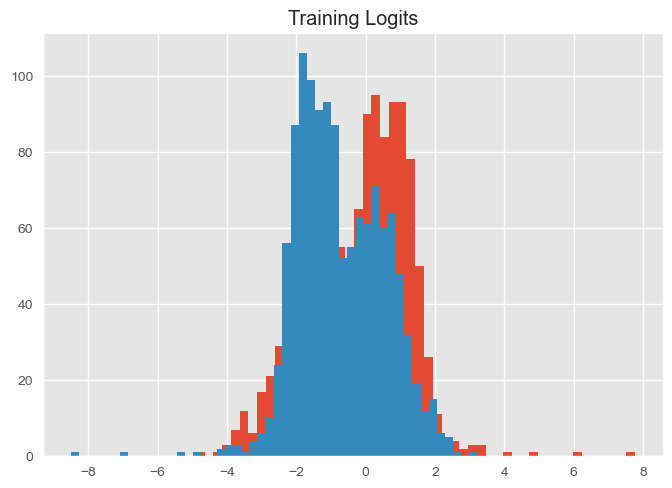

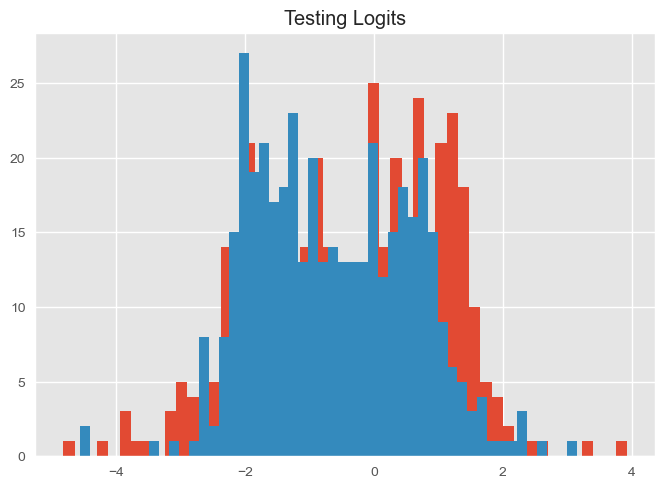

Epoch: 040, Train Acc: 0.8928, Test Acc: 0.8551
Epoch: 040, train_signal_acc: 0.8000, train_background_acc: 0.8940
Epoch: 040, test_signal_acc: 1.0000, test_background_acc: 0.8526
Epoch: 041, Train Acc: 0.8985, Test Acc: 0.8575
Epoch: 041, train_signal_acc: 0.8000, train_background_acc: 0.8997
Epoch: 041, test_signal_acc: 1.0000, test_background_acc: 0.8550
Epoch: 042, Train Acc: 0.9049, Test Acc: 0.8647
Epoch: 042, train_signal_acc: 0.8000, train_background_acc: 0.9062
Epoch: 042, test_signal_acc: 1.0000, test_background_acc: 0.8624
Epoch: 043, Train Acc: 0.9089, Test Acc: 0.8792
Epoch: 043, train_signal_acc: 0.8667, train_background_acc: 0.9095
Epoch: 043, test_signal_acc: 1.0000, test_background_acc: 0.8771
Epoch: 044, Train Acc: 0.9106, Test Acc: 0.8744
Epoch: 044, train_signal_acc: 0.9333, train_background_acc: 0.9103
Epoch: 044, test_signal_acc: 1.0000, test_background_acc: 0.8722


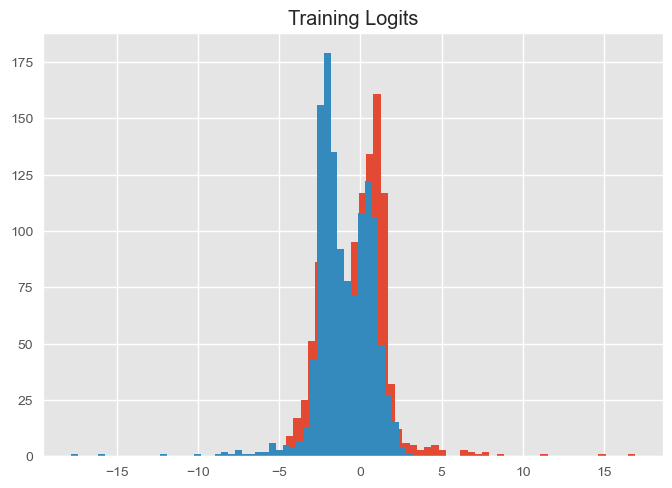

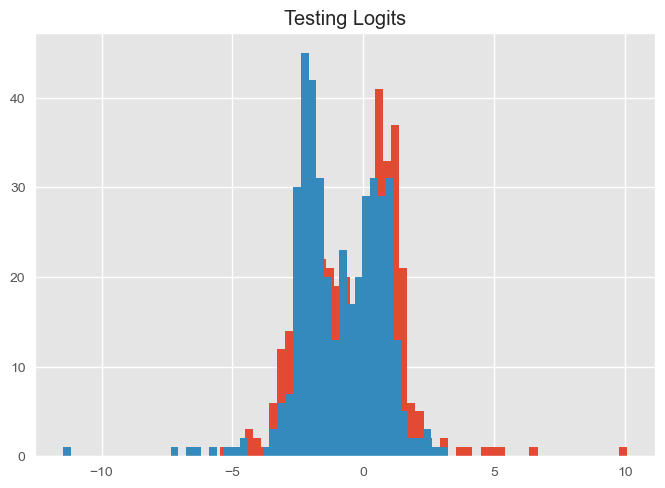

Epoch: 045, Train Acc: 0.9098, Test Acc: 0.8816
Epoch: 045, train_signal_acc: 0.9333, train_background_acc: 0.9095
Epoch: 045, test_signal_acc: 1.0000, test_background_acc: 0.8796
Epoch: 046, Train Acc: 0.9065, Test Acc: 0.8889
Epoch: 046, train_signal_acc: 0.9333, train_background_acc: 0.9062
Epoch: 046, test_signal_acc: 1.0000, test_background_acc: 0.8870
Epoch: 047, Train Acc: 0.9098, Test Acc: 0.8937
Epoch: 047, train_signal_acc: 0.9333, train_background_acc: 0.9095
Epoch: 047, test_signal_acc: 1.0000, test_background_acc: 0.8919
Epoch: 048, Train Acc: 0.9089, Test Acc: 0.8961
Epoch: 048, train_signal_acc: 0.9333, train_background_acc: 0.9086
Epoch: 048, test_signal_acc: 1.0000, test_background_acc: 0.8943
Epoch: 049, Train Acc: 0.9130, Test Acc: 0.8961
Epoch: 049, train_signal_acc: 0.9333, train_background_acc: 0.9127
Epoch: 049, test_signal_acc: 1.0000, test_background_acc: 0.8943


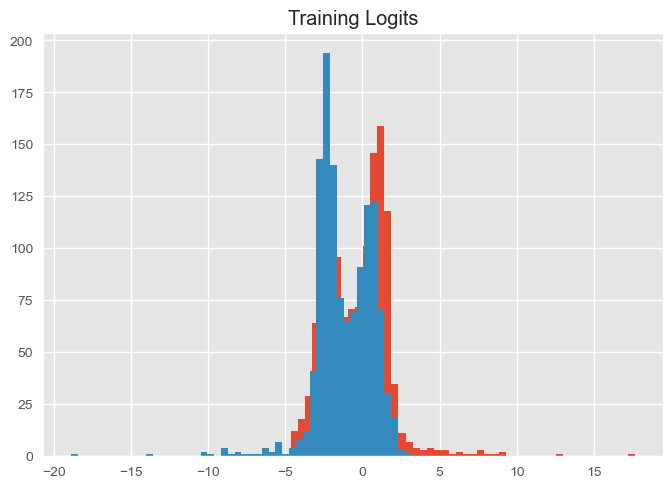

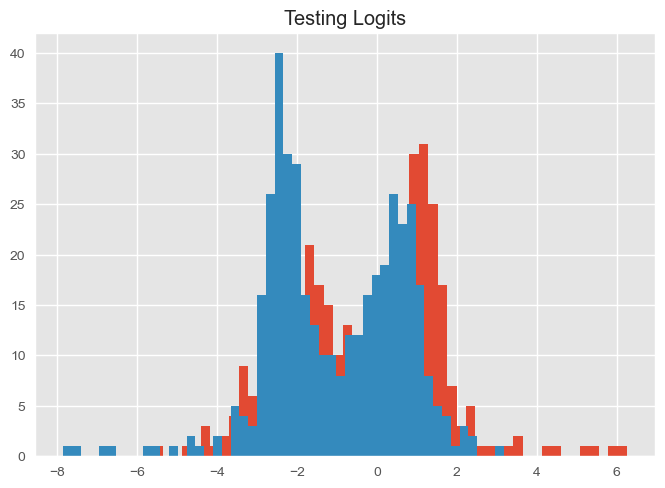

Epoch: 050, Train Acc: 0.9114, Test Acc: 0.8986
Epoch: 050, train_signal_acc: 0.9333, train_background_acc: 0.9111
Epoch: 050, test_signal_acc: 1.0000, test_background_acc: 0.8968
Epoch: 051, Train Acc: 0.9146, Test Acc: 0.8961
Epoch: 051, train_signal_acc: 0.9333, train_background_acc: 0.9144
Epoch: 051, test_signal_acc: 1.0000, test_background_acc: 0.8943
Epoch: 052, Train Acc: 0.9146, Test Acc: 0.9010
Epoch: 052, train_signal_acc: 0.9333, train_background_acc: 0.9144
Epoch: 052, test_signal_acc: 1.0000, test_background_acc: 0.8993
Epoch: 053, Train Acc: 0.9073, Test Acc: 0.8937
Epoch: 053, train_signal_acc: 0.9333, train_background_acc: 0.9070
Epoch: 053, test_signal_acc: 1.0000, test_background_acc: 0.8919
Epoch: 054, Train Acc: 0.9057, Test Acc: 0.8913
Epoch: 054, train_signal_acc: 0.9333, train_background_acc: 0.9054
Epoch: 054, test_signal_acc: 1.0000, test_background_acc: 0.8894


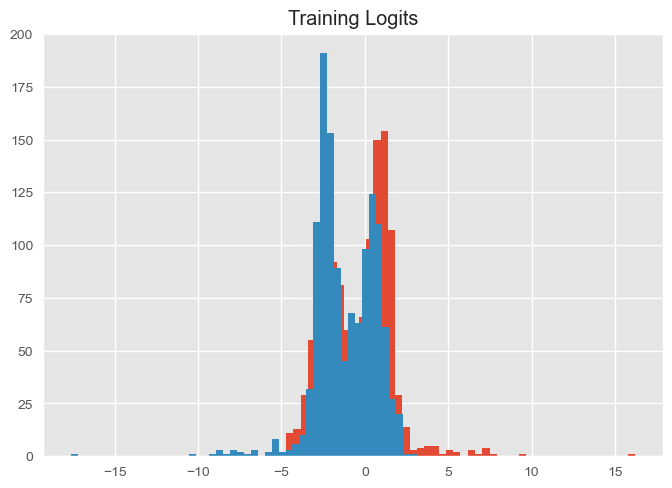

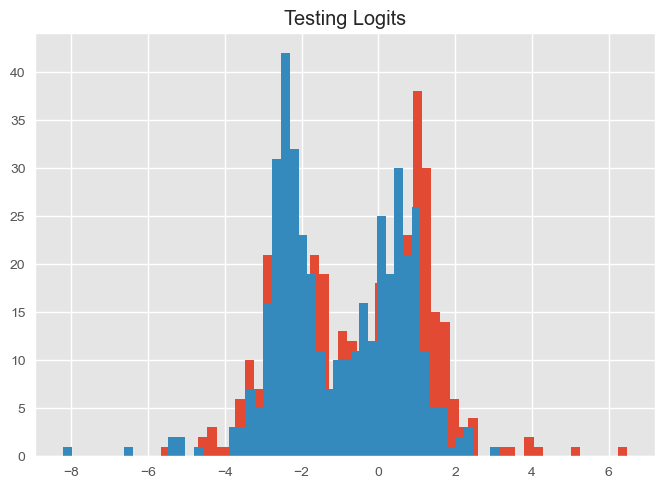

Epoch: 055, Train Acc: 0.9122, Test Acc: 0.9010
Epoch: 055, train_signal_acc: 0.9333, train_background_acc: 0.9119
Epoch: 055, test_signal_acc: 1.0000, test_background_acc: 0.8993
Epoch: 056, Train Acc: 0.9106, Test Acc: 0.8961
Epoch: 056, train_signal_acc: 0.9333, train_background_acc: 0.9103
Epoch: 056, test_signal_acc: 1.0000, test_background_acc: 0.8943
Epoch: 057, Train Acc: 0.9098, Test Acc: 0.8889
Epoch: 057, train_signal_acc: 0.9333, train_background_acc: 0.9095
Epoch: 057, test_signal_acc: 1.0000, test_background_acc: 0.8870
Epoch: 058, Train Acc: 0.9073, Test Acc: 0.8889
Epoch: 058, train_signal_acc: 0.9333, train_background_acc: 0.9070
Epoch: 058, test_signal_acc: 1.0000, test_background_acc: 0.8870
Epoch: 059, Train Acc: 0.9122, Test Acc: 0.8961
Epoch: 059, train_signal_acc: 0.9333, train_background_acc: 0.9119
Epoch: 059, test_signal_acc: 1.0000, test_background_acc: 0.8943


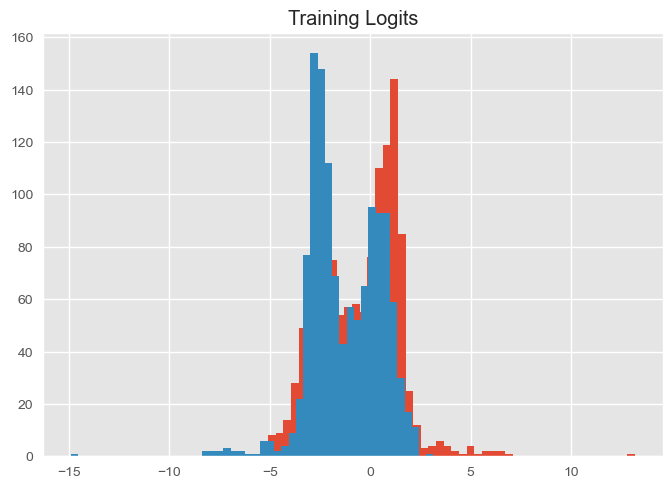

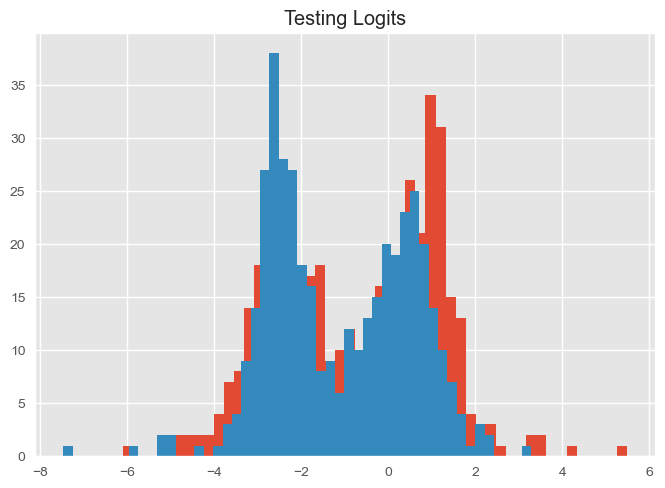

Epoch: 060, Train Acc: 0.9154, Test Acc: 0.8986
Epoch: 060, train_signal_acc: 0.9333, train_background_acc: 0.9152
Epoch: 060, test_signal_acc: 1.0000, test_background_acc: 0.8968
Epoch: 061, Train Acc: 0.9049, Test Acc: 0.8865
Epoch: 061, train_signal_acc: 1.0000, train_background_acc: 0.9038
Epoch: 061, test_signal_acc: 1.0000, test_background_acc: 0.8845
Epoch: 062, Train Acc: 0.9041, Test Acc: 0.8865
Epoch: 062, train_signal_acc: 1.0000, train_background_acc: 0.9029
Epoch: 062, test_signal_acc: 1.0000, test_background_acc: 0.8845
Epoch: 063, Train Acc: 0.9114, Test Acc: 0.8889
Epoch: 063, train_signal_acc: 0.9333, train_background_acc: 0.9111
Epoch: 063, test_signal_acc: 1.0000, test_background_acc: 0.8870
Epoch: 064, Train Acc: 0.9114, Test Acc: 0.8961
Epoch: 064, train_signal_acc: 0.9333, train_background_acc: 0.9111
Epoch: 064, test_signal_acc: 1.0000, test_background_acc: 0.8943


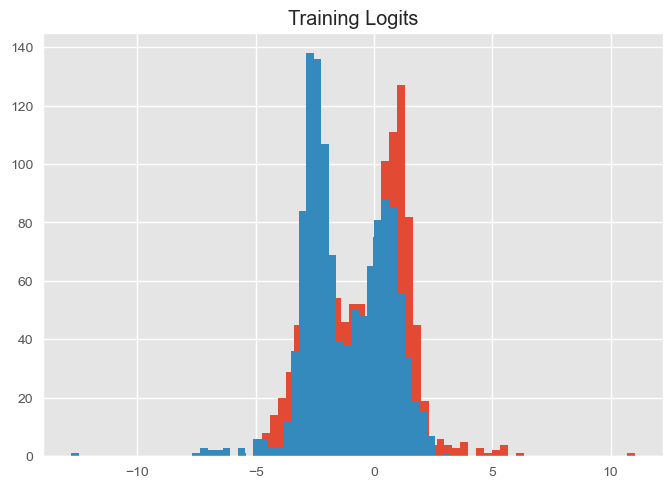

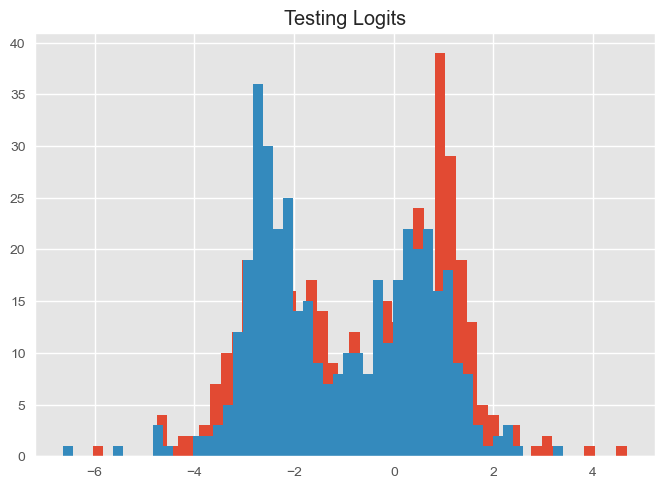

Epoch: 065, Train Acc: 0.9146, Test Acc: 0.9010
Epoch: 065, train_signal_acc: 0.9333, train_background_acc: 0.9144
Epoch: 065, test_signal_acc: 1.0000, test_background_acc: 0.8993
Epoch: 066, Train Acc: 0.9089, Test Acc: 0.8889
Epoch: 066, train_signal_acc: 0.9333, train_background_acc: 0.9086
Epoch: 066, test_signal_acc: 1.0000, test_background_acc: 0.8870
Epoch: 067, Train Acc: 0.9146, Test Acc: 0.8961
Epoch: 067, train_signal_acc: 0.9333, train_background_acc: 0.9144
Epoch: 067, test_signal_acc: 1.0000, test_background_acc: 0.8943
Epoch: 068, Train Acc: 0.9122, Test Acc: 0.8937
Epoch: 068, train_signal_acc: 1.0000, train_background_acc: 0.9111
Epoch: 068, test_signal_acc: 1.0000, test_background_acc: 0.8919
Epoch: 069, Train Acc: 0.9154, Test Acc: 0.8937
Epoch: 069, train_signal_acc: 0.9333, train_background_acc: 0.9152
Epoch: 069, test_signal_acc: 1.0000, test_background_acc: 0.8919


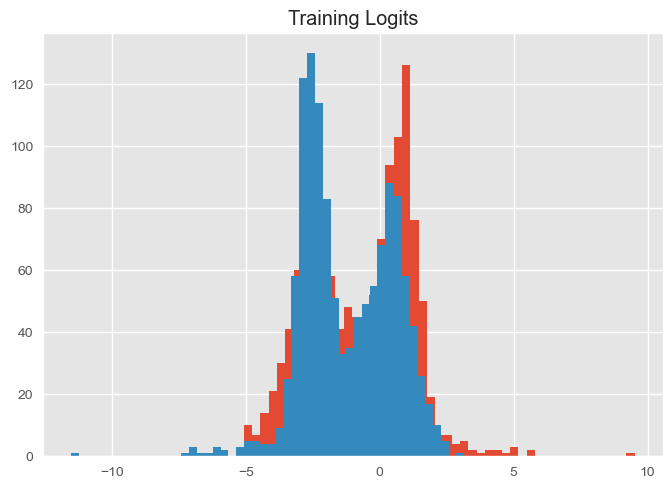

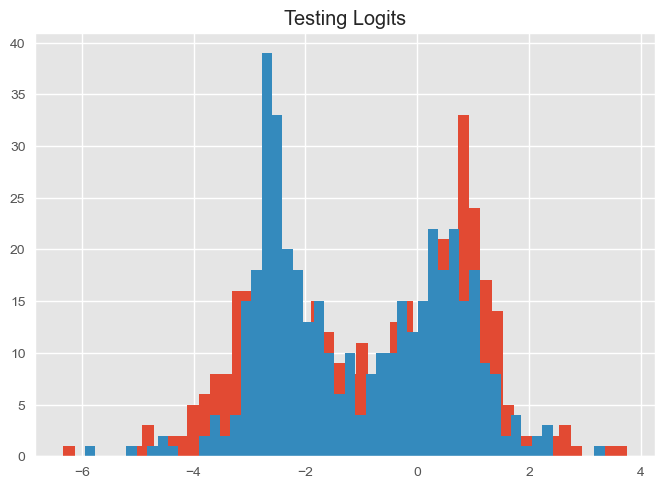

Epoch: 070, Train Acc: 0.9122, Test Acc: 0.8937
Epoch: 070, train_signal_acc: 1.0000, train_background_acc: 0.9111
Epoch: 070, test_signal_acc: 1.0000, test_background_acc: 0.8919
Epoch: 071, Train Acc: 0.9154, Test Acc: 0.9010
Epoch: 071, train_signal_acc: 0.9333, train_background_acc: 0.9152
Epoch: 071, test_signal_acc: 1.0000, test_background_acc: 0.8993
Epoch: 072, Train Acc: 0.9154, Test Acc: 0.8986
Epoch: 072, train_signal_acc: 0.9333, train_background_acc: 0.9152
Epoch: 072, test_signal_acc: 1.0000, test_background_acc: 0.8968
Epoch: 073, Train Acc: 0.9017, Test Acc: 0.8865
Epoch: 073, train_signal_acc: 1.0000, train_background_acc: 0.9005
Epoch: 073, test_signal_acc: 1.0000, test_background_acc: 0.8845
Epoch: 074, Train Acc: 0.9146, Test Acc: 0.8961
Epoch: 074, train_signal_acc: 1.0000, train_background_acc: 0.9135
Epoch: 074, test_signal_acc: 1.0000, test_background_acc: 0.8943


In [83]:
plt.style.use("ggplot")

for epoch in range(1, 75):
    train()
    
    
    train_acc,train_signal_acc,train_background_acc = test(train_loader,isSignalArrayTraining) \
    #,outTrain = test(train_loader,isSignalArrayTraining)
    #,trainSignalLoc \
    #,trainBackgroundLoc \
    #= test(train_loader,isSignalArrayTraining)
    
    test_acc,test_signal_acc,test_background_acc = test(test_loader,isSignalArrayTesting) \
    #,outTest = test(test_loader,isSignalArrayTesting)
    #,testSignalLoc \
    #,testBackgroundLoc \
   # = test(test_loader,isSignalArrayTesting)
    
    
    
    
############################## visualize logits, requires uncommenting line in function above ############################    
    #outTrainLogits = []
    #for tensor in outTrain:
    #    outTrainLogits += tensor.detach().numpy().tolist()
    #outTrainLogits = np.array(outTrain)
    
    #outTestLogits = []
    #for tensor in outTest:
    #    outTestLogits += tensor.detach().numpy().tolist()
    #outTestLogits = np.array(outTest)
    
    
    
    #fig, axs = plt.subplots(2, 2)
    
    #if epoch==1 or epoch%5==0:
    #    #plt.title("Training Logits")
    #    plt.title('Training Logits')
    #    plt.hist(outTrainLogits[:,0],bins=50)
    #    plt.hist(outTrainLogits[:,1],bins=50)
    #    plt.show()
#
    #    plt.title("Testing Logits")
    #    plt.hist(outTestLogits[:,0],bins=50)
    #    plt.hist(outTestLogits[:,1],bins=50)
    #    plt.show()
    
    
    #axs = axs.ravel()
    #for idx,ax in enumerate(axs):
    #    ax.hist(data[idx])
    #    ax.set_title(titles[idx])
    #    ax.set_xlabel(xaxes[idx])
    #    ax.set_ylabel(yaxes[idx])
    #plt.tight_layout()
    
    
    #for name, param in model.named_parameters():
    #    if param.requires_grad:
    #        summedParam = sum(param.data)
    #trainSignalAccList += [train_signal_acc]
    #testSignalAccList += [test_signal_acc]
    #trainSignalOutList += [trainSignalLoc]
    #testSignalOutList += [testSignalLoc]

    #trainBackgroundList += [train_background_acc]
    #testBackgroundList += [test_background_acc]
    #trainBackgroundOutList += [trainBackgroundLoc]
    #testBackgroundOutList += [testBackgroundLoc]
    
    #outTestList += outTest
    #outTrainList += outTrain
###########################################################################################################################    

    print(f'''Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}''')
    print(f'''Epoch: {epoch:03d}, train_signal_acc: {train_signal_acc:.4f}, train_background_acc: {train_background_acc:.4f}''')
    print(f'''Epoch: {epoch:03d}, test_signal_acc: {test_signal_acc:.4f}, test_background_acc: {test_background_acc:.4f}''')

In [39]:
axs[0].ipynb_checkpoints/

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

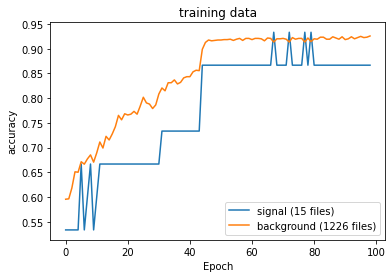

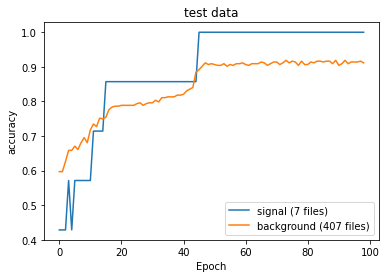

In [70]:
import matplotlib.pyplot as plt
plt.plot(trainSignalAccList,label="signal ({} files)".format(len(np.where(allGraphData[0:endTrainData,:][:,-1]==1)[0])))
plt.plot(trainBackgroundList,label="background ({} files)".format(len(np.where(allGraphData[0:endTrainData,:][:,-1]==0)[0])))
plt.title("training data")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.plot(testSignalAccList,label="signal ({} files)".format(len(np.where(allGraphData[endTrainData:,:][:,-1]==1)[0])))
plt.plot(testBackgroundList,label="background ({} files)".format(len(np.where(allGraphData[endTrainData:,:][:,-1]==0)[0])))
plt.title("test data")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [85]:
outTest

[[0.44014695286750793, -2.135366201400757],
 [-3.765791416168213, 1.5016264915466309],
 [0.9167006611824036, -2.4005603790283203],
 [-3.397305727005005, 1.2983322143554688],
 [0.7236846089363098, -2.4486844539642334],
 [-2.433525562286377, 0.4705725312232971],
 [0.0070306286215782166, -1.6878927946090698],
 [0.5094794631004333, -2.2493021488189697],
 [-1.4687004089355469, -0.17617054283618927],
 [-2.9195566177368164, 0.3439379334449768],
 [-1.1867581605911255, -0.3704065680503845],
 [-2.865100383758545, 0.8817026615142822],
 [-3.025548219680786, 0.9388170838356018],
 [-2.8235368728637695, 0.8083773851394653],
 [1.2294931411743164, -2.668344497680664],
 [-2.242093563079834, 0.4053833484649658],
 [0.8120042681694031, -2.609682321548462],
 [-2.5126492977142334, 0.6839691996574402],
 [-0.9678811430931091, -1.0298985242843628],
 [1.4046214818954468, -2.7513587474823],
 [-2.0750019550323486, 0.2681596875190735],
 [-3.221367597579956, 1.0687494277954102],
 [0.6917626857757568, -2.152193307876

In [89]:
class_prob = torch.softmax(torch.tensor(outTest), dim=1)
class_prob

tensor([[9.2927e-01, 7.0731e-02],
        [5.1305e-03, 9.9487e-01],
        [9.6502e-01, 3.4984e-02],
        [9.0523e-03, 9.9095e-01],
        [9.5978e-01, 4.0219e-02],
        [5.1951e-02, 9.4805e-01],
        [8.4487e-01, 1.5513e-01],
        [9.4041e-01, 5.9593e-02],
        [2.1542e-01, 7.8458e-01],
        [3.6845e-02, 9.6315e-01],
        [3.0654e-01, 6.9346e-01],
        [2.3049e-02, 9.7695e-01],
        [1.8627e-02, 9.8137e-01],
        [2.5783e-02, 9.7422e-01],
        [9.8012e-01, 1.9882e-02],
        [6.6145e-02, 9.3386e-01],
        [9.6838e-01, 3.1625e-02],
        [3.9293e-02, 9.6071e-01],
        [5.1550e-01, 4.8450e-01],
        [9.8457e-01, 1.5429e-02],
        [8.7611e-02, 9.1239e-01],
        [1.3518e-02, 9.8648e-01],
        [9.4501e-01, 5.4995e-02],
        [9.8360e-01, 1.6400e-02],
        [7.2516e-05, 9.9993e-01],
        [1.5708e-01, 8.4292e-01],
        [9.0409e-01, 9.5907e-02],
        [1.8490e-02, 9.8151e-01],
        [9.6531e-01, 3.4689e-02],
        [9.675

In [87]:
# get most probable class and its probability:
class_prob, topclass = torch.max(class_prob, dim=1)

In [91]:
topclass.detach().numpy()

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,

In [88]:
class_prob

tensor([0.9293, 0.9949, 0.9650, 0.9909, 0.9598, 0.9480, 0.8449, 0.9404, 0.7846,
        0.9632, 0.6935, 0.9770, 0.9814, 0.9742, 0.9801, 0.9339, 0.9684, 0.9607,
        0.5155, 0.9846, 0.9124, 0.9865, 0.9450, 0.9836, 0.9999, 0.8429, 0.9041,
        0.9815, 0.9653, 0.9676, 0.9943, 0.8532, 0.8969, 0.8745, 0.9118, 0.9879,
        0.9637, 0.9501, 0.9359, 0.9905, 0.8195, 0.7507, 0.7370, 0.9737, 0.9899,
        0.5382, 0.9763, 0.8246, 0.9831, 0.9745, 0.8960, 0.9614, 0.7860, 0.8234,
        0.9204, 0.9839, 0.7736, 0.9114, 0.8083, 0.8670, 0.9382, 0.9731, 0.9797,
        0.7826, 0.9729, 0.9882, 0.9502, 0.9623, 0.7802, 0.9563, 0.7825, 0.9007,
        0.9743, 0.7044, 0.9807, 0.9901, 0.9640, 0.8745, 0.9277, 0.9419, 0.9820,
        0.8049, 0.9741, 0.9362, 0.9989, 0.8180, 0.9413, 0.7510, 0.5966, 0.8268,
        0.9980, 0.9593, 0.8985, 0.5835, 0.9871, 0.9370, 0.8902, 0.5228, 0.7566,
        0.9690, 0.8790, 0.8581, 0.8942, 0.9876, 0.8193, 0.9325, 0.5051, 0.9808,
        0.5949, 0.9934, 0.9680, 0.9191, 

In [54]:
train()


train_acc,train_signal_acc,train_background_acc \
,outTrain = test(train_loader,isSignalArrayTraining)
#,trainSignalLoc \
#,trainBackgroundLoc \
#= test(train_loader,isSignalArrayTraining)

test_acc,test_signal_acc,test_background_acc \
,outTest = test(test_loader,isSignalArrayTesting)

0
0


In [28]:
import matplotlib.pyplot as plt
#plt.hist(outTest[0].detach().numpy())
a = []
for tensor in outTest:
    a += tensor.detach().numpy().tolist()
a = np.array(a)

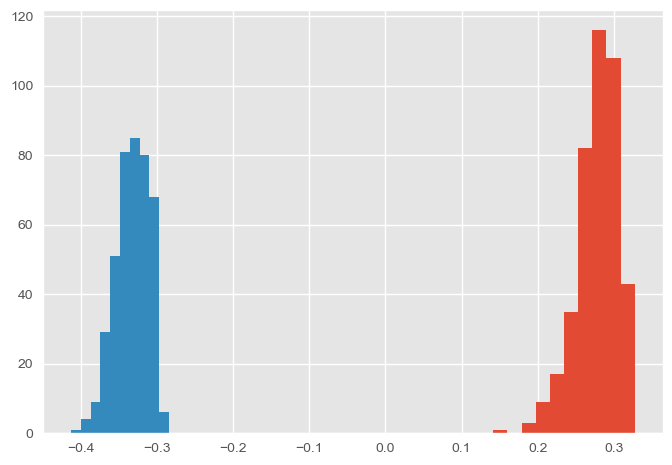

In [32]:
plt.style.use("ggplot")
plt.hist(a[:,0])
plt.hist(a[:,1])
plt.show()

In [14]:
outTrain

tensor([[-1.5539,  1.2936],
        [ 0.6448, -0.7814],
        [ 1.6048, -1.6779],
        [ 0.9593, -1.0829],
        [ 0.1187, -0.2975],
        [-0.1194, -0.0579],
        [-0.9581,  0.7528],
        [ 0.9684, -1.0900],
        [ 1.6070, -1.6948],
        [-1.4971,  1.2724],
        [ 1.7946, -1.8728],
        [ 1.2763, -1.3797],
        [ 0.9528, -1.0591],
        [ 1.3307, -1.4214],
        [-0.6668,  0.4880],
        [-1.8270,  1.5721],
        [ 1.6387, -1.7247],
        [ 1.6990, -1.7694],
        [-1.8681,  1.5909],
        [ 1.8894, -1.9607],
        [ 1.5959, -1.6824],
        [ 0.8348, -0.9630],
        [ 1.4050, -1.5021],
        [-0.8865,  0.6947],
        [-1.3138,  1.1121]], grad_fn=<AddmmBackward0>)

In [17]:
!nvidia-smi

Mon May 15 19:44:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090       WDDM | 00000000:01:00.0  On |                  Off |
|  0%   41C    P8               30W / 450W|   1342MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

'cuda'

In [88]:
model = GAT(hidden_channels=64, num_classes=2, num_node_features = 4)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
criterion = torch.nn.CrossEntropyLoss()
isSignalArrayTraining = allGraphData[0:endTrainData,:][:,-1]
isSignalArrayTesting = allGraphData[endTrainData:,:][:,-1]

trainSignalAccList = []
testSignalAccList = []

trainBackgroundList = []
testBackgroundList = []


train()
train_acc,train_signal_acc,train_background_acc,outTrain = test(train_loader,isSignalArrayTraining)
test_acc,test_signal_acc,test_background_acc,outTest = test(test_loader,isSignalArrayTesting)
#for name, param in model.named_parameters():
#    if param.requires_grad:
#        summedParam = sum(param.data)
trainSignalAccList += [train_signal_acc]
testSignalAccList += [test_signal_acc]

trainBackgroundList += [train_background_acc]
testBackgroundList += [test_background_acc]


print(f'''Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}''')
print(f'''Epoch: {epoch:03d}, train_signal_acc: {train_signal_acc:.4f}, train_background_acc: {train_background_acc:.4f}''')
print(f'''Epoch: {epoch:03d}, test_signal_acc: {test_signal_acc:.4f}, test_background_acc: {test_background_acc:.4f}''')

Epoch: 099, Train Acc: 0.5923, Test Acc: 0.6014
Epoch: 099, train_signal_acc: 0.5882, train_background_acc: 0.5923
Epoch: 099, test_signal_acc: 0.2000, test_background_acc: 0.6064


In [93]:
outTest

tensor([[ 0.4045, -0.2035],
        [ 0.3979, -0.2068],
        [ 0.4153, -0.2028],
        [ 0.3956, -0.2114],
        [ 0.4006, -0.1467],
        [ 0.4114, -0.1894],
        [ 0.4168, -0.2058],
        [ 0.4074, -0.1837],
        [ 0.3981, -0.1969],
        [ 0.4197, -0.2240],
        [ 0.3873, -0.1441],
        [ 0.4192, -0.2095],
        [ 0.3923, -0.2130],
        [ 0.3965, -0.2252],
        [ 0.3975, -0.1968],
        [ 0.4051, -0.1971],
        [ 0.4037, -0.1850],
        [ 0.4040, -0.2060],
        [ 0.4046, -0.2140],
        [ 0.3833, -0.2009],
        [ 0.4083, -0.1935],
        [ 0.4017, -0.2117],
        [ 0.3922, -0.1892],
        [ 0.3940, -0.1701],
        [ 0.3877, -0.1835],
        [ 0.3917, -0.1676],
        [ 0.4175, -0.1895],
        [ 0.4092, -0.2172],
        [ 0.4219, -0.2278],
        [ 0.3860, -0.1881]], grad_fn=<AddmmBackward0>)

In [96]:
outTest.argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [104]:
trainSignalOutList[0]

tensor([[ 0.3398, -0.3039]], grad_fn=<IndexBackward0>)